In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
# Import Ngl with pyn_env active 
# import Ngl

# import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
## Need to use metPy conda env
import metpy.calc as mpc
from metpy.units import units

import warnings
warnings.filterwarnings('ignore')


In [2]:

# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds



In [3]:
'''
Define a function to get the height of the PBL as the level with maximum d(var)/dz. 
Inputs:  A dataset with CAM output ('DS') and the variable to differentiate ('pbl_var')
Outputs: An array with boundary layer depth
'''
def PBLHasMaxDZ(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

In [4]:
'''
Define a function to get the height of the PBL as the level with maximum d(var)/dz. 
Inputs:  A dataset with CAM output ('DS') and the variable to differentiate ('pbl_var')
Outputs: An array with boundary layer depth
'''
def PBLHasMaxDZ_abs(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(np.abs(dvardz[iT,iLevs])==np.nanmax(np.abs(dvardz[iT,iLevs])))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

In [5]:
'''
Function to send back which classification each day falls into, 
based on precipitation amount, similar to Burns et al. (2015; 2018).
This version of the function assumes a single column run/input, 
in that only one dimension exists for precip. 

Inputs: 
   time:   An array of times to worry about. 
           Should be a pandas datetime.
   precip: Daily precipitation (summed). Units can be in mm or m, 
           but need to be consistent with the threshold the user
           defines (i.e., no unit conversions done here).
   wetDef: User-defined threshold for defining days as wet vs. dry. 
Outputs:
    classificationArr: Array with one fewer length than time, where
                       the classification falls into four categories:
                       1 :: wWet   (wet day following a wet day)
                       2 :: wDry   (dry day following a wet day)
                       3 :: dWet   (wet day following a dry day)
                       4 :: dDry   (dry day following a dry day)
                       
                       Difference in length due to the first day not having a 
                       "before" day to reference. So time[0] on the 
                       classification array corresponds to time[1]. 

'''

def classifyPrectDays_SCAM(time,precip,wetDef): 
    
    # Define empty arrays of the appropriate length
    nTimes               = len(time)
    classificationArr    = np.empty([len(time)]).astype('str')
    classificationArr[0] = 'n/a'
    
    for iDay in range(nTimes-1): 
        
        # Wet day...
        if precip[iDay]>=wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'wWet'  # Wet day following wet 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'wDry' # Dry day following wet 
        # Dry day...
        elif precip[iDay]<wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'dWet'  # Wet day following dry 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'dDry' # Dry day following dry 

    return(classificationArr)




In [6]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDayClass(fullDS, dayClassDS):
    iTimes = []
    
    for iTime in range(len(dayClassDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==dayClassDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==dayClassDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==dayClassDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)

In [7]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_WithErrBar_timeOfDayMean_real(startHr, endHr, varSel, minLev, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMGreal["time.hour"].values>=startHr) & 
                                (dDryDays_HMGreal["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTGreal["time.hour"].values>=startHr) & 
                                (dDryDays_HTGreal["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG10 = np.where((dDryDays_HTGreal10["time.hour"].values>=startHr) & 
                                  (dDryDays_HTGreal10["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG   = dDryDays_HMGreal.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG   = dDryDays_HTGreal.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG10   = dDryDays_HTGreal10.isel(time=iTimeSel_dDryHTG10).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG   = dDryDays_HMGreal.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG   = dDryDays_HTGreal.isel(time=iTimeSel_dDryHTG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG10   = dDryDays_HTGreal10.isel(time=iTimeSel_dDryHTG10).std(dim='time')
    
    stdErr_dDry_HMG   = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG   = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))
    stdErr_dDry_HTG10   = np.squeeze(hourlyStd_dDryTimeSel_HTG10[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG10))
    

    # ------- wWet days ----------
    iTimeSel_wWetHMG = np.where((wWetDays_HMGreal["time.hour"].values>=startHr) & 
                                (wWetDays_HMGreal["time.hour"].values<=endHr))[0]
    iTimeSel_wWetHTG = np.where((wWetDays_HTGreal["time.hour"].values>=startHr) & 
                                (wWetDays_HTGreal["time.hour"].values<=endHr))[0]
    iTimeSel_wWetHTG10 = np.where((wWetDays_HTGreal10["time.hour"].values>=startHr) & 
                                  (wWetDays_HTGreal10["time.hour"].values<=endHr))[0]

    hourlyMean_wWetTimeSel_HMG   = wWetDays_HMGreal.isel(time=iTimeSel_wWetHMG).mean(dim='time')
    hourlyMean_wWetTimeSel_HTG   = wWetDays_HTGreal.isel(time=iTimeSel_wWetHTG).mean(dim='time')
    hourlyMean_wWetTimeSel_HTG10 = wWetDays_HTGreal10.isel(time=iTimeSel_wWetHTG10).mean(dim='time')

    
    hourlyStd_wWetTimeSel_HMG   = wWetDays_HMGreal.isel(time=iTimeSel_wWetHMG).std(dim='time')
    hourlyStd_wWetTimeSel_HTG   = wWetDays_HTGreal.isel(time=iTimeSel_wWetHTG).std(dim='time')
    hourlyStd_wWetTimeSel_HTG10   = wWetDays_HTGreal10.isel(time=iTimeSel_wWetHTG10).std(dim='time')

    
    stdErr_wWet_HMG   = np.squeeze(hourlyStd_wWetTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_wWetHMG))
    stdErr_wWet_HTG   = np.squeeze(hourlyStd_wWetTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_wWetHTG))
    stdErr_wWet_HTG10   = np.squeeze(hourlyStd_wWetTimeSel_HTG10[varSel].values)/np.sqrt(len(iTimeSel_wWetHTG10))

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    axs     = axs.ravel()
    
    # Select which levels array to use
    if np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.lev.values):
        levSel = 'lev'
        
    if varSel=='WindMagnitude':
        unitLabel  = HTGcamDS_localArt['U'].units
        titleStr   = varSel
    elif varSel=='theta':
        unitLabel = HTGcamDS_localArt['T'].units
        titleStr   = varSel
    elif varSel=='Skw_W':
        unitLabel = ' '
        titleStr   = varSel
    elif varSel=='TKE':
        unitLabel = HTGcamDS_localArt['UP2_CLUBB'].units
        titleStr = varSel
    elif varSel=='dQTdz':
        unitLabel = ' '
        titleStr   = varSel
    elif varSel=='dWP2RTP_CLUBBdz':
        unitLabel = ' '
        titleStr   = varSel
    else: 
        unitLabel  = HTGcamDS_localArt[varSel].units
        titleStr   = HTGcamDS_localArt[varSel].long_name
    
    # Plot dDry days 
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dDry_HMG,
#                     fmt='r-', capsize=3, label='HMG')
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
                    hourlyMean_dDryTimeSel_HMG[levSel].values,
                    '-',color='orange',  label='HMG_real')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
                    hourlyMean_dDryTimeSel_HTG[levSel].values,
                    '-',color='violet', label='HTG_real')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG10[varSel].values), 
                    hourlyMean_dDryTimeSel_HTG10[levSel].values,
                    '-',color='purple', label='HTG_real*10')
    axs[0].legend()
    axs[0].set_title(titleStr+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel('m')
    axs[0].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(hourlyMean_dDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
#             if abs(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev]):
            axs[0].plot(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_dDryTimeSel_HMG[levSel].values[iLev], 
                        'o',color='orange')
#             else:
            axs[0].plot(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev], 
                    hourlyMean_dDryTimeSel_HTG[levSel].values[iLev], 
                    'o',color='violet')
    
            

    # Plot wWet days 
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wWet_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wWet_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
                    hourlyMean_wWetTimeSel_HMG[levSel].values,
                    '-',color='orange', label='HMG_real')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG[levSel].values,
                    '-',color='violet', label='HTG_real')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG10[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG10[levSel].values,
                    '-',color='purple', label='HTG_real*10')
    
#     axs[1].legend()
    axs[1].set_title(varSel+'\nwWet days')
    axs[1].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) + (2*stdErr_wWet_HMG)
    xmin1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) - (2*stdErr_wWet_HMG)
    xmax2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) + (2*stdErr_wWet_HTG)
    xmin2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) - (2*stdErr_wWet_HTG)

    levSig = np.ones([len(hourlyMean_wWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
#             if abs(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev]):
            axs[1].plot(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HMG[levSel].values[iLev], 
                        'o',color='orange')
#             else:
            axs[1].plot(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HTG[levSel].values[iLev], 
                        'o',color='violet')

    # Consistent settings across subplots 
    axs[0].set_ylim([minLev,maxLev])
    axs[1].set_ylim([minLev,maxLev])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()

    
    return

In [8]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, varSel, minLev, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMGart["time.hour"].values>=startHr) & 
                                (dDryDays_HMGart["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTGart["time.hour"].values>=startHr) & 
                                (dDryDays_HTGart["time.hour"].values<=endHr))[0]
    
    iTimeSel_dDryHTG5  = np.where((dDryDays_HTGart5["time.hour"].values>=startHr) & 
                                  (dDryDays_HTGart5["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG25 = np.where((dDryDays_HTGart25["time.hour"].values>=startHr) & 
                                  (dDryDays_HTGart25["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG   = dDryDays_HMGart.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG   = dDryDays_HTGart.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG5  = dDryDays_HTGart5.isel(time=iTimeSel_dDryHTG5).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG25 = dDryDays_HTGart25.isel(time=iTimeSel_dDryHTG25).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG   = dDryDays_HMGart.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG   = dDryDays_HTGart.isel(time=iTimeSel_dDryHTG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG5  = dDryDays_HTGart5.isel(time=iTimeSel_dDryHTG5).std(dim='time')
    hourlyStd_dDryTimeSel_HTG25 = dDryDays_HTGart25.isel(time=iTimeSel_dDryHTG25).std(dim='time')
    
    stdErr_dDry_HMG   = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG   = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))
    stdErr_dDry_HTG5  = np.squeeze(hourlyStd_dDryTimeSel_HTG5[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG5))
    stdErr_dDry_HTG25 = np.squeeze(hourlyStd_dDryTimeSel_HTG25[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG25))
    

    # ------- wWet days ----------
    iTimeSel_wWetHMG = np.where((wWetDays_HMGart["time.hour"].values>=startHr) & 
                                (wWetDays_HMGart["time.hour"].values<=endHr))[0]
    iTimeSel_wWetHTG = np.where((wWetDays_HTGart["time.hour"].values>=startHr) & 
                                (wWetDays_HTGart["time.hour"].values<=endHr))[0]
    iTimeSel_wWetHTG5  = np.where((wWetDays_HTGart5["time.hour"].values>=startHr) & 
                                  (wWetDays_HTGart5["time.hour"].values<=endHr))[0]
    iTimeSel_wWetHTG25 = np.where((wWetDays_HTGart25["time.hour"].values>=startHr) & 
                                  (wWetDays_HTGart25["time.hour"].values<=endHr))[0]
    

    hourlyMean_wWetTimeSel_HMG   = wWetDays_HMGart.isel(time=iTimeSel_wWetHMG).mean(dim='time')
    hourlyMean_wWetTimeSel_HTG   = wWetDays_HTGart.isel(time=iTimeSel_wWetHTG).mean(dim='time')
    hourlyMean_wWetTimeSel_HTG5  = wWetDays_HTGart5.isel(time=iTimeSel_wWetHTG5).mean(dim='time')
    hourlyMean_wWetTimeSel_HTG25 = wWetDays_HTGart25.isel(time=iTimeSel_wWetHTG25).mean(dim='time')
    
    hourlyStd_wWetTimeSel_HMG   = wWetDays_HMGart.isel(time=iTimeSel_wWetHMG).std(dim='time')
    hourlyStd_wWetTimeSel_HTG   = wWetDays_HTGart.isel(time=iTimeSel_wWetHTG).std(dim='time')
    hourlyStd_wWetTimeSel_HTG5  = wWetDays_HTGart5.isel(time=iTimeSel_wWetHTG5).std(dim='time')
    hourlyStd_wWetTimeSel_HTG25 = wWetDays_HTGart25.isel(time=iTimeSel_wWetHTG25).std(dim='time')
    
    stdErr_wWet_HMG   = np.squeeze(hourlyStd_wWetTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_wWetHMG))
    stdErr_wWet_HTG   = np.squeeze(hourlyStd_wWetTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_wWetHTG))
    stdErr_wWet_HTG5  = np.squeeze(hourlyStd_wWetTimeSel_HTG5[varSel].values)/np.sqrt(len(iTimeSel_wWetHTG5))
    stdErr_wWet_HTG25 = np.squeeze(hourlyStd_wWetTimeSel_HTG25[varSel].values)/np.sqrt(len(iTimeSel_wWetHTG25))

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    axs     = axs.ravel()
    
    # Select which levels array to use
    if np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.lev.values):
        levSel = 'lev'
        
    if varSel=='WindMagnitude':
        unitLabel  = HTGcamDS_localArt['U'].units
        titleStr   = varSel
    elif varSel=='theta':
        unitLabel = HTGcamDS_localArt['T'].units
        titleStr   = varSel
    elif varSel=='Skw_W':
        unitLabel = ' '
        titleStr   = varSel
    elif varSel=='TKE':
        unitLabel = HTGcamDS_localArt['UP2_CLUBB'].units
        titleStr = varSel
    elif varSel=='dQTdz':
        unitLabel = ' '
        titleStr   = varSel
    elif varSel=='dWP2RTP_CLUBBdz':
        unitLabel = ' '
        titleStr   = varSel
    else: 
        unitLabel  = HTGcamDS_localArt[varSel].units
        titleStr   = HTGcamDS_localArt[varSel].long_name
    
    # Plot dDry days 
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
                    hourlyMean_dDryTimeSel_HMG[levSel].values,
                    'r-',  label='HMG_extra')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
                    hourlyMean_dDryTimeSel_HTG[levSel].values,
                    'b', label='HTG_extra')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG5[varSel].values), 
                    hourlyMean_dDryTimeSel_HTG5[levSel].values,
                    color='dodgerblue', label='HTG_extra*0.5')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG25[varSel].values), 
                    hourlyMean_dDryTimeSel_HTG25[levSel].values,
                    color='skyblue', label='HTG_extra(0.25)')
    
    axs[0].legend()
    axs[0].set_title(titleStr+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel('m')
    axs[0].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(hourlyMean_dDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[0].plot(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_dDryTimeSel_HMG[levSel].values[iLev], 
                        'ro')
            axs[0].plot(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev], 
                    hourlyMean_dDryTimeSel_HTG[levSel].values[iLev], 
                    'bo')
    
            

    # Plot wWet days 
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
                    hourlyMean_wWetTimeSel_HMG[levSel].values,
                    'r', label='HMG_extra')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG[levSel].values,
                    'b', label='HTG_extra')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG5[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG5[levSel].values,
                    color='dodgerblue', label='HTG_extra*0.5')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG25[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG25[levSel].values,
                    color='skyblue', label='HTG_extra*0.25')
    
    axs[1].set_title(varSel+'\nwWet days')
    axs[1].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) + (2*stdErr_wWet_HMG)
    xmin1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) - (2*stdErr_wWet_HMG)
    xmax2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) + (2*stdErr_wWet_HTG)
    xmin2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) - (2*stdErr_wWet_HTG)

    levSig = np.ones([len(hourlyMean_wWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[1].plot(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HMG[levSel].values[iLev], 
                        'ro')
            axs[1].plot(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HTG[levSel].values[iLev], 
                        'bo')

    # Consistent settings across subplots 
    axs[0].set_ylim([minLev,maxLev])
    axs[1].set_ylim([minLev,maxLev])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()

    
    return

In [9]:
def plotTimeHeightDifference_meanDiurnalCycle_contourf(HMGds, HTGds,
                                                       varSel,
                                                       minLev,maxLev,
                                                       levsDiff, levsRaw): 
    
    diffVar_dry   = np.squeeze(HTGds[varSel].values   - HMGds[varSel].values)

 
    ## Select which levels array to use
    if np.shape(HTGds[varSel].values)[1]==len(HTGds.ilev.values): 
        levSel = 'ilev'
    elif np.shape(HTGds[varSel].values)[1]==len(HTGds.lev.values):
        levSel = 'lev'
    
    ## Set up figure
    fig,axs = plt.subplots(1,3, figsize=(12,4))
    axs     = axs.ravel()    
    
    ## Plot raw values 
    contour_plot = axs[0].contourf(HTGds.hour.values, HTGds[levSel].values, 
                                     np.squeeze(HTGds[varSel].values).transpose(),
                                     levels=levsRaw, cmap='jet',extend='both')
    
    contour_plot = axs[1].contourf(HMGds.hour.values, HMGds[levSel].values, 
                                     np.squeeze(HMGds[varSel].values).transpose(),
                                     levels=levsRaw, cmap='jet',extend='both')
    
    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.2, ax_position.width+0.15, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    if varSel=='WindMagnitude':
        cbar.set_label('m/s',fontsize=11)
    elif varSel=='TKE':
        cbar.set_label('m2/s2',fontsize=11)
    elif varSel=='Skw_W':
        cbar.set_label('',fontsize=11)
    else:
        cbar.set_label(HTGcamDS_localReal[varSel].units,fontsize=11)
    
    ## Plot dry day difference 
    contour_plot = axs[2].contourf(HTGds.hour.values, HTGds[levSel].values, 
                                     diffVar_dry.transpose(),
                                     levels=levsDiff, cmap='bwr',extend='both')
    # Add colorbar
    ax_position = axs[2].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.08, ax_position.y0-0.2, ax_position.width+0.15, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    if varSel=='WindMagnitude':
        cbar.set_label('m/s',fontsize=11)
    elif varSel=='TKE':
        cbar.set_label('m2/s2',fontsize=11)
    elif varSel=='Skw_W':
        cbar.set_label('',fontsize=11)
    else:
        cbar.set_label(HTGcamDS_localReal[varSel].units,fontsize=11)
        
    ## Add markers of significant differences 
    for il in range(len(HTGds[levSel].values)):
        stdErr_dDry_HMG = np.squeeze(HMGds[varSel].values)[:,il]/np.sqrt(HMGds['SampleCount'].values)
        stdErr_dDry_HTG = np.squeeze(HTGds[varSel].values)[:,il]/np.sqrt(HTGds['SampleCount'].values)
       
        xmax1_dry = np.squeeze(HMGds[varSel].values)[:,il] + (2*stdErr_dDry_HMG)
        xmin1_dry = np.squeeze(HMGds[varSel].values)[:,il] - (2*stdErr_dDry_HMG)
        xmax2_dry = np.squeeze(HTGds[varSel].values)[:,il] + (2*stdErr_dDry_HTG)
        xmin2_dry = np.squeeze(HTGds[varSel].values)[:,il] - (2*stdErr_dDry_HTG)     
        
        levSig_dry = np.ones([24])
        levSig_wet = np.ones([24])
        for iHr in range(24):
            # Dry days
            if ((abs(xmin1_dry[iHr])>=abs(xmin2_dry[iHr])) & (abs(xmin1_dry[iHr])<=abs(xmax2_dry[iHr]))):
                levSig_dry[iHr] = 0
            elif ((abs(xmin2_dry[iHr])>=abs(xmin1_dry[iHr])) & (abs(xmin2_dry[iHr])<=abs(xmax1_dry[iHr]))):
                levSig_dry[iHr] = 0
        
            if levSig_dry[iHr]==1:
                axs[2].plot(HTGds['hour'].values[iHr], 
                        HTGds[levSel].values[il], 
                        'ko',alpha=0.3,markersize=2)
        
    # Other plot options
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    
    axs[0].set_ylim([minLev, maxLev])
    axs[1].set_ylim([minLev, maxLev])
    axs[2].set_ylim([minLev, maxLev])
    
    axs[0].set_title(varSel+' on Dry Days\nHTG')
    axs[1].set_title('HMG')
    axs[2].set_title('Difference (HTG-HMG)')
    
    axs[0].set_xlabel('Local Hour')
    axs[1].set_xlabel('Local Hour')
    axs[2].set_xlabel('Local Hour')
    axs[0].set_ylabel('hPa (model hybrid coord)')
    
    return

## Read in data


### Real surface 

In [12]:
saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

HMGcamDS_localReal        = pickle.load( open( saveDir+"HMGcamDS_localReal.p", "rb" ) )
HTGcamDS_localReal        = pickle.load( open( saveDir+"HTGcamDS_localReal.p", "rb" ) )
HTGcamDS_localReal10      = pickle.load( open( saveDir+"HTGcamDS_localReal10.p", "rb" ) )

HMGclmDS_localReal        = pickle.load( open( saveDir+"HMGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal        = pickle.load( open( saveDir+"HTGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal10      = pickle.load( open( saveDir+"HTGclmDS_localReal10.p", "rb" ) )

HMGclmDS_localRealPatch   = pickle.load( open( saveDir+"HMGclmDS_localRealPatch.p", "rb" ) )
HTGclmDS_localRealPatch   = pickle.load( open( saveDir+"HTGclmDS_localRealPatch.p", "rb" ) )
HTGclmDS_localRealPatch10 = pickle.load( open( saveDir+"HTGclmDS_localRealPatch10.p", "rb" ) )

print('Loaded all the real_sfc pickle files')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/HMGcamDS_localReal.p'

In [11]:
## Select only 2015 for C7 analysis 
iSel = np.where(HMGcamDS_localReal['time.year'].values==2015)[0]

HMGcamDS_localReal = HMGcamDS_localReal.isel(time=iSel)
HTGcamDS_localReal = HTGcamDS_localReal.isel(time=iSel)
HTGcamDS_localReal10 = HTGcamDS_localReal10.isel(time=iSel)

HMGclmDS_localReal = HMGclmDS_localReal.isel(time=iSel)
HTGclmDS_localReal = HTGclmDS_localReal.isel(time=iSel)
HTGclmDS_localReal10 = HTGclmDS_localReal10.isel(time=iSel)

HMGclmDS_localRealPatch = HMGclmDS_localRealPatch.isel(time=iSel)
HTGclmDS_localRealPatch = HTGclmDS_localRealPatch.isel(time=iSel)
HTGclmDS_localRealPatch10 = HTGclmDS_localRealPatch10.isel(time=iSel)


### Artificial surface (and multipliers)

In [12]:
# This version also outputs the buoyancy term, rt'thv', tau, and uses theta (not theta_v) for HTG additions
dataDirBase   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_buoyancyTau_useTheta/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'

dataDirC7p9      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_buoyancyTau_useTheta/c7_0p9/'
caseName_HMGc7p9 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_useTheta_'
caseName_HTGc7p9 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_useTheta_'

dataDirC7p7      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_buoyancyTau_useTheta/c7_0p7/'
caseName_HMGc7p7 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_useTheta_'
caseName_HTGc7p7 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_useTheta_'


# yearStrings  = np.asarray(['2015','2016','2017','2018'])
yearStrings  = np.asarray(['2015'])
dateEndFiles = np.asarray([ '-05-31-84585.nc',
                            '-06-09-56985.nc',
                            '-06-18-29385.nc',
                            '-06-27-01785.nc',
                            '-07-05-60585.nc',
                            '-07-14-32985.nc',
                            '-07-23-05385.nc',
                            '-07-31-64185.nc',
                            '-08-09-36585.nc',
                            '-08-18-08985.nc',
                            '-08-26-67785.nc' ])

fileCount=0
for iYr in range(len(yearStrings)): 
    fileStart_HMG = dataDirBase+caseName_HMG+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
    fileStart_HTG = dataDirBase+caseName_HTG+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
    
    fileStartPatch_HMG = dataDirBase+caseName_HMG+yearStrings[iYr]+'jja.clm2.h1.'+yearStrings[iYr]
    fileStartPatch_HTG = dataDirBase+caseName_HTG+yearStrings[iYr]+'jja.clm2.h1.'+yearStrings[iYr]
    
    fileStart_atm_HMG = dataDirBase+caseName_HMG+yearStrings[iYr]+'jja.cam.h1.'+yearStrings[iYr]
    fileStart_atm_HTG = dataDirBase+caseName_HTG+yearStrings[iYr]+'jja.cam.h1.'+yearStrings[iYr]
    
    
     ## C7 experiments
    fileStart_atm_HMGc7p9 = dataDirC7p9+caseName_HMGc7p9+yearStrings[iYr]+'jja.C7eq0p9.cam.h1.'+yearStrings[iYr]
    fileStart_atm_HTGc7p9 = dataDirC7p9+caseName_HTGc7p9+yearStrings[iYr]+'jja.C7eq0p9.cam.h1.'+yearStrings[iYr]

    fileStart_atm_HMGc7p7 = dataDirC7p7+caseName_HMGc7p7+yearStrings[iYr]+'jja.C7eq0p7.cam.h1.'+yearStrings[iYr]
    fileStart_atm_HTGc7p7 = dataDirC7p7+caseName_HTGc7p7+yearStrings[iYr]+'jja.C7eq0p7.cam.h1.'+yearStrings[iYr]

    
    for iFile in range(len(dateEndFiles)):
        fileName_HMG = fileStart_HMG+dateEndFiles[iFile]
        fileName_HTG = fileStart_HTG+dateEndFiles[iFile]
                                                                                          
        fileNamePatch_HMG = fileStartPatch_HMG+dateEndFiles[iFile]
        fileNamePatch_HTG = fileStartPatch_HTG+dateEndFiles[iFile]
        
        fileName_atm_HMG = fileStart_atm_HMG+dateEndFiles[iFile]
        fileName_atm_HTG = fileStart_atm_HTG+dateEndFiles[iFile]
        
        
        with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
            HMG_camDS = cesm_correct_time(HMG_camDS)
            HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
        with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
            HTG_camDS = cesm_correct_time(HTG_camDS)
            HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
            
        with xr.open_dataset(fileName_HMG, decode_times=True) as HMG_clmDS: 
            HMG_clmDS['time'] = HTG_camDS['time']
        with xr.open_dataset(fileName_HTG, decode_times=True) as HTG_clmDS: 
            HTG_clmDS['time'] = HTG_camDS['time']
            
        with xr.open_dataset(fileNamePatch_HMG, decode_times=True) as HMG_clmPatchDS: 
            HMG_clmPatchDS['time'] = HTG_camDS['time']
        with xr.open_dataset(fileNamePatch_HTG, decode_times=True) as HTG_clmPatchDS: 
            HTG_clmPatchDS['time'] = HTG_camDS['time']   
                    
        
        ## C7 versions 
        fileName_atm_HMGc7p9 = fileStart_atm_HMGc7p9+dateEndFiles[iFile]
        fileName_atm_HTGc7p9 = fileStart_atm_HTGc7p9+dateEndFiles[iFile]
        
        fileName_atm_HMGc7p7 = fileStart_atm_HMGc7p7+dateEndFiles[iFile]
        fileName_atm_HTGc7p7 = fileStart_atm_HTGc7p7+dateEndFiles[iFile]
        
        with xr.open_dataset(fileName_atm_HMGc7p9, decode_times=False) as HMGc7p9_camDS:
            HMGc7p9_camDS = cesm_correct_time(HMGc7p9_camDS)
            HMGc7p9_camDS['time'] = HMGc7p9_camDS.indexes['time'].to_datetimeindex()
        with xr.open_dataset(fileName_atm_HTGc7p9, decode_times=False) as HTGc7p9_camDS:
            HTGc7p9_camDS = cesm_correct_time(HTGc7p9_camDS)
            HTGc7p9_camDS['time'] = HTGc7p9_camDS.indexes['time'].to_datetimeindex()  
        
        with xr.open_dataset(fileName_atm_HMGc7p7, decode_times=False) as HMGc7p7_camDS:
            HMGc7p7_camDS = cesm_correct_time(HMGc7p7_camDS)
            HMGc7p7_camDS['time'] = HMGc7p7_camDS.indexes['time'].to_datetimeindex()
        with xr.open_dataset(fileName_atm_HTGc7p7, decode_times=False) as HTGc7p7_camDS:
            HTGc7p7_camDS = cesm_correct_time(HTGc7p7_camDS)
            HTGc7p7_camDS['time'] = HTGc7p7_camDS.indexes['time'].to_datetimeindex()  
        
        # Discard the first two days if iFile == 0  
        if iFile==0:
            iTimeStart   = np.where(HMG_clmDS.time.values >= (HMG_clmDS.time.values[0] + np.timedelta64(2,'D')))[0]
            timeArr      = np.arange(iTimeStart[0], len(HMG_clmDS.time.values))

            HTG_camDS      = HTG_camDS.isel(time=timeArr)
            HMG_camDS      = HMG_camDS.isel(time=timeArr)
            HTG_clmDS      = HTG_clmDS.isel(time=timeArr)
            HMG_clmDS      = HMG_clmDS.isel(time=timeArr)
            HTG_clmPatchDS = HTG_clmPatchDS.isel(time=timeArr)
            HMG_clmPatchDS = HMG_clmPatchDS.isel(time=timeArr)
            
            ## C7 versions 
            HMGc7p9_camDS = HMGc7p9_camDS.isel(time=timeArr)
            HTGc7p9_camDS = HTGc7p9_camDS.isel(time=timeArr)
            
            HMGc7p7_camDS = HMGc7p7_camDS.isel(time=timeArr)
            HTGc7p7_camDS = HTGc7p7_camDS.isel(time=timeArr)

        if fileCount==0:
            HTGcamDS_art = HTG_camDS
            HMGcamDS_art = HMG_camDS
            
            HTGclmDS_art = HTG_clmDS
            HMGclmDS_art = HMG_clmDS
            
            HTGclmDS_artPatch = HTG_clmPatchDS
            HMGclmDS_artPatch = HMG_clmPatchDS
                        
            ## C7 versions 
            HMGcamDS_artc7p9 = HMGc7p9_camDS
            HTGcamDS_artc7p9 = HTGc7p9_camDS
            
            HMGcamDS_artc7p7 = HMGc7p7_camDS
            HTGcamDS_artc7p7 = HTGc7p7_camDS
            
        else: 
            HTGcamDS_art = xr.concat([HTGcamDS_art,HTG_camDS], dim='time')
            HMGcamDS_art = xr.concat([HMGcamDS_art,HMG_camDS], dim='time')
            
            HTGclmDS_art = xr.concat([HTGclmDS_art,HTG_clmDS], dim='time', data_vars='minimal')
            HMGclmDS_art = xr.concat([HMGclmDS_art,HMG_clmDS], dim='time', data_vars='minimal')
            
            HTGclmDS_artPatch = xr.concat([HTGclmDS_artPatch,HTG_clmPatchDS], dim='time', data_vars='minimal')
            HMGclmDS_artPatch = xr.concat([HMGclmDS_artPatch,HMG_clmPatchDS], dim='time', data_vars='minimal')
                      
            ## C7 versions 
            HTGcamDS_artc7p9 = xr.concat([HTGcamDS_artc7p9,HTGc7p9_camDS], dim='time')
            HMGcamDS_artc7p9 = xr.concat([HMGcamDS_artc7p9,HMGc7p9_camDS], dim='time')
            
            HTGcamDS_artc7p7 = xr.concat([HTGcamDS_artc7p7,HTGc7p7_camDS], dim='time')
            HMGcamDS_artc7p7 = xr.concat([HMGcamDS_artc7p7,HMGc7p7_camDS], dim='time')
            
        
        fileCount = fileCount+1
        print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))



Done with file 1 of 11 
Done with file 2 of 11 
Done with file 3 of 11 
Done with file 4 of 11 
Done with file 5 of 11 
Done with file 6 of 11 
Done with file 7 of 11 
Done with file 8 of 11 
Done with file 9 of 11 
Done with file 10 of 11 
Done with file 11 of 11 


In [13]:
## Add other vars to the list

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_buoyancyTau_useTheta/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'

dataDirC7p9   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_buoyancyTau_useTheta/c7_0p9/'
caseName_HMGc7p9 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_useTheta_'
caseName_HTGc7p9 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_useTheta_'

dataDirC7p7      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_buoyancyTau_useTheta/c7_0p7/'
caseName_HMGc7p7 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_useTheta_'
caseName_HTGc7p7 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_useTheta_'


# yearStrings  = np.asarray(['2015','2016','2017','2018'])
yearStrings  = np.asarray(['2015'])

fileCount=0
for iYr in range(len(yearStrings)): 

    
    fileStart_atm_HMG = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'
    fileStart_atm_HTG = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'

    fileName_atm_HMG = fileStart_atm_HMG+'ExtraVarsAndBudget.nc'
    fileName_atm_HTG = fileStart_atm_HTG+'ExtraVarsAndBudget.nc'
        
    with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
        HMG_camDS = cesm_correct_time(HMG_camDS)
        HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
        HTG_camDS = cesm_correct_time(HTG_camDS)
        HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
        
    ## C7 versions
    fileName_atm_HMGc7p9 = dataDirC7p9+caseName_HMGc7p9+yearStrings[iYr]+'jja.C7eq0p9.cam.h0.ExtraVarsAndBudget.nc'
    fileName_atm_HTGc7p9 = dataDirC7p9+caseName_HTGc7p9+yearStrings[iYr]+'jja.C7eq0p9.cam.h0.ExtraVarsAndBudget.nc'
    
    ## C7 versions
    fileName_atm_HMGc7p7 = dataDirC7p7+caseName_HMGc7p9+yearStrings[iYr]+'jja.C7eq0p7.cam.h0.ExtraVarsAndBudget.nc'
    fileName_atm_HTGc7p7 = dataDirC7p7+caseName_HTGc7p9+yearStrings[iYr]+'jja.C7eq0p7.cam.h0.ExtraVarsAndBudget.nc'
    
    with xr.open_dataset(fileName_atm_HMGc7p9, decode_times=False) as HMGc7p9_camDS:
        HMGc7p9_camDS = cesm_correct_time(HMGc7p9_camDS)
        HMGc7p9_camDS['time'] = HMGc7p9_camDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(fileName_atm_HTGc7p9, decode_times=False) as HTGc7p9_camDS:
        HTGc7p9_camDS = cesm_correct_time(HTGc7p9_camDS)
        HTGc7p9_camDS['time'] = HTGc7p9_camDS.indexes['time'].to_datetimeindex()  
    
    with xr.open_dataset(fileName_atm_HMGc7p7, decode_times=False) as HMGc7p7_camDS:
        HMGc7p7_camDS = cesm_correct_time(HMGc7p7_camDS)
        HMGc7p7_camDS['time'] = HMGc7p7_camDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(fileName_atm_HTGc7p7, decode_times=False) as HTGc7p7_camDS:
        HTGc7p7_camDS = cesm_correct_time(HTGc7p7_camDS)
        HTGc7p7_camDS['time'] = HTGc7p7_camDS.indexes['time'].to_datetimeindex()  
    
    
            
    # Discard first two days 
    iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

    HTG_camDS      = HTG_camDS.isel(time=timeArr)
    HMG_camDS      = HMG_camDS.isel(time=timeArr)
    
    HMGc7p9_camDS = HMGc7p9_camDS.isel(time=timeArr)
    HTGc7p9_camDS = HTGc7p9_camDS.isel(time=timeArr)
    
    HMGc7p7_camDS = HMGc7p7_camDS.isel(time=timeArr)
    HTGc7p7_camDS = HTGc7p7_camDS.isel(time=timeArr)


    if fileCount==0:
        HTGcamDS_artExtra = HTG_camDS
        HMGcamDS_artExtra = HMG_camDS           
        
        HTGcamDS_artExtrac7p9 = HTGc7p9_camDS
        HMGcamDS_artExtrac7p9 = HMGc7p9_camDS  
        
        HTGcamDS_artExtrac7p7 = HTGc7p7_camDS
        HMGcamDS_artExtrac7p7 = HMGc7p7_camDS 
        
    else: 
        HTGcamDS_artExtra = xr.concat([HTGcamDS_artExtra,HTG_camDS], dim='time')
        HMGcamDS_artExtra = xr.concat([HMGcamDS_artExtra,HMG_camDS], dim='time')
        
        HTGcamDS_artExtrac7p9 = xr.concat([HTGcamDS_artExtrac7p9,HTGc7p9_camDS], dim='time')
        HMGcamDS_artExtrac7p9 = xr.concat([HMGcamDS_artExtrac7p9,HMGc7p9_camDS], dim='time')
        
        HTGcamDS_artExtrac7p7 = xr.concat([HTGcamDS_artExtrac7p7,HTGc7p7_camDS], dim='time')
        HMGcamDS_artExtrac7p7 = xr.concat([HMGcamDS_artExtrac7p7,HMGc7p7_camDS], dim='time')
            
    fileCount = fileCount+1
    print('Done with file %i of %i '% (fileCount,len(yearStrings)))



Done with file 1 of 1 


In [14]:
# Merge into larger dataset
HTGcamDS_art = xr.merge([HTGcamDS_art, HTGcamDS_artExtra])
HMGcamDS_art = xr.merge([HMGcamDS_art, HMGcamDS_artExtra])

HTGcamDS_artc7p9 = xr.merge([HTGcamDS_artc7p9, HTGcamDS_artExtrac7p9])
HMGcamDS_artc7p9 = xr.merge([HMGcamDS_artc7p9, HMGcamDS_artExtrac7p9])

HTGcamDS_artc7p7 = xr.merge([HTGcamDS_artc7p7, HTGcamDS_artExtrac7p7])
HMGcamDS_artc7p7 = xr.merge([HMGcamDS_artc7p7, HMGcamDS_artExtrac7p7])


In [15]:
## Add evaporative fraction to DS 
HTG_EF    = HTGcamDS_art.LHFLX.values / (HTGcamDS_art.LHFLX.values + HTGcamDS_art.SHFLX.values)
HMG_EF    = HMGcamDS_art.LHFLX.values / (HMGcamDS_art.LHFLX.values + HTGcamDS_art.SHFLX.values)

HTGcamDS_art['EvapFraction']    = (('time'), np.squeeze(HTG_EF))
HMGcamDS_art['EvapFraction']    = (('time'), np.squeeze(HMG_EF))

## Define the actual vertical velocity skew, not just the third order moment 
skw_W_HTG    = HTGcamDS_art.WP3_CLUBB.values / ((HTGcamDS_art.WP2_CLUBB.values)**1.5)
skw_W_HMG    = HMGcamDS_art.WP3_CLUBB.values / ((HMGcamDS_art.WP2_CLUBB.values)**1.5)

HTGcamDS_art['Skw_W']    = (('time','ilev'), np.squeeze(skw_W_HTG))
HMGcamDS_art['Skw_W']    = (('time','ilev'), np.squeeze(skw_W_HMG))

## Steps to get PBL 

## Get *potential* temperature, not just T 

# So first, get actual pressures 
p0       = HTGcamDS_art['P0'].values[0]
plevmHTG = HTGcamDS_art['hyam']*p0 + HTGcamDS_art['hybm']*HTGcamDS_art['PS'].isel(lat=0,lon=0) # Mid level
plevmHTG.attrs['units'] = "Pa"

p0       = HMGcamDS_art['P0'].values[0]
plevmHMG = HMGcamDS_art['hyam']*p0 + HMGcamDS_art['hybm']*HMGcamDS_art['PS'].isel(lat=0,lon=0) # Mid level
plevmHMG.attrs['units'] = "Pa"

HTG_theta = np.asarray(mpc.potential_temperature(plevmHTG * units.pascals, HTGcamDS_art['T'] * units.kelvin))
HMG_theta = np.asarray(mpc.potential_temperature(plevmHMG * units.pascals, HMGcamDS_art['T'] * units.kelvin))

# Add to existing DS
HTGcamDS_art['theta'] = (('time','lev','lat','lon'), HTG_theta)
HMGcamDS_art['theta'] = (('time','lev','lat','lon'), HMG_theta)

# Height with standard atmosphere
zlevmHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHTG)) # Units of [m] after multiplied 
zlevmHTG      = plevmHTG.copy(deep=True)
zlevmHTG[:,:] = zlevmHTG_vals

zlevmHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHMG)) # Units of [m] after multiplied 
zlevmHMG      = plevmHMG.copy(deep=True)
zlevmHMG[:,:] = zlevmHMG_vals


# Now compute the BL depth and save it to the larger CAM datasets 
PBLdepth_hmg   = PBLHasMaxDZ(HMGcamDS_art, 'theta')
PBLdepth_htg   = PBLHasMaxDZ(HTGcamDS_art, 'theta')
print('Done computing PBL depth with theta')

# Now compute the BL depth and save it to the larger CAM datasets 
# PBLdepth_hmg_thetal   = PBLHasMaxDZ(HMGcamDS_art,   'THETAL')
# PBLdepth_htg_thetal   = PBLHasMaxDZ(HTGcamDS_art,   'THETAL')
# PBLdepth_htg5_thetal  = PBLHasMaxDZ(HTGcamDS_artp5, 'THETAL')
# PBLdepth_htg25_thetal = PBLHasMaxDZ(HTGcamDS_artp25,'THETAL')
# print('Done computing PBL depth with THETAL')

# PBLdepth_hmg_q   = PBLHasMaxDZ(HMGcamDS_art,   'Q')
# PBLdepth_htg_q   = PBLHasMaxDZ(HTGcamDS_art,   'Q')
# PBLdepth_htg5_q  = PBLHasMaxDZ(HTGcamDS_artp5, 'Q')
# PBLdepth_htg25_q = PBLHasMaxDZ(HTGcamDS_artp25,'Q')
# print('Done computing PBL depth with Q')

# ## Test using abs value
# PBLdepth_hmg_thetalAbs   = PBLHasMaxDZ_abs(HMGcamDS_art,   'THETAL')
# PBLdepth_htg_thetalAbs   = PBLHasMaxDZ_abs(HTGcamDS_art,   'THETAL')
# PBLdepth_htg5_thetalAbs  = PBLHasMaxDZ_abs(HTGcamDS_artp5, 'THETAL')
# PBLdepth_htg25_thetalAbs = PBLHasMaxDZ_abs(HTGcamDS_artp25,'THETAL')
# print('Done computing PBL depth with THETALabs')

PBLdepth_hmg_qAbs   = PBLHasMaxDZ_abs(HMGcamDS_art,   'Q')
PBLdepth_htg_qAbs   = PBLHasMaxDZ_abs(HTGcamDS_art,   'Q')
print('Done computing PBL depth with Qabs')



# Add above to each dataset
HMGcamDS_art['PBLdepth']    = (('time'), PBLdepth_hmg)
HTGcamDS_art['PBLdepth']    = (('time'), PBLdepth_htg)

# HMGcamDS_art['PBLdepth_thetal']    = (('time'), PBLdepth_hmg_thetal)
# HTGcamDS_art['PBLdepth_thetal']    = (('time'), PBLdepth_htg_thetal)
# HTGcamDS_artp5['PBLdepth_thetal']  = (('time'), PBLdepth_htg5_thetal)
# HTGcamDS_artp25['PBLdepth_thetal'] = (('time'), PBLdepth_htg25_thetal)

# HMGcamDS_art['PBLdepth_q']    = (('time'), PBLdepth_hmg_q)
# HTGcamDS_art['PBLdepth_q']    = (('time'), PBLdepth_htg_q)
# HTGcamDS_artp5['PBLdepth_q']  = (('time'), PBLdepth_htg5_q)
# HTGcamDS_artp25['PBLdepth_q'] = (('time'), PBLdepth_htg25_q)

# HMGcamDS_art['PBLdepth_thetalAbs']    = (('time'), PBLdepth_hmg_thetalAbs)
# HTGcamDS_art['PBLdepth_thetalAbs']    = (('time'), PBLdepth_htg_thetalAbs)
# HTGcamDS_artp5['PBLdepth_thetalAbs']  = (('time'), PBLdepth_htg5_thetalAbs)
# HTGcamDS_artp25['PBLdepth_thetalAbs'] = (('time'), PBLdepth_htg25_thetalAbs)

HMGcamDS_art['PBLdepth_qAbs']    = (('time'), PBLdepth_hmg_qAbs)
HTGcamDS_art['PBLdepth_qAbs']    = (('time'), PBLdepth_htg_qAbs)



Done computing PBL depth with theta
Done computing PBL depth with Qabs


### Convert to local time

In [16]:
## Convert to local times...
# HMGcamDS_localReal      = HMGcamDS_realSfc.copy(deep=True)
# HTGcamDS_localReal      = HTGcamDS_realSfc.copy(deep=True)
# HTGcamDS_localReal10    = HTGcamDS_realSfc10.copy(deep=True)

# HMGclmDS_localReal      = HMGclmDS_realSfc.copy(deep=True)
# HTGclmDS_localReal      = HTGclmDS_realSfc.copy(deep=True)
# HTGclmDS_localReal10    = HTGclmDS_realSfc10.copy(deep=True)

# HMGclmDS_localRealPatch = HMGclmDS_realSfcPatch.copy(deep=True)
# HTGclmDS_localRealPatch = HTGclmDS_realSfcPatch.copy(deep=True)
# HTGclmDS_localRealPatch10 = HTGclmDS_realSfcPatch10.copy(deep=True)


HMGcamDS_localArt       = HMGcamDS_art.copy(deep=True)
HTGcamDS_localArt       = HTGcamDS_art.copy(deep=True)

HMGclmDS_localArt       = HMGclmDS_art.copy(deep=True)
HTGclmDS_localArt       = HTGclmDS_art.copy(deep=True)

HMGclmDS_localArtPatch  = HMGclmDS_artPatch.copy(deep=True)
HTGclmDS_localArtPatch  = HTGclmDS_artPatch.copy(deep=True)



# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_art['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
# HMGcamDS_localReal   = HMGcamDS_localReal.assign_coords({"time": localTimes})
# HTGcamDS_localReal   = HTGcamDS_localReal.assign_coords({"time": localTimes})
# HTGcamDS_localReal10 = HTGcamDS_localReal10.assign_coords({"time": localTimes})

# HMGclmDS_localReal   = HMGclmDS_localReal.assign_coords({"time": localTimes})
# HTGclmDS_localReal   = HTGclmDS_localReal.assign_coords({"time": localTimes})
# HTGclmDS_localReal10 = HTGclmDS_localReal10.assign_coords({"time": localTimes})

# HMGclmDS_localRealPatch  = HMGclmDS_localRealPatch.assign_coords({"time": localTimes})
# HTGclmDS_localRealPatch  = HTGclmDS_localRealPatch.assign_coords({"time": localTimes})
# HTGclmDS_localRealPatch10  = HTGclmDS_localRealPatch10.assign_coords({"time": localTimes})

HMGcamDS_localArt   = HMGcamDS_localArt.assign_coords({"time": localTimes})
HTGcamDS_localArt   = HTGcamDS_localArt.assign_coords({"time": localTimes})

HMGclmDS_localArt   = HMGclmDS_localArt.assign_coords({"time": localTimes})
HTGclmDS_localArt   = HTGclmDS_localArt.assign_coords({"time": localTimes})

HMGclmDS_localArtPatch   = HMGclmDS_localArtPatch.assign_coords({"time": localTimes})
HTGclmDS_localArtPatch   = HTGclmDS_localArtPatch.assign_coords({"time": localTimes})


print('First four times in UTC:\n', HMGcamDS_art.time.values[0:5])
print('Now in local time (CDT):\n', HMGcamDS_localReal.time.values[0:5])


First four times in UTC:
 ['2015-06-02T23:32:15.000000000' '2015-06-02T23:37:15.000000000'
 '2015-06-02T23:42:15.000000000' '2015-06-02T23:47:15.000000000'
 '2015-06-02T23:52:15.000000000']
Now in local time (CDT):
 ['2015-06-02T18:32:15.000000000' '2015-06-02T18:37:15.000000000'
 '2015-06-02T18:42:15.000000000' '2015-06-02T18:47:15.000000000'
 '2015-06-02T18:52:15.000000000']


In [17]:
## C7
HMGcamDS_localArtc7p9   = HMGcamDS_artc7p9.copy(deep=True)
HTGcamDS_localArtc7p9   = HTGcamDS_artc7p9.copy(deep=True)

HMGcamDS_localArtc7p7   = HMGcamDS_artc7p7.copy(deep=True)
HTGcamDS_localArtc7p7   = HTGcamDS_artc7p7.copy(deep=True)


## C7
HMGcamDS_localArtc7p9   = HMGcamDS_localArtc7p9.assign_coords({"time": localTimes})
HTGcamDS_localArtc7p9   = HTGcamDS_localArtc7p9.assign_coords({"time": localTimes})

HMGcamDS_localArtc7p7   = HMGcamDS_localArtc7p7.assign_coords({"time": localTimes})
HTGcamDS_localArtc7p7   = HTGcamDS_localArtc7p7.assign_coords({"time": localTimes})


print('First four times in UTC:\n', HMGcamDS_art.time.values[0:5])
print('Now in local time (CDT):\n', HMGcamDS_localArt.time.values[0:5])

First four times in UTC:
 ['2015-06-02T23:32:15.000000000' '2015-06-02T23:37:15.000000000'
 '2015-06-02T23:42:15.000000000' '2015-06-02T23:47:15.000000000'
 '2015-06-02T23:52:15.000000000']
Now in local time (CDT):
 ['2015-06-02T18:32:15.000000000' '2015-06-02T18:37:15.000000000'
 '2015-06-02T18:42:15.000000000' '2015-06-02T18:47:15.000000000'
 '2015-06-02T18:52:15.000000000']


### Add month_day index

In [18]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_localReal['time.year'].values,
                                                                HMGcamDS_localReal['time.month'].values, 
                                                                HMGcamDS_localReal['time.day'].values])

HMGcamDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localRealPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGcamDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localRealPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGcamDS_localReal10.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localReal10.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localRealPatch10.coords['year_month_day'] = ('time', month_day_idx)


HMGcamDS_localArt.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localArt.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localArtPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGcamDS_localArt.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localArt.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localArtPatch.coords['year_month_day'] = ('time', month_day_idx)

## C7
HMGcamDS_localArtc7p9.coords['year_month_day']      = ('time', month_day_idx)
HTGcamDS_localArtc7p9.coords['year_month_day']      = ('time', month_day_idx)

HMGcamDS_localArtc7p7.coords['year_month_day']      = ('time', month_day_idx)
HTGcamDS_localArtc7p7.coords['year_month_day']      = ('time', month_day_idx)


In [19]:
## Belated realization that the heights computed are above *sea level* not above ground level. 
#    Need to subtract elevation. 
nateFile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.bdate.nc'
nateDS = xr.open_dataset(nateFile, decode_times=True)
elevation = nateDS.alt.values

HMGcamDS_localReal['PBLdepth']   = HMGcamDS_localReal['PBLdepth']  - elevation[0][0] 
HTGcamDS_localReal['PBLdepth']   = HTGcamDS_localReal['PBLdepth']  - elevation[0][0] 
HTGcamDS_localReal10['PBLdepth'] = HTGcamDS_localReal10['PBLdepth']  - elevation[0][0] 

HMGcamDS_localArt['PBLdepth']    = HMGcamDS_localArt['PBLdepth']  - elevation[0][0] 
HTGcamDS_localArt['PBLdepth']    = HTGcamDS_localArt['PBLdepth']  - elevation[0][0] 


In [20]:
## Add in TKE 

HMGcamDS_localReal['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HMGcamDS_localReal['UP2_CLUBB']+HMGcamDS_localReal['VP2_CLUBB']+HMGcamDS_localReal['WP2_CLUBB']))  
HTGcamDS_localReal['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HTGcamDS_localReal['UP2_CLUBB']+HTGcamDS_localReal['VP2_CLUBB']+HTGcamDS_localReal['WP2_CLUBB'])) 

HTGcamDS_localReal10['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HTGcamDS_localReal10['UP2_CLUBB']+HTGcamDS_localReal10['VP2_CLUBB']+HTGcamDS_localReal10['WP2_CLUBB'])) 


HMGcamDS_localArt['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HMGcamDS_localArt['UP2_CLUBB']+HMGcamDS_localArt['VP2_CLUBB']+HMGcamDS_localArt['WP2_CLUBB']))  
HTGcamDS_localArt['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HTGcamDS_localArt['UP2_CLUBB']+HTGcamDS_localArt['VP2_CLUBB']+HTGcamDS_localArt['WP2_CLUBB'])) 


HMGcamDS_localArtc7p9['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HMGcamDS_localArtc7p9['UP2_CLUBB']+HMGcamDS_localArtc7p9['VP2_CLUBB']+HMGcamDS_localArtc7p9['WP2_CLUBB']))  
HTGcamDS_localArtc7p9['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HTGcamDS_localArtc7p9['UP2_CLUBB']+HTGcamDS_localArtc7p9['VP2_CLUBB']+HTGcamDS_localArtc7p9['WP2_CLUBB'])) 

HMGcamDS_localArtc7p7['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HMGcamDS_localArtc7p7['UP2_CLUBB']+HMGcamDS_localArtc7p7['VP2_CLUBB']+HMGcamDS_localArtc7p7['WP2_CLUBB']))  
HTGcamDS_localArtc7p7['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HTGcamDS_localArtc7p7['UP2_CLUBB']+HTGcamDS_localArtc7p7['VP2_CLUBB']+HTGcamDS_localArtc7p7['WP2_CLUBB'])) 




HMGcamDS_localReal['TKE'].attrs['units']   = 'm2/s2'
HTGcamDS_localReal['TKE'].attrs['units']   = 'm2/s2'
HTGcamDS_localReal10['TKE'].attrs['units'] = 'm2/s2'

HMGcamDS_localArt['TKE'].attrs['units'] = 'm2/s2'
HTGcamDS_localArt['TKE'].attrs['units'] = 'm2/s2'


HMGcamDS_localReal['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
HTGcamDS_localReal['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
HTGcamDS_localReal10['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'

HMGcamDS_localArt['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'
HTGcamDS_localArt['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'


HMGcamDS_localArtc7p9['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'
HTGcamDS_localArtc7p9['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'
HMGcamDS_localArtc7p7['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'
HTGcamDS_localArtc7p7['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'



In [ ]:
# ## Delete excess data 
# del HMGcamDS_realSfc
# del HTGcamDS_realSfc
# del HTGcamDS_realSfc10

# del HMGcamDS_realSfcExtra
# del HTGcamDS_realSfcExtra

# del HMGclmDS_realSfc
# del HTGclmDS_realSfc

# del HMGclmDS_realSfcPatch
# del HTGclmDS_realSfcPatch

# del HMGcamDS_art
# del HTGcamDS_art
# del HTGcamDS_artp5
# del HTGcamDS_artp25

# del HMGcamDS_artExtra
# del HTGcamDS_artExtra

# del HMGclmDS_art
# del HTGclmDS_art
# del HTGclmDS_artp5
# del HTGclmDS_artp25

# del HMGclmDS_artPatch
# del HTGclmDS_artPatch


### Define patch labels 

In [21]:
## Get information on patch weights and types 

# Weight of each PFT over the gridcell (doesn't change in time here)
PFTwgt = HTGclmDS_localRealPatch.pfts1d_wtgcell.values

# PFT types 
PFTtype = HTGclmDS_localRealPatch.pfts1d_itype_veg.values

# Column types 
colType = HTGclmDS_localRealPatch.pfts1d_itype_col.values

# If want to sort by weight...
indSort     = np.argsort(PFTwgt)

sortWgt     = PFTwgt[indSort[::-1]]
sortPFTtype = PFTtype[indSort[::-1]]
sortColType = colType[indSort[::-1]]

print(' Patch %      PFT_Type      Col_Type')
for iPatch in range(len(PFTwgt)):
    print(' %7.2f %11i %13i' % ((sortWgt[iPatch]/np.sum(sortWgt))*100, sortPFTtype[iPatch], sortColType[iPatch]))
iUrban = np.where((sortColType>70) & (sortColType<80))[0]
print('Percent of urban area in grdicell: %.2f' %( np.sum(sortWgt[iUrban])*100))

 Patch %      PFT_Type      Col_Type
   48.74          15           215
   25.56          13             1
   22.17          14             1
    2.26          16           216
    0.66           7             1
    0.32           0             1
    0.15           1             1
    0.08           0            71
    0.03           0            73
    0.03           0            72
    0.01           0            75
    0.01           0            74
    0.00           0            71
    0.00           0            73
    0.00           0            72
    0.00           0            74
    0.00           0            75
Percent of urban area in grdicell: 0.15


In [22]:
## Also save patch names into an array to use later 

print('Unsorted.... ')
print('% Area        PFT type          Col type                 Label')
# for iPatch in range(len(PFTwgt)):
#     print('%3i %16i '% (PFTtype[iPatch], colType[iPatch]))
    
patchLabels = np.asarray(['BareGround',
                          'NeedleleafEvergreen',
                          'BroadleafDeciduous',
                          'C3 grass',
                          'C4 grass',
                          'Crop',
                          'IrrigCrop',
                          'Urban71',
                          'Urban72',
                          'Urban73',
                          'Urban74',
                          'Urban75',
                          'Urban71',
                          'Urban72',
                          'Urban73',
                          'Urban74',
                          'Urban75'])

for iPatch in range(len(PFTwgt)):
    print('%.2f %13i %16i %28s'% (PFTwgt[iPatch]*100.0, PFTtype[iPatch], colType[iPatch], patchLabels[iPatch]))

# patchLabels = np.asarray(['BroadleafDeciduous',
#                           'C3 grass',
#                           'Urban71',
#                           'Urban72',
#                           'Urban73',
#                           'Urban74',
#                           'Urban75',
#                           'Lake'])

Unsorted.... 
% Area        PFT type          Col type                 Label
0.32             0                1                   BareGround
0.15             1                1          NeedleleafEvergreen
0.66             7                1           BroadleafDeciduous
25.56            13                1                     C3 grass
22.17            14                1                     C4 grass
48.74            15              215                         Crop
2.26            16              216                    IrrigCrop
0.00             0               71                      Urban71
0.00             0               72                      Urban72
0.00             0               73                      Urban73
0.00             0               74                      Urban74
0.00             0               75                      Urban75
0.08             0               71                      Urban71
0.03             0               72                      Urban72
0.03      

### Interpolate to constant pressure levels

In [23]:
def interpolateToPressure_v2(DS, varName, pressGoals):
    nTimes = len(DS.time.values)
    
    #saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    p0mb = DS.P0.values[0]/100        # mb

    # Pull out hya/hyb profiles 
    hyam = DS.hyam.values[0,:]
    hybm = DS.hybm.values[0,:]
    hyai = DS.hyai.values[0,:]
    hybi = DS.hybi.values[0,:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut


In [24]:
## Decide on levels to interpoalte to and add to larger arrays
pnew64 = np.arange(200.0,980.0,10.0) 

varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB',
                      'VP2_CLUBB','TKE','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLOUD',
                      'UPWP_CLUBB','VPWP_CLUBB','WP2RTP_CLUBB','THETAL','QRL','QRS','DCQ',
                      'wprtp_ma','wprtp_ta','wprtp_tp','wprtp_ac','wprtp_bp','wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_dp1'])

for iVar in range(len(varSels)): 
    varUnits = HMGcamDS_localArt[varSels[iVar]].units
    varName  = HMGcamDS_localArt[varSels[iVar]].long_name
    
    # Interpolate variables and add to larger arrays 
    interpVar_hmgArt     = interpolateToPressure_v2(HMGcamDS_localArt,     varSels[iVar], pnew64)
    interpVar_htgArt     = interpolateToPressure_v2(HTGcamDS_localArt,     varSels[iVar], pnew64)
    
    interpVar_hmgArtc7p7 = interpolateToPressure_v2(HMGcamDS_localArtc7p7,     varSels[iVar], pnew64)
    interpVar_htgArtc7p7 = interpolateToPressure_v2(HTGcamDS_localArtc7p7,     varSels[iVar], pnew64)
    
    interpVar_hmgArtc7p9 = interpolateToPressure_v2(HMGcamDS_localArtc7p9,     varSels[iVar], pnew64)
    interpVar_htgArtc7p9 = interpolateToPressure_v2(HTGcamDS_localArtc7p9,     varSels[iVar], pnew64)
    
    
    HMGcamDS_localArt[varSels[iVar]+'_interp']     = (('time','levInterp','lat','lon'), interpVar_hmgArt)
    HTGcamDS_localArt[varSels[iVar]+'_interp']     = (('time','levInterp','lat','lon'), interpVar_htgArt)
    
    HMGcamDS_localArtc7p7[varSels[iVar]+'_interp'] = (('time','levInterp','lat','lon'), interpVar_hmgArtc7p7)
    HTGcamDS_localArtc7p7[varSels[iVar]+'_interp'] = (('time','levInterp','lat','lon'), interpVar_htgArtc7p7)
    
    HMGcamDS_localArtc7p9[varSels[iVar]+'_interp'] = (('time','levInterp','lat','lon'), interpVar_hmgArtc7p9)
    HTGcamDS_localArtc7p9[varSels[iVar]+'_interp'] = (('time','levInterp','lat','lon'), interpVar_htgArtc7p9)
    
    
    
    ## Assign attibutes 
    HMGcamDS_localArt[varSels[iVar]+'_interp'].attrs['units']         = varUnits
    HTGcamDS_localArt[varSels[iVar]+'_interp'].attrs['units']         = varUnits
    HMGcamDS_localArtc7p7[varSels[iVar]+'_interp'].attrs['units']     = varUnits
    HTGcamDS_localArtc7p7[varSels[iVar]+'_interp'].attrs['units']     = varUnits
    HMGcamDS_localArtc7p9[varSels[iVar]+'_interp'].attrs['units']     = varUnits
    HTGcamDS_localArtc7p9[varSels[iVar]+'_interp'].attrs['units']     = varUnits
    
    
    HMGcamDS_localArt[varSels[iVar]+'_interp'].attrs['long_name']     = varName
    HTGcamDS_localArt[varSels[iVar]+'_interp'].attrs['long_name']     = varName
    HMGcamDS_localArtc7p7[varSels[iVar]+'_interp'].attrs['long_name'] = varName
    HTGcamDS_localArtc7p7[varSels[iVar]+'_interp'].attrs['long_name'] = varName
    HMGcamDS_localArtc7p9[varSels[iVar]+'_interp'].attrs['long_name'] = varName
    HTGcamDS_localArtc7p9[varSels[iVar]+'_interp'].attrs['long_name'] = varName
    
    
    print('Done with variable %i of %i' % (iVar, len(varSels)))

Done with variable 0 of 33
Done with variable 1 of 33
Done with variable 2 of 33
Done with variable 3 of 33
Done with variable 4 of 33
Done with variable 5 of 33
Done with variable 6 of 33
Done with variable 7 of 33
Done with variable 8 of 33
Done with variable 9 of 33
Done with variable 10 of 33
Done with variable 11 of 33
Done with variable 12 of 33
Done with variable 13 of 33
Done with variable 14 of 33
Done with variable 15 of 33
Done with variable 16 of 33
Done with variable 17 of 33
Done with variable 18 of 33
Done with variable 19 of 33
Done with variable 20 of 33
Done with variable 21 of 33
Done with variable 22 of 33
Done with variable 23 of 33
Done with variable 24 of 33
Done with variable 25 of 33
Done with variable 26 of 33
Done with variable 27 of 33
Done with variable 28 of 33
Done with variable 29 of 33
Done with variable 30 of 33
Done with variable 31 of 33
Done with variable 32 of 33


## What if we look at the mean over all days, as a whole? 

In [25]:
# Get means a function of hour of day 
hourlyMean_HMGreal   = HMGcamDS_localReal.groupby("time.hour").mean()
hourlyMean_HTGreal   = HTGcamDS_localReal.groupby("time.hour").mean()
hourlyMean_HTGreal10 = HTGcamDS_localReal10.groupby("time.hour").mean()

hourlyMean_HMGartc7p9    = HMGcamDS_localArtc7p9.groupby("time.hour").mean()
hourlyMean_HTGartc7p9    = HTGcamDS_localArtc7p9.groupby("time.hour").mean()

hourlyMean_HMGartc7p7    = HMGcamDS_localArtc7p7.groupby("time.hour").mean()
hourlyMean_HTGartc7p7    = HTGcamDS_localArtc7p7.groupby("time.hour").mean()

print('Done computing hourly means')

# Get std as function of hour of day too
hourlyStd_HMGreal   = HMGcamDS_localReal.groupby("time.hour").std(dim='time')
hourlyStd_HTGreal   = HTGcamDS_localReal.groupby("time.hour").std(dim='time')
hourlyStd_HTGreal10 = HTGcamDS_localReal10.groupby("time.hour").std(dim='time')

hourlyStd_HMGart    = HMGcamDS_localArt.groupby("time.hour").std(dim='time')
hourlyStd_HTGart    = HTGcamDS_localArt.groupby("time.hour").std(dim='time')

hourlyStd_HMGartc7p9    = HMGcamDS_localArtc7p9.groupby("time.hour").std(dim='time')
hourlyStd_HTGartc7p9    = HTGcamDS_localArtc7p9.groupby("time.hour").std(dim='time')

hourlyStd_HMGartc7p7    = HMGcamDS_localArtc7p7.groupby("time.hour").std(dim='time')
hourlyStd_HTGartc7p7    = HTGcamDS_localArtc7p7.groupby("time.hour").std(dim='time')

print('Done computing hourly std')


# Get number of obs going into those hourly means (for error bars)
nTimes   = np.full([24], np.nan)

for iHr in range(24): 
    nTimes[iHr]  = len(np.where(HMGcamDS_localReal["time.hour"]==iHr)[0])

    
hourlyMean_HMGreal['SampleCount']        = (('hour'), nTimes)
hourlyMean_HTGreal['SampleCount']        = (('hour'), nTimes)
hourlyMean_HTGreal10['SampleCount']      = (('hour'), nTimes)

hourlyMean_HMGart['SampleCount']         = (('hour'), nTimes)
hourlyMean_HTGart['SampleCount']         = (('hour'), nTimes)

hourlyMean_HMGartc7p9['SampleCount']       = (('hour'), nTimes)
hourlyMean_HTGartc7p9['SampleCount']       = (('hour'), nTimes)
hourlyMean_HMGartc7p7['SampleCount']       = (('hour'), nTimes)
hourlyMean_HTGartc7p7['SampleCount']       = (('hour'), nTimes)


KeyboardInterrupt: 

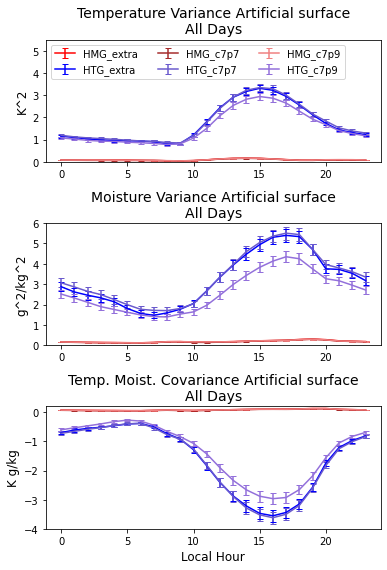

In [47]:
## Fig for manuscript 

varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),1, figsize=(6,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([5.5, 6.0,  0.2])
yMin = np.asarray([0.0, 0.0, -4.0])

iPlot=0
for iVar in range(len(varSel)):
    # Plot artificial surface moments
    axs[iPlot+0].errorbar(hourlyMean_HMGart.hour.values, np.squeeze(hourlyMean_HMGart[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_HMGart[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HMGart['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG_extra')
    axs[iPlot+0].errorbar(hourlyMean_HTGart.hour.values, np.squeeze(hourlyMean_HTGart[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_HTGart[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTGart['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG_extra')
    
    ## C7 Experiments
    axs[iPlot+0].errorbar(hourlyMean_HMGartc7p7.hour.values, np.squeeze(hourlyMean_HMGartc7p7[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_HMGartc7p7[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HMGartc7p7['SampleCount'].values),
                          fmt='-',color='brown', capsize=3, label='HMG_c7p7')
    axs[iPlot+0].errorbar(hourlyMean_HTGartc7p7.hour.values, np.squeeze(hourlyMean_HTGartc7p7[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_HTGartc7p7[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTGartc7p7['SampleCount'].values),
                          fmt='-',color='slateblue', capsize=3, label='HTG_c7p7')
    
    axs[iPlot+0].errorbar(hourlyMean_HMGartc7p9.hour.values, np.squeeze(hourlyMean_HMGartc7p9[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_HMGartc7p9[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HMGartc7p9['SampleCount'].values),
                          fmt='-',color='lightcoral', capsize=3, label='HMG_c7p9')
    axs[iPlot+0].errorbar(hourlyMean_HTGartc7p9.hour.values, np.squeeze(hourlyMean_HTGartc7p9[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_HTGartc7p9[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTGartc7p9['SampleCount'].values),
                          fmt='-',color='mediumpurple', capsize=3, label='HTG_c7p9')

    
        
    axs[iPlot+0].set_title(HMGcamDS_localReal[varSel[iVar]].long_name+' Artificial surface\nAll Days', fontsize=14)
    
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',ncol=3,fontsize=10)
    
    
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_localReal['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_localReal[varSel[iVar]].units, fontsize=12)
    
 
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])

    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+1




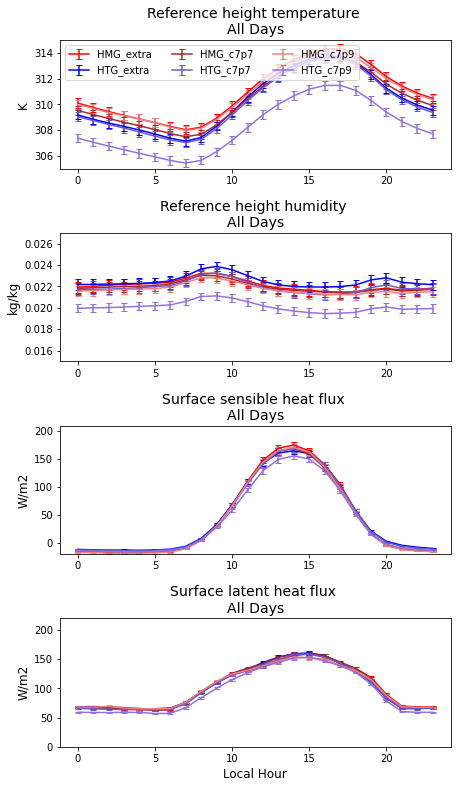

In [51]:
## Fig for manuscript

varSel = np.asarray(['TREFHT','QREFHT','SHFLX','LHFLX'])

fig,axs = plt.subplots(len(varSel),1, figsize=(7,13))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([315, 0.027,  210, 220])
yMin = np.asarray([305, 0.015,  -20,   0])

iPlot=0
for iVar in range(len(varSel)):
    # Plot artificial surface moments
    axs[iPlot+0].errorbar(hourlyMean_HMGart.hour.values, np.squeeze(hourlyMean_HMGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HMGart[varSel[iVar]].values)/np.sqrt(hourlyMean_HMGart['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG_extra')
    axs[iPlot+0].errorbar(hourlyMean_HTGart.hour.values, np.squeeze(hourlyMean_HTGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HTGart[varSel[iVar]].values)/np.sqrt(hourlyMean_HTGart['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG_extra')
    

#     axs[iPlot+0].errorbar(hourlyMean_HTGart5.hour.values, np.squeeze(hourlyMean_HTGart5[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_HTGart5[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTGart5['SampleCount'].values),
#                           fmt='-',color='dodgerblue', capsize=3, label='HTG_extra*0.5')
    
#     axs[iPlot+0].errorbar(hourlyMean_HTGart25.hour.values, np.squeeze(hourlyMean_HTGart25[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_HTGart25[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTGart25['SampleCount'].values),
#                           fmt='-',color='skyblue', capsize=3, label='HTG_extra*0.25')

    ## C7 Experiments
    axs[iPlot+0].errorbar(hourlyMean_HMGartc7p7.hour.values, np.squeeze(hourlyMean_HMGartc7p7[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HMGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_HMGartc7p7['SampleCount'].values),
                          fmt='-',color='brown', capsize=3, label='HMG_c7p7')
    axs[iPlot+0].errorbar(hourlyMean_HTGartc7p7.hour.values, np.squeeze(hourlyMean_HTGartc7p7[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HTGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_HTGartc7p7['SampleCount'].values),
                          fmt='-',color='slateblue', capsize=3, label='HTG_c7p7')
    
    axs[iPlot+0].errorbar(hourlyMean_HMGartc7p9.hour.values, np.squeeze(hourlyMean_HMGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HMGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_HMGartc7p9['SampleCount'].values),
                          fmt='-',color='lightcoral', capsize=3, label='HMG_c7p9')
    axs[iPlot+0].errorbar(hourlyMean_HTGartc7p9.hour.values, np.squeeze(hourlyMean_HTGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HTGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_HTGartc7p9['SampleCount'].values),
                          fmt='-',color='mediumpurple', capsize=3, label='HTG_c7p9')

    
        
    axs[iPlot+0].set_title(HMGcamDS_localReal[varSel[iVar]].long_name+' \nAll Days', fontsize=14)
    
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',ncol=3,fontsize=10)
    
    
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_localReal['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_localReal[varSel[iVar]].units, fontsize=12)
    
 
 #     # Plot real surface moments
#     axs[iPlot+1].errorbar(hourlyMean_HMGreal.hour.values, np.squeeze(hourlyMean_HMGreal[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_HMGreal[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HMGreal['SampleCount'].values),
#                           fmt='-',color='orange', capsize=3, label='HMG_real')
#     axs[iPlot+1].errorbar(hourlyMean_HTGreal.hour.values, np.squeeze(hourlyMean_HTGreal[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_HTGreal[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTGreal['SampleCount'].values),
#                           fmt='-',color='violet', capsize=3, label='HTG_real')
    

#     axs[iPlot+1].errorbar(hourlyMean_HTGreal10.hour.values, np.squeeze(hourlyMean_HTGreal10[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_HTGreal10[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTGreal10['SampleCount'].values),
#                           fmt='-',color='purple', capsize=3, label='HTG_real*10')

    
#     axs[iPlot+1].set_title('Realistic surface\nAll days', fontsize=14)  
#     if iVar==0:
#         axs[iPlot+1].legend(loc='upper left',ncol=1,fontsize=10)
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
#     axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
#         axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+1




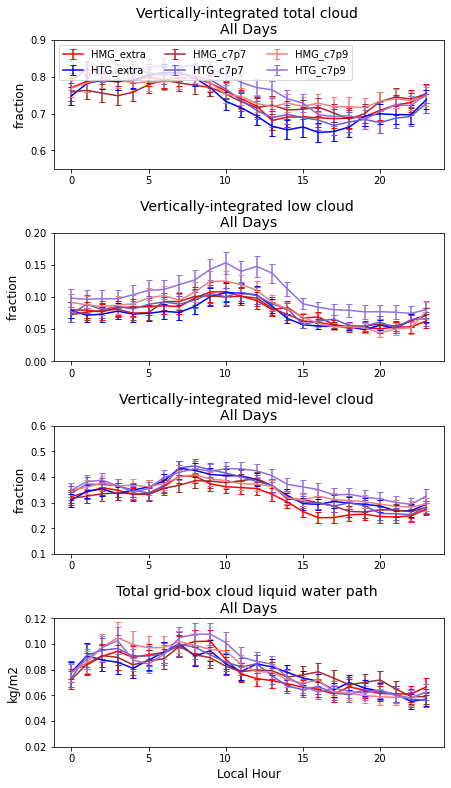

In [52]:
## Fig for manuscript
varSel = np.asarray(['CLDTOT','CLDLOW','CLDMED','TGCLDLWP'])

fig,axs = plt.subplots(len(varSel),1, figsize=(7,13))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([0.9, 0.2, 0.6, 0.12])
yMin = np.asarray([0.55,  0, 0.1, 0.02])

iPlot=0
for iVar in range(len(varSel)):
    # Plot artificial surface moments
    axs[iPlot+0].errorbar(hourlyMean_HMGart.hour.values, np.squeeze(hourlyMean_HMGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HMGart[varSel[iVar]].values)/np.sqrt(hourlyMean_HMGart['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG_extra')
    axs[iPlot+0].errorbar(hourlyMean_HTGart.hour.values, np.squeeze(hourlyMean_HTGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HTGart[varSel[iVar]].values)/np.sqrt(hourlyMean_HTGart['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG_extra')
    

#     axs[iPlot+0].errorbar(hourlyMean_HTGart5.hour.values, np.squeeze(hourlyMean_HTGart5[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_HTGart5[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTGart5['SampleCount'].values),
#                           fmt='-',color='dodgerblue', capsize=3, label='HTG_extra*0.5')
    
#     axs[iPlot+0].errorbar(hourlyMean_HTGart25.hour.values, np.squeeze(hourlyMean_HTGart25[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_HTGart25[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTGart25['SampleCount'].values),
#                           fmt='-',color='skyblue', capsize=3, label='HTG_extra*0.25')

    ## C7 Experiments
    axs[iPlot+0].errorbar(hourlyMean_HMGartc7p7.hour.values, np.squeeze(hourlyMean_HMGartc7p7[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HMGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_HMGartc7p7['SampleCount'].values),
                          fmt='-',color='brown', capsize=3, label='HMG_c7p7')
    axs[iPlot+0].errorbar(hourlyMean_HTGartc7p7.hour.values, np.squeeze(hourlyMean_HTGartc7p7[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HTGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_HTGartc7p7['SampleCount'].values),
                          fmt='-',color='slateblue', capsize=3, label='HTG_c7p7')
    
    axs[iPlot+0].errorbar(hourlyMean_HMGartc7p9.hour.values, np.squeeze(hourlyMean_HMGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HMGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_HMGartc7p9['SampleCount'].values),
                          fmt='-',color='lightcoral', capsize=3, label='HMG_c7p9')
    axs[iPlot+0].errorbar(hourlyMean_HTGartc7p9.hour.values, np.squeeze(hourlyMean_HTGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_HTGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_HTGartc7p9['SampleCount'].values),
                          fmt='-',color='mediumpurple', capsize=3, label='HTG_c7p9')

    
        
    axs[iPlot+0].set_title(HMGcamDS_localReal[varSel[iVar]].long_name+' \nAll Days', fontsize=14)
    
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',ncol=3,fontsize=10)
    
    
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_localReal['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_localReal[varSel[iVar]].units, fontsize=12)
    
 
 #     # Plot real surface moments
#     axs[iPlot+1].errorbar(hourlyMean_HMGreal.hour.values, np.squeeze(hourlyMean_HMGreal[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_HMGreal[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HMGreal['SampleCount'].values),
#                           fmt='-',color='orange', capsize=3, label='HMG_real')
#     axs[iPlot+1].errorbar(hourlyMean_HTGreal.hour.values, np.squeeze(hourlyMean_HTGreal[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_HTGreal[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTGreal['SampleCount'].values),
#                           fmt='-',color='violet', capsize=3, label='HTG_real')
    

#     axs[iPlot+1].errorbar(hourlyMean_HTGreal10.hour.values, np.squeeze(hourlyMean_HTGreal10[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_HTGreal10[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTGreal10['SampleCount'].values),
#                           fmt='-',color='purple', capsize=3, label='HTG_real*10')

    
#     axs[iPlot+1].set_title('Realistic surface\nAll days', fontsize=14)  
#     if iVar==0:
#         axs[iPlot+1].legend(loc='upper left',ncol=1,fontsize=10)
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
#     axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
#         axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+1




## Get daily means and identify wet/dry days

In [26]:
## Get daily means over surfaces 
HMGcamDS_localReal_dailyMean   = HMGcamDS_localReal.groupby('year_month_day').mean()
HTGcamDS_localReal_dailyMean   = HTGcamDS_localReal.groupby('year_month_day').mean()
HTGcamDS_localReal10_dailyMean = HTGcamDS_localReal10.groupby('year_month_day').mean()

HMGclmDS_localReal_dailyMean   = HMGclmDS_localReal.groupby('year_month_day').mean()
HTGclmDS_localReal_dailyMean   = HTGclmDS_localReal.groupby('year_month_day').mean()
HTGclmDS_localReal10_dailyMean = HTGclmDS_localReal10.groupby('year_month_day').mean()
print('Daily means over real surfaces calculated')



HMGcamDS_localArt_dailyMean = HMGcamDS_localArt.groupby('year_month_day').mean()
HTGcamDS_localArt_dailyMean = HTGcamDS_localArt.groupby('year_month_day').mean()

HMGclmDS_localArt_dailyMean = HMGclmDS_localArt.groupby('year_month_day').mean()
HTGclmDS_localArt_dailyMean = HTGclmDS_localArt.groupby('year_month_day').mean()
print('Daily means over artificial (x1) surfaces calculated')

HMGcamDS_localArtc7p9_dailyMean = HMGcamDS_localArtc7p9.groupby('year_month_day').mean()
HTGcamDS_localArtc7p9_dailyMean = HTGcamDS_localArtc7p9.groupby('year_month_day').mean()
print('Daily means over artificial (c7p9) surfaces calculated')

HMGcamDS_localArtc7p7_dailyMean = HMGcamDS_localArtc7p7.groupby('year_month_day').mean()
HTGcamDS_localArtc7p7_dailyMean = HTGcamDS_localArtc7p7.groupby('year_month_day').mean()
print('Daily means over artificial (c7p7) surfaces calculated')


Daily means over real surfaces calculated
Daily means over artificial (x1) surfaces calculated
Daily means over artificial (c7p9) surfaces calculated
Daily means over artificial (c7p7) surfaces calculated


In [27]:
## Get daily (summed) precipitation 

# Now that it's a 5 minute timestep means...
HMGcamDS_localReal['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_localReal.PRECT.values*300.0*1000.0)
HTGcamDS_localReal['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_localReal.PRECT.values*300.0*1000.0)
HTGcamDS_localReal10['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_localReal10.PRECT.values*300.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySumReal = HMGcamDS_localReal.groupby('year_month_day').sum()
HTGcamDS_localDailySumReal = HTGcamDS_localReal.groupby('year_month_day').sum()
HTGcamDS_localDailySumReal10 = HTGcamDS_localReal10.groupby('year_month_day').sum()
# Add to daily mean arrays above
HMGcamDS_localReal_dailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySumReal['PRECT_mmPerDT'].values)
HTGcamDS_localReal_dailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySumReal['PRECT_mmPerDT'].values)
HTGcamDS_localReal10_dailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySumReal10['PRECT_mmPerDT'].values)

## Artificial surface 

# Now that it's a 5 minute timestep means...
HMGcamDS_localArt['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_localArt.PRECT.values*300.0*1000.0)
HTGcamDS_localArt['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_localArt.PRECT.values*300.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySumArt = HMGcamDS_localArt.groupby('year_month_day').sum()
HTGcamDS_localDailySumArt = HTGcamDS_localArt.groupby('year_month_day').sum()
# Add to daily mean arrays above
HMGcamDS_localArt_dailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySumArt['PRECT_mmPerDT'].values)
HTGcamDS_localArt_dailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySumArt['PRECT_mmPerDT'].values)


# C7 Experiments 
HMGcamDS_localArtc7p9['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_localArtc7p9.PRECT.values*300.0*1000.0)
HTGcamDS_localArtc7p9['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_localArtc7p9.PRECT.values*300.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySumArtc7p9 = HMGcamDS_localArtc7p9.groupby('year_month_day').sum()
HTGcamDS_localDailySumArtc7p9 = HTGcamDS_localArtc7p9.groupby('year_month_day').sum()
# Add to daily mean arrays above
HMGcamDS_localArtc7p9_dailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySumArtc7p9['PRECT_mmPerDT'].values)
HTGcamDS_localArtc7p9_dailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySumArtc7p9['PRECT_mmPerDT'].values)


HMGcamDS_localArtc7p7['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_localArtc7p7.PRECT.values*300.0*1000.0)
HTGcamDS_localArtc7p7['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_localArtc7p7.PRECT.values*300.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySumArtc7p7 = HMGcamDS_localArtc7p7.groupby('year_month_day').sum()
HTGcamDS_localDailySumArtc7p7 = HTGcamDS_localArtc7p7.groupby('year_month_day').sum()
# Add to daily mean arrays above
HMGcamDS_localArtc7p7_dailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySumArtc7p7['PRECT_mmPerDT'].values)
HTGcamDS_localArtc7p7_dailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySumArtc7p7['PRECT_mmPerDT'].values)




In [28]:
# Define classification by day... 

# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1

## Now get arrays with each day classified as one of four conditions based on wet/dry day preceded by a wet/dry day
classArr_HTGreal = classifyPrectDays_SCAM(HTGcamDS_localDailySumReal.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySumReal.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HMGreal = classifyPrectDays_SCAM(HMGcamDS_localDailySumReal.year_month_day.values, # Time array 
                                      HMGcamDS_localDailySumReal.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HTGreal10 = classifyPrectDays_SCAM(HTGcamDS_localDailySumReal10.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySumReal10.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 




classArr_HTGart = classifyPrectDays_SCAM(HTGcamDS_localDailySumArt.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySumArt.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HMGart = classifyPrectDays_SCAM(HMGcamDS_localDailySumArt.year_month_day.values, # Time array 
                                      HMGcamDS_localDailySumArt.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 


## C7 Experiments 
classArr_HTGartc7p9 = classifyPrectDays_SCAM(HTGcamDS_localDailySumArtc7p9.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySumArtc7p9.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HMGartc7p9  = classifyPrectDays_SCAM(HMGcamDS_localDailySumArtc7p9.year_month_day.values, # Time array 
                                      HMGcamDS_localDailySumArtc7p9.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 

classArr_HTGartc7p7 = classifyPrectDays_SCAM(HTGcamDS_localDailySumArtc7p7.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySumArtc7p7.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HMGartc7p7  = classifyPrectDays_SCAM(HMGcamDS_localDailySumArtc7p7.year_month_day.values, # Time array 
                                      HMGcamDS_localDailySumArtc7p7.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 




## Add that classification to larger datasets
HTGcamDS_localDailySumReal['dayClass'] = (('year_month_day'), classArr_HTGreal)
HMGcamDS_localDailySumReal['dayClass'] = (('year_month_day'), classArr_HMGreal)
HTGcamDS_localDailySumReal10['dayClass'] = (('year_month_day'), classArr_HTGreal10)

HTGcamDS_localDailySumArt['dayClass']  = (('year_month_day'), classArr_HTGart)
HMGcamDS_localDailySumArt['dayClass']  = (('year_month_day'), classArr_HMGart)

HTGcamDS_localDailySumArtc7p9['dayClass']  = (('year_month_day'), classArr_HTGartc7p9)
HMGcamDS_localDailySumArtc7p9['dayClass']  = (('year_month_day'), classArr_HMGartc7p9)

HTGcamDS_localDailySumArtc7p7['dayClass']  = (('year_month_day'), classArr_HTGartc7p7)
HMGcamDS_localDailySumArtc7p7['dayClass']  = (('year_month_day'), classArr_HMGartc7p7)



## Find date indices based on each classification:
idDry_HTGreal = np.where(HTGcamDS_localDailySumReal['dayClass'].values=='dDry')[0]
iwWet_HTGreal = np.where(HTGcamDS_localDailySumReal['dayClass'].values=='wWet')[0]

idDry_HMGreal = np.where(HMGcamDS_localDailySumReal['dayClass'].values=='dDry')[0]
iwWet_HMGreal = np.where(HMGcamDS_localDailySumReal['dayClass'].values=='wWet')[0]

idDry_HTGreal10 = np.where(HTGcamDS_localDailySumReal10['dayClass'].values=='dDry')[0]
iwWet_HTGreal10 = np.where(HTGcamDS_localDailySumReal10['dayClass'].values=='wWet')[0]



idDry_HTGart = np.where(HTGcamDS_localDailySumArt['dayClass'].values=='dDry')[0]
iwWet_HTGart = np.where(HTGcamDS_localDailySumArt['dayClass'].values=='wWet')[0]

idDry_HMGart = np.where(HMGcamDS_localDailySumArt['dayClass'].values=='dDry')[0]
iwWet_HMGart = np.where(HMGcamDS_localDailySumArt['dayClass'].values=='wWet')[0]




idDry_HTGartc7p9 = np.where(HTGcamDS_localDailySumArtc7p9['dayClass'].values=='dDry')[0]
iwWet_HTGartc7p9 = np.where(HTGcamDS_localDailySumArtc7p9['dayClass'].values=='wWet')[0]

idDry_HMGartc7p9 = np.where(HMGcamDS_localDailySumArtc7p9['dayClass'].values=='dDry')[0]
iwWet_HMGartc7p9 = np.where(HMGcamDS_localDailySumArtc7p9['dayClass'].values=='wWet')[0]

idDry_HTGartc7p7 = np.where(HTGcamDS_localDailySumArtc7p7['dayClass'].values=='dDry')[0]
iwWet_HTGartc7p7 = np.where(HTGcamDS_localDailySumArtc7p7['dayClass'].values=='wWet')[0]

idDry_HMGartc7p7 = np.where(HMGcamDS_localDailySumArtc7p7['dayClass'].values=='dDry')[0]
iwWet_HMGartc7p7 = np.where(HMGcamDS_localDailySumArtc7p7['dayClass'].values=='wWet')[0]



## Keep only days that agree on classification between all cases, HMG and HTG
setHMG_dDryReal = set(idDry_HMGreal)
setHTG_dDryReal = set(idDry_HTGreal)
setHTG_dDryReal10 = set(idDry_HTGreal10)

setHMG_dDryArt = set(idDry_HMGart)
setHTG_dDryArt = set(idDry_HTGart)

setHMG_dDryArtc7p9 = set(idDry_HMGartc7p9)
setHTG_dDryArtc7p9 = set(idDry_HTGartc7p9)

setHMG_dDryArtc7p7 = set(idDry_HMGartc7p7)
setHTG_dDryArtc7p7 = set(idDry_HTGartc7p7)


iKeep_dDry  = list(setHMG_dDryReal & setHTG_dDryReal & setHTG_dDryReal10 &
                   setHMG_dDryArt  & setHTG_dDryArt  &
                   setHMG_dDryArtc7p9  & setHTG_dDryArtc7p9  &
                   setHMG_dDryArtc7p7  & setHTG_dDryArtc7p7)

HMG_dDryReal    = HMGcamDS_localDailySumReal.isel(year_month_day  = iKeep_dDry)
HTG_dDryReal    = HTGcamDS_localDailySumReal.isel(year_month_day  = iKeep_dDry)
HTG_dDryReal10  = HTGcamDS_localDailySumReal10.isel(year_month_day  = iKeep_dDry)

HMG_dDryArt     = HMGcamDS_localDailySumArt.isel(year_month_day   = iKeep_dDry)
HTG_dDryArt     = HTGcamDS_localDailySumArt.isel(year_month_day   = iKeep_dDry)

HMG_dDryArtc7p9     = HMGcamDS_localDailySumArtc7p9.isel(year_month_day   = iKeep_dDry)
HTG_dDryArtc7p9     = HTGcamDS_localDailySumArtc7p9.isel(year_month_day   = iKeep_dDry)

HMG_dDryArtc7p7     = HMGcamDS_localDailySumArtc7p7.isel(year_month_day   = iKeep_dDry)
HTG_dDryArtc7p7     = HTGcamDS_localDailySumArtc7p7.isel(year_month_day   = iKeep_dDry)


setHMG_wWetReal = set(iwWet_HMGreal)
setHTG_wWetReal = set(iwWet_HTGreal)
setHTG_wWetReal10 = set(iwWet_HTGreal10)

setHMG_wWetArt = set(iwWet_HMGart)
setHTG_wWetArt = set(iwWet_HTGart)

setHMG_wWetArtc7p9 = set(iwWet_HMGartc7p9)
setHTG_wWetArtc7p9 = set(iwWet_HTGartc7p9)

setHMG_wWetArtc7p7 = set(iwWet_HMGartc7p7)
setHTG_wWetArtc7p7 = set(iwWet_HTGartc7p7)


iKeep_wWet  = list(setHMG_wWetReal & setHTG_wWetReal & setHTG_wWetReal10 &
                   setHMG_wWetArt  & setHTG_wWetArt  &
                   setHMG_wWetArtc7p9  & setHTG_wWetArtc7p9  &
                   setHMG_wWetArtc7p7  & setHTG_wWetArtc7p7) 

HMG_wWetReal    = HMGcamDS_localDailySumReal.isel(year_month_day = iKeep_wWet)
HTG_wWetReal    = HTGcamDS_localDailySumReal.isel(year_month_day = iKeep_wWet)
HTG_wWetReal10  = HTGcamDS_localDailySumReal10.isel(year_month_day = iKeep_wWet)

HMG_wWetArt     = HMGcamDS_localDailySumArt.isel(year_month_day = iKeep_wWet)
HTG_wWetArt     = HTGcamDS_localDailySumArt.isel(year_month_day = iKeep_wWet)

HMG_wWetArtc7p9     = HMGcamDS_localDailySumArtc7p9.isel(year_month_day = iKeep_wWet)
HTG_wWetArtc7p9     = HTGcamDS_localDailySumArtc7p9.isel(year_month_day = iKeep_wWet)

HMG_wWetArtc7p7     = HMGcamDS_localDailySumArtc7p7.isel(year_month_day = iKeep_wWet)
HTG_wWetArtc7p7     = HTGcamDS_localDailySumArtc7p7.isel(year_month_day = iKeep_wWet)



In [29]:
print('   Number of days in each category   ')
print('         HMG              HTG   ')
print('dDry: %6i %16i' % (len(HMG_dDryReal.year_month_day.values), len(HTG_dDryReal.year_month_day.values)) )
print('wWet: %6i %16i' % (len(HMG_wWetReal.year_month_day.values), len(HTG_wWetReal.year_month_day.values)) )



   Number of days in each category   
         HMG              HTG   
dDry:     28               28
wWet:     24               24


In [30]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDays_HTGreal = getTimes_basedOnDayClass(HTGcamDS_localReal, HTG_dDryReal)
wWetDays_HTGreal = getTimes_basedOnDayClass(HTGcamDS_localReal, HTG_wWetReal)

dDryDays_HMGreal = getTimes_basedOnDayClass(HMGcamDS_localReal, HMG_dDryReal)
wWetDays_HMGreal = getTimes_basedOnDayClass(HMGcamDS_localReal, HMG_wWetReal)

dDryDays_HTGreal10 = getTimes_basedOnDayClass(HTGcamDS_localReal10, HTG_dDryReal10)
wWetDays_HTGreal10 = getTimes_basedOnDayClass(HTGcamDS_localReal10, HTG_wWetReal10)



dDryDays_HTGart = getTimes_basedOnDayClass(HTGcamDS_localArt, HTG_dDryArt)
wWetDays_HTGart = getTimes_basedOnDayClass(HTGcamDS_localArt, HTG_wWetArt)

dDryDays_HMGart = getTimes_basedOnDayClass(HMGcamDS_localArt, HMG_dDryArt)
wWetDays_HMGart = getTimes_basedOnDayClass(HMGcamDS_localArt, HMG_wWetArt)



In [31]:
## C7 
dDryDays_HTGartc7p9 = getTimes_basedOnDayClass(HTGcamDS_localArtc7p9, HTG_dDryArtc7p9)
wWetDays_HTGartc7p9 = getTimes_basedOnDayClass(HTGcamDS_localArtc7p9, HTG_wWetArtc7p9)

dDryDays_HMGartc7p9 = getTimes_basedOnDayClass(HMGcamDS_localArtc7p9, HMG_dDryArtc7p9)
wWetDays_HMGartc7p9 = getTimes_basedOnDayClass(HMGcamDS_localArtc7p9, HMG_wWetArtc7p9)

dDryDays_HTGartc7p7 = getTimes_basedOnDayClass(HTGcamDS_localArtc7p7, HTG_dDryArtc7p7)
wWetDays_HTGartc7p7 = getTimes_basedOnDayClass(HTGcamDS_localArtc7p7, HTG_wWetArtc7p7)

dDryDays_HMGartc7p7 = getTimes_basedOnDayClass(HMGcamDS_localArtc7p7, HMG_dDryArtc7p7)
wWetDays_HMGartc7p7 = getTimes_basedOnDayClass(HMGcamDS_localArtc7p7, HMG_wWetArtc7p7)



In [32]:
## Get the times for CLM datasets as well
dDryDaysCLM_HTGreal = getTimes_basedOnDayClass(HTGclmDS_localReal, HTG_dDryReal)
wWetDaysCLM_HTGreal = getTimes_basedOnDayClass(HTGclmDS_localReal, HTG_wWetReal)

dDryDaysCLM_HMGreal = getTimes_basedOnDayClass(HMGclmDS_localReal, HMG_dDryReal)
wWetDaysCLM_HMGreal = getTimes_basedOnDayClass(HMGclmDS_localReal, HMG_wWetReal)

dDryDaysCLM_HTGreal10 = getTimes_basedOnDayClass(HTGclmDS_localReal10, HTG_dDryReal10)
wWetDaysCLM_HTGreal10 = getTimes_basedOnDayClass(HTGclmDS_localReal10, HTG_wWetReal10)

# And patch level: 
dDryDaysPatch_HTGreal = getTimes_basedOnDayClass(HTGclmDS_localRealPatch, HTG_dDryReal)
wWetDaysPatch_HTGreal = getTimes_basedOnDayClass(HTGclmDS_localRealPatch, HTG_wWetReal)

dDryDaysPatch_HMGreal = getTimes_basedOnDayClass(HMGclmDS_localRealPatch, HMG_dDryReal)
wWetDaysPatch_HMGreal = getTimes_basedOnDayClass(HMGclmDS_localRealPatch, HMG_wWetReal)

dDryDaysPatch_HTGreal10 = getTimes_basedOnDayClass(HTGclmDS_localRealPatch10, HTG_dDryReal10)
wWetDaysPatch_HTGreal10 = getTimes_basedOnDayClass(HTGclmDS_localRealPatch10, HTG_wWetReal10)


In [33]:
## Add wind speed to underlying DS

windSpeed_dDryDays_HMGreal = np.sqrt((dDryDays_HMGreal.U.values**2.0) + (dDryDays_HMGreal.V.values**2.0))
windSpeed_dDryDays_HTGreal = np.sqrt((dDryDays_HTGreal.U.values**2.0) + (dDryDays_HTGreal.V.values**2.0))
windSpeed_dDryDays_HTGreal10 = np.sqrt((dDryDays_HTGreal10.U.values**2.0) + (dDryDays_HTGreal10.V.values**2.0))

windSpeed_wWetDays_HMGreal = np.sqrt((wWetDays_HMGreal.U.values**2.0) + (wWetDays_HMGreal.V.values**2.0))
windSpeed_wWetDays_HTGreal = np.sqrt((wWetDays_HTGreal.U.values**2.0) + (wWetDays_HTGreal.V.values**2.0))
windSpeed_wWetDays_HTGreal10 = np.sqrt((wWetDays_HTGreal10.U.values**2.0) + (wWetDays_HTGreal10.V.values**2.0))

windSpeed_dDryDays_HMGart = np.sqrt((dDryDays_HMGart.U.values**2.0) + (dDryDays_HMGart.V.values**2.0))
windSpeed_dDryDays_HTGart = np.sqrt((dDryDays_HTGart.U.values**2.0) + (dDryDays_HTGart.V.values**2.0))

windSpeed_wWetDays_HMGart = np.sqrt((wWetDays_HMGart.U.values**2.0) + (wWetDays_HMGart.V.values**2.0))
windSpeed_wWetDays_HTGart = np.sqrt((wWetDays_HTGart.U.values**2.0) + (wWetDays_HTGart.V.values**2.0))

## C7 
windSpeed_dDryDays_HMGartc7p9 = np.sqrt((dDryDays_HMGartc7p9.U.values**2.0) + (dDryDays_HMGartc7p9.V.values**2.0))
windSpeed_dDryDays_HTGartc7p9 = np.sqrt((dDryDays_HTGartc7p9.U.values**2.0) + (dDryDays_HTGartc7p9.V.values**2.0))

windSpeed_wWetDays_HMGartc7p9 = np.sqrt((wWetDays_HMGartc7p9.U.values**2.0) + (wWetDays_HMGartc7p9.V.values**2.0))
windSpeed_wWetDays_HTGartc7p9 = np.sqrt((wWetDays_HTGartc7p9.U.values**2.0) + (wWetDays_HTGartc7p9.V.values**2.0))

windSpeed_dDryDays_HMGartc7p7 = np.sqrt((dDryDays_HMGartc7p7.U.values**2.0) + (dDryDays_HMGartc7p7.V.values**2.0))
windSpeed_dDryDays_HTGartc7p7 = np.sqrt((dDryDays_HTGartc7p7.U.values**2.0) + (dDryDays_HTGartc7p7.V.values**2.0))

windSpeed_wWetDays_HMGartc7p7 = np.sqrt((wWetDays_HMGartc7p7.U.values**2.0) + (wWetDays_HMGartc7p7.V.values**2.0))
windSpeed_wWetDays_HTGartc7p7 = np.sqrt((wWetDays_HTGartc7p7.U.values**2.0) + (wWetDays_HTGartc7p7.V.values**2.0))


dDryDays_HMGreal['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HMGreal))
dDryDays_HTGreal['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HTGreal))
dDryDays_HTGreal10['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HTGreal10))

wWetDays_HMGreal['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HMGreal))
wWetDays_HTGreal['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HTGreal))
wWetDays_HTGreal10['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HTGreal10))


dDryDays_HMGart['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HMGart))
dDryDays_HTGart['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HTGart))

wWetDays_HMGart['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HMGart))
wWetDays_HTGart['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HTGart))



## C7
dDryDays_HMGartc7p9['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HMGartc7p9))
dDryDays_HTGartc7p9['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HTGartc7p9))

wWetDays_HMGartc7p9['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HMGartc7p9))
wWetDays_HTGartc7p9['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HTGartc7p9))


dDryDays_HMGartc7p7['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HMGartc7p7))
dDryDays_HTGartc7p7['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HTGartc7p7))

wWetDays_HMGartc7p7['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HMGartc7p7))
wWetDays_HTGartc7p7['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HTGartc7p7))


In [34]:

# Get means a function of hour of day within each dry/wet day category
hourlyMean_dDry_HMGreal = dDryDays_HMGreal.groupby("time.hour").mean()
hourlyMean_dDry_HTGreal = dDryDays_HTGreal.groupby("time.hour").mean()
hourlyMean_dDry_HTGreal10 = dDryDays_HTGreal10.groupby("time.hour").mean()

hourlyMean_wWet_HMGreal = wWetDays_HMGreal.groupby("time.hour").mean()
hourlyMean_wWet_HTGreal = wWetDays_HTGreal.groupby("time.hour").mean()
hourlyMean_wWet_HTGreal10 = wWetDays_HTGreal10.groupby("time.hour").mean()


hourlyMean_dDry_HMGart = dDryDays_HMGart.groupby("time.hour").mean()
hourlyMean_dDry_HTGart = dDryDays_HTGart.groupby("time.hour").mean()

hourlyMean_wWet_HMGart = wWetDays_HMGart.groupby("time.hour").mean()
hourlyMean_wWet_HTGart = wWetDays_HTGart.groupby("time.hour").mean()


# Get std as function of hour of day too
hourlyStd_dDry_HMGreal = dDryDays_HMGreal.groupby("time.hour").std(dim='time')
hourlyStd_dDry_HTGreal = dDryDays_HTGreal.groupby("time.hour").std(dim='time')
hourlyStd_dDry_HTGreal10 = dDryDays_HTGreal10.groupby("time.hour").std(dim='time')

hourlyStd_wWet_HMGreal = wWetDays_HMGreal.groupby("time.hour").std(dim='time')
hourlyStd_wWet_HTGreal = wWetDays_HTGreal.groupby("time.hour").std(dim='time')
hourlyStd_wWet_HTGreal10 = wWetDays_HTGreal10.groupby("time.hour").std(dim='time')



hourlyStd_dDry_HMGart = dDryDays_HMGart.groupby("time.hour").std(dim='time')
hourlyStd_dDry_HTGart = dDryDays_HTGart.groupby("time.hour").std(dim='time')

hourlyStd_wWet_HMGart = wWetDays_HMGart.groupby("time.hour").std(dim='time')
hourlyStd_wWet_HTGart = wWetDays_HTGart.groupby("time.hour").std(dim='time')



In [35]:
hourlyMean_dDry_HMGartc7p9 = dDryDays_HMGartc7p9.groupby("time.hour").mean()
hourlyMean_dDry_HTGartc7p9 = dDryDays_HTGartc7p9.groupby("time.hour").mean()

hourlyMean_wWet_HMGartc7p9 = wWetDays_HMGartc7p9.groupby("time.hour").mean()
hourlyMean_wWet_HTGartc7p9 = wWetDays_HTGartc7p9.groupby("time.hour").mean()

hourlyMean_dDry_HMGartc7p7 = dDryDays_HMGartc7p7.groupby("time.hour").mean()
hourlyMean_dDry_HTGartc7p7 = dDryDays_HTGartc7p7.groupby("time.hour").mean()

hourlyMean_wWet_HMGartc7p7 = wWetDays_HMGartc7p7.groupby("time.hour").mean()
hourlyMean_wWet_HTGartc7p7 = wWetDays_HTGartc7p7.groupby("time.hour").mean()


hourlyStd_dDry_HMGartc7p9 = dDryDays_HMGartc7p9.groupby("time.hour").std(dim='time')
hourlyStd_dDry_HTGartc7p9 = dDryDays_HTGartc7p9.groupby("time.hour").std(dim='time')

hourlyStd_wWet_HMGartc7p9 = wWetDays_HMGartc7p9.groupby("time.hour").std(dim='time')
hourlyStd_wWet_HTGartc7p9 = wWetDays_HTGartc7p9.groupby("time.hour").std(dim='time')

hourlyStd_dDry_HMGartc7p7 = dDryDays_HMGartc7p7.groupby("time.hour").std(dim='time')
hourlyStd_dDry_HTGartc7p7 = dDryDays_HTGartc7p7.groupby("time.hour").std(dim='time')

hourlyStd_wWet_HMGartc7p7 = wWetDays_HMGartc7p7.groupby("time.hour").std(dim='time')
hourlyStd_wWet_HTGartc7p7 = wWetDays_HTGartc7p7.groupby("time.hour").std(dim='time')



In [36]:
# Get number of obs going into those hourly means (for error bars)
nTimes_dDryReal   = np.full([24], np.nan)
nTimes_wWetReal   = np.full([24], np.nan)

nTimes_dDryReal10   = np.full([24], np.nan)
nTimes_wWetReal10   = np.full([24], np.nan)


nTimes_dDryArt    = np.full([24], np.nan)
nTimes_wWetArt    = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_dDryReal[iHr]  = len(np.where(dDryDays_HMGreal["time.hour"]==iHr)[0])
    nTimes_wWetReal[iHr]  = len(np.where(wWetDays_HMGreal["time.hour"]==iHr)[0])
    
    nTimes_dDryReal10[iHr]  = len(np.where(dDryDays_HTGreal10["time.hour"]==iHr)[0])
    nTimes_wWetReal10[iHr]  = len(np.where(wWetDays_HTGreal10["time.hour"]==iHr)[0])
    
    nTimes_dDryArt[iHr]   = len(np.where(dDryDays_HMGart["time.hour"]==iHr)[0])
    nTimes_wWetArt[iHr]   = len(np.where(wWetDays_HMGart["time.hour"]==iHr)[0])
    

    
    
hourlyMean_dDry_HMGreal['SampleCount']         = (('hour'), nTimes_dDryReal)
hourlyMean_dDry_HTGreal['SampleCount']         = (('hour'), nTimes_dDryReal)
hourlyMean_dDry_HTGreal10['SampleCount']         = (('hour'), nTimes_dDryReal10)

hourlyMean_wWet_HMGreal['SampleCount']         = (('hour'), nTimes_wWetReal)
hourlyMean_wWet_HTGreal['SampleCount']         = (('hour'), nTimes_wWetReal)
hourlyMean_wWet_HTGreal10['SampleCount']         = (('hour'), nTimes_wWetReal10)


hourlyMean_dDry_HMGart['SampleCount']          = (('hour'), nTimes_dDryArt)
hourlyMean_dDry_HTGart['SampleCount']          = (('hour'), nTimes_dDryArt)
 
hourlyMean_wWet_HMGart['SampleCount']          = (('hour'), nTimes_wWetArt)
hourlyMean_wWet_HTGart['SampleCount']          = (('hour'), nTimes_wWetArt)



## C7 
hourlyMean_dDry_HMGartc7p9['SampleCount']          = (('hour'), nTimes_dDryArt)
hourlyMean_dDry_HTGartc7p9['SampleCount']          = (('hour'), nTimes_dDryArt)
 
hourlyMean_wWet_HMGartc7p9['SampleCount']          = (('hour'), nTimes_wWetArt)
hourlyMean_wWet_HTGartc7p9['SampleCount']          = (('hour'), nTimes_wWetArt)


hourlyMean_dDry_HMGartc7p7['SampleCount']          = (('hour'), nTimes_dDryArt)
hourlyMean_dDry_HTGartc7p7['SampleCount']          = (('hour'), nTimes_dDryArt)
 
hourlyMean_wWet_HMGartc7p7['SampleCount']          = (('hour'), nTimes_wWetArt)
hourlyMean_wWet_HTGartc7p7['SampleCount']          = (('hour'), nTimes_wWetArt)



In [37]:
# Get means a function of hour of day for CLM variables too 
hourlyMeanCLM_dDry_HMGreal = dDryDaysCLM_HMGreal.groupby("time.hour").mean()
hourlyMeanCLM_dDry_HTGreal = dDryDaysCLM_HTGreal.groupby("time.hour").mean()

hourlyMeanCLM_wWet_HMGreal = wWetDaysCLM_HMGreal.groupby("time.hour").mean()
hourlyMeanCLM_wWet_HTGreal = wWetDaysCLM_HTGreal.groupby("time.hour").mean()


# And patch-specific variables 
hourlyMeanPatch_dDry_HMGreal = dDryDaysPatch_HMGreal.groupby("time.hour").mean()
hourlyMeanPatch_dDry_HTGreal = dDryDaysPatch_HTGreal.groupby("time.hour").mean()

hourlyMeanPatch_wWet_HMGreal = wWetDaysPatch_HMGreal.groupby("time.hour").mean()
hourlyMeanPatch_wWet_HTGreal = wWetDaysPatch_HTGreal.groupby("time.hour").mean()


In [38]:
# Get means a function of hour of day for CLM variables too 
hourlyMeanCLM_dDry_HTGreal10 = dDryDaysCLM_HTGreal10.groupby("time.hour").mean()
hourlyMeanCLM_wWet_HTGreal10 = wWetDaysCLM_HTGreal10.groupby("time.hour").mean()


# And patch-specific variables 
hourlyMeanPatch_dDry_HTGreal10 = dDryDaysPatch_HTGreal10.groupby("time.hour").mean()
hourlyMeanPatch_wWet_HTGreal10 = wWetDaysPatch_HTGreal10.groupby("time.hour").mean()


**Make some plots of diurnal cycles**

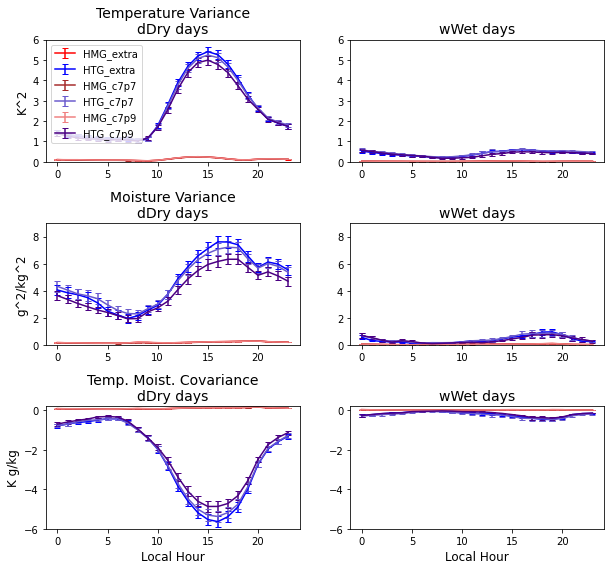

In [40]:
## Fig for manuscript 

varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([6.0, 9.0,  0.2])
yMin = np.asarray([0.0, 0.0, -6.0])

iPlot=0
for iVar in range(len(varSel)):
    # Plot artificial surface moments
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMGart.hour.values, np.squeeze(hourlyMean_dDry_HMGart[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMGart[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMGart['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG_extra')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTGart.hour.values, np.squeeze(hourlyMean_dDry_HTGart[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTGart[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTGart['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG_extra')
    

#     axs[iPlot+0].errorbar(hourlyMean_dDry_HTGart5.hour.values, np.squeeze(hourlyMean_dDry_HTGart5[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HTGart5[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTGart5['SampleCount'].values),
#                           fmt='-',color='dodgerblue', capsize=3, label='HTG_extra*0.5')
    
#     axs[iPlot+0].errorbar(hourlyMean_dDry_HTGart25.hour.values, np.squeeze(hourlyMean_dDry_HTGart25[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HTGart25[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTGart25['SampleCount'].values),
#                           fmt='-',color='skyblue', capsize=3, label='HTG_extra*0.25')

    #C7 
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMGartc7p7.hour.values, np.squeeze(hourlyMean_dDry_HMGartc7p7[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMGartc7p7[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMGartc7p7['SampleCount'].values),
                          fmt='-',color='brown', capsize=3, label='HMG_c7p7')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTGartc7p7.hour.values, np.squeeze(hourlyMean_dDry_HTGartc7p7[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTGartc7p7[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTGartc7p7['SampleCount'].values),
                          fmt='-',color='slateblue', capsize=3, label='HTG_c7p7')

    
    
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMGartc7p9.hour.values, np.squeeze(hourlyMean_dDry_HMGartc7p9[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMGartc7p9[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMGartc7p9['SampleCount'].values),
                          fmt='-',color='lightcoral', capsize=3, label='HMG_c7p9')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTGartc7p9.hour.values, np.squeeze(hourlyMean_dDry_HTGartc7p9[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTGartc7p9[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTGartc7p9['SampleCount'].values),
                          fmt='-',color='indigo', capsize=3, label='HTG_c7p9')
    


        
    axs[iPlot+0].set_title(HMGcamDS_localReal[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=10)
    
    
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_localReal['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_localReal[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMGart.hour.values, np.squeeze(hourlyMean_wWet_HMGart[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMGart[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMGart['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG_extra')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTGart.hour.values, np.squeeze(hourlyMean_wWet_HTGart[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTGart[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTGart['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG_extra')
    
#     axs[iPlot+1].errorbar(hourlyMean_wWet_HTGart5.hour.values, np.squeeze(hourlyMean_wWet_HTGart5[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_wWet_HTGart5[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTGart5['SampleCount'].values),
#                           fmt='-',color='dodgerblue', capsize=3, label='HTG_extra*0.5')
    
#     axs[iPlot+1].errorbar(hourlyMean_wWet_HTGart25.hour.values, np.squeeze(hourlyMean_wWet_HTGart25[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_wWet_HTGart25[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTGart25['SampleCount'].values),
#                           fmt='-',color='skyblue', capsize=3, label='HTG_extra*0.25')
    
     #C7 
    axs[iPlot+1].errorbar(hourlyMean_wWet_HMGartc7p7.hour.values, np.squeeze(hourlyMean_wWet_HMGartc7p7[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMGartc7p7[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMGartc7p7['SampleCount'].values),
                          fmt='-',color='brown', capsize=3, label='HMG_c7p7')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTGartc7p7.hour.values, np.squeeze(hourlyMean_wWet_HTGartc7p7[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTGartc7p7[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTGartc7p7['SampleCount'].values),
                          fmt='-',color='slateblue', capsize=3, label='HTG_c7p7')

    
    
    axs[iPlot+1].errorbar(hourlyMean_wWet_HMGartc7p9.hour.values, np.squeeze(hourlyMean_wWet_HMGartc7p9[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMGartc7p9[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMGartc7p9['SampleCount'].values),
                          fmt='-',color='lightcoral', capsize=3, label='HMG_c7p9')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTGartc7p9.hour.values, np.squeeze(hourlyMean_wWet_HTGartc7p9[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTGartc7p9[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTGartc7p9['SampleCount'].values),
                          fmt='-',color='indigo', capsize=3, label='HTG_c7p9')
   

    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2




In [77]:
# ## Fig for manuscript 

# varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

# fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
# axs     = axs.ravel()
# fig.subplots_adjust(hspace = 0.5)

# # yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# # yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
# yMax = np.asarray([2.0, 6.0,  0.2])
# yMin = np.asarray([0.0, 0.0, -3.0])

# iPlot=0
# for iVar in range(len(varSel)):
#     # Plot artificial surface moments
   
#     axs[iPlot+0].errorbar(hourlyMean_dDry_HMGreal.hour.values, np.squeeze(hourlyMean_dDry_HMGreal[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HMGreal[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMGreal['SampleCount'].values),
#                           fmt='-',color='orange', capsize=3, label='HMG_real')
#     axs[iPlot+0].errorbar(hourlyMean_dDry_HTGreal.hour.values, np.squeeze(hourlyMean_dDry_HTGreal[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HTGreal[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTGreal['SampleCount'].values),
#                           fmt='-',color='violet', capsize=3, label='HTG_real')

#     axs[iPlot+0].errorbar(hourlyMean_dDry_HTGreal10.hour.values, np.squeeze(hourlyMean_dDry_HTGreal10[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HTGreal10[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTGreal10['SampleCount'].values),
#                           fmt='-',color='purple', capsize=3, label='HTG_real*10')

 

#     axs[iPlot+0].set_title(HMGcamDS_localReal[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    
#     if iVar==0:
#         axs[iPlot+0].legend(loc='upper left',fontsize=10)
    
    
#     if varSel[iVar]=='PBLdepth':
#         axs[iPlot].set_ylabel(HTGcamDS_localReal['PBLH'].units)
#     else: 
#         axs[iPlot].set_ylabel(HTGcamDS_localReal[varSel[iVar]].units, fontsize=12)
 

#     axs[iPlot+1].errorbar(hourlyMean_wWet_HMGreal.hour.values, np.squeeze(hourlyMean_wWet_HMGreal[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_wWet_HMGreal[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMGreal['SampleCount'].values),
#                           fmt='-',color='orange', capsize=3, label='HMG_extra')
#     axs[iPlot+1].errorbar(hourlyMean_wWet_HTGreal.hour.values, np.squeeze(hourlyMean_wWet_HTGreal[varSel[iVar]].values[:,-1,:,:]), 
#                           yerr =2*np.squeeze(hourlyStd_wWet_HTGreal[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTGreal['SampleCount'].values),
#                           fmt='-',color='darkviolet', capsize=3, label='HTG_extra')
    
   
    
#     axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
#     axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
#     axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
# #     axs[iPlot+0].grid()
# #     axs[iPlot+1].grid()
    
#     if iVar==(len(varSel)-1):
#         axs[iPlot].set_xlabel('Local Hour', fontsize=12)
#         axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

#     iPlot = iPlot+2





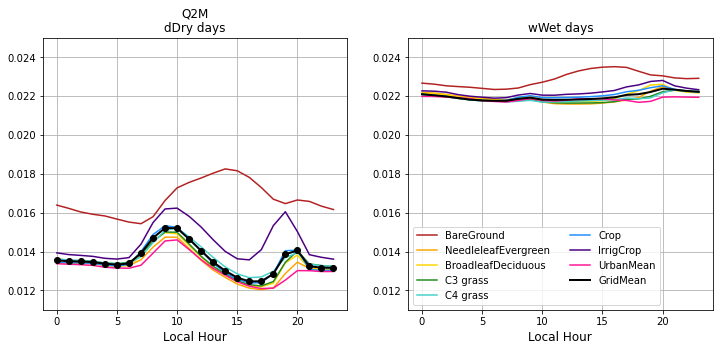

In [78]:
## Figure for manuscript

varSel = np.asarray(['Q2M'])

fig,axs = plt.subplots(len(varSel),2, figsize=(12,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

lineColors = np.asarray(['firebrick','orange','gold','forestgreen','mediumturquoise','dodgerblue','indigo','deeppink'])

yMax = np.asarray([0.025])
yMin = np.asarray([0.011])

iPlot=0
for iVar in range(len(varSel)):
    ## Get urban mean
    iUrban = np.where((colType>=70) & (colType<80))[0]

    varSel_urban_dDry = np.nansum(hourlyMeanPatch_dDry_HTGreal[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
    varSel_urban_wWet = np.nansum(hourlyMeanPatch_wWet_HTGreal[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])

    nPatches = len(patchLabels)-len(iUrban)
    
    for iPatch in range(nPatches):
        axs[iPlot].plot(hourlyMeanPatch_dDry_HTGreal.hour.values, 
                        np.squeeze(hourlyMeanPatch_dDry_HTGreal[varSel[iVar]].values[:, iPatch]),
                        '-', color=lineColors[iPatch], label=patchLabels[iPatch])
        
        axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTGreal.hour.values, 
                        np.squeeze(hourlyMeanPatch_wWet_HTGreal[varSel[iVar]].values[:, iPatch]),
                        '-', color=lineColors[iPatch], label=patchLabels[iPatch])
    
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTGreal.hour.values, varSel_urban_dDry,
             '-',color=lineColors[-1],label='UrbanMean')
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTGreal.hour.values, varSel_urban_wWet,
             '-',color=lineColors[-1],label='UrbanMean')
    
    
    ## dDry days 
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTGreal.hour.values, hourlyMeanCLM_dDry_HTGreal[varSel[iVar]].values, 'k-o',linewidth=2,label='GridMean')
    axs[iPlot].set_title(varSel[iVar]+'\ndDry days')
    axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])


    ## wWet days 
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTGreal.hour.values, hourlyMeanCLM_wWet_HTGreal[varSel[iVar]].values, 'k-',linewidth=2,label='GridMean')
    axs[iPlot+1].set_title('\nwWet days')
    axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])
    axs[iPlot+1].legend(loc='lower left',fontsize=10,ncol=2)
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


axs[0].grid()
axs[1].grid()



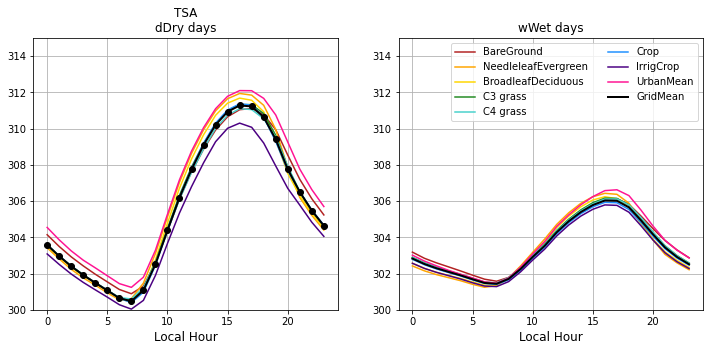

In [79]:
## Figure for manuscript

varSel = np.asarray(['TSA'])

fig,axs = plt.subplots(len(varSel),2, figsize=(12,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

lineColors = np.asarray(['firebrick','orange','gold','forestgreen','mediumturquoise','dodgerblue','indigo','deeppink'])

yMax = np.asarray([315])
yMin = np.asarray([300])

iPlot=0
for iVar in range(len(varSel)):
    ## Get urban mean
    iUrban = np.where((colType>=70) & (colType<80))[0]

    varSel_urban_dDry = np.nansum(hourlyMeanPatch_dDry_HTGreal[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
    varSel_urban_wWet = np.nansum(hourlyMeanPatch_wWet_HTGreal[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])

    nPatches = len(patchLabels)-len(iUrban)
    
    for iPatch in range(nPatches):
        axs[iPlot].plot(hourlyMeanPatch_dDry_HTGreal.hour.values, 
                        np.squeeze(hourlyMeanPatch_dDry_HTGreal[varSel[iVar]].values[:, iPatch]),
                        '-', color=lineColors[iPatch], label=patchLabels[iPatch])
        
        axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTGreal.hour.values, 
                        np.squeeze(hourlyMeanPatch_wWet_HTGreal[varSel[iVar]].values[:, iPatch]),
                        '-', color=lineColors[iPatch], label=patchLabels[iPatch])
    
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTGreal.hour.values, varSel_urban_dDry,
             '-',color=lineColors[-1],label='UrbanMean')
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTGreal.hour.values, varSel_urban_wWet,
             '-',color=lineColors[-1],label='UrbanMean')
    
    
    ## dDry days 
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTGreal.hour.values, hourlyMeanCLM_dDry_HTGreal[varSel[iVar]].values, 'k-o',linewidth=2,label='GridMean')
    axs[iPlot].set_title(varSel[iVar]+'\ndDry days')
    axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])


    ## wWet days 
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTGreal.hour.values, hourlyMeanCLM_wWet_HTGreal[varSel[iVar]].values, 'k-',linewidth=2,label='GridMean')
    axs[iPlot+1].set_title('\nwWet days')
    axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])
    axs[iPlot+1].legend(fontsize=10,ncol=2)
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


axs[0].grid()
axs[1].grid()



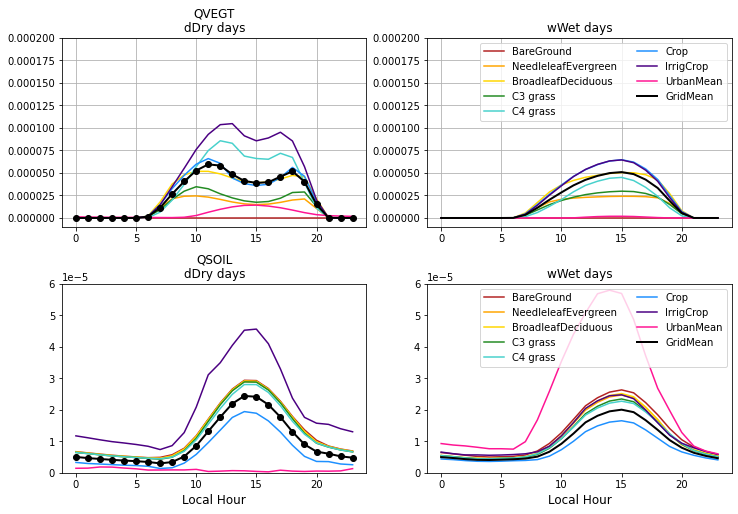

In [80]:
## Figure for manuscript

varSel = np.asarray(['QVEGT','QSOIL'])

fig,axs = plt.subplots(len(varSel),2, figsize=(12,8))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

lineColors = np.asarray(['firebrick','orange','gold','forestgreen','mediumturquoise','dodgerblue','indigo','deeppink'])

yMax = np.asarray([  0.0002, 0.00006])
yMin = np.asarray([-0.00001, 0])

iPlot=0
for iVar in range(len(varSel)):
    ## Get urban mean
    iUrban = np.where((colType>=70) & (colType<80))[0]

    varSel_urban_dDry = np.nansum(hourlyMeanPatch_dDry_HTGreal[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
    varSel_urban_wWet = np.nansum(hourlyMeanPatch_wWet_HTGreal[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])

    nPatches = len(patchLabels)-len(iUrban)
    
    for iPatch in range(nPatches):
        axs[iPlot].plot(hourlyMeanPatch_dDry_HTGreal.hour.values, 
                        np.squeeze(hourlyMeanPatch_dDry_HTGreal[varSel[iVar]].values[:, iPatch]),
                        '-', color=lineColors[iPatch], label=patchLabels[iPatch])
        
        axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTGreal.hour.values, 
                        np.squeeze(hourlyMeanPatch_wWet_HTGreal[varSel[iVar]].values[:, iPatch]),
                        '-', color=lineColors[iPatch], label=patchLabels[iPatch])
    
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTGreal.hour.values, varSel_urban_dDry,
             '-',color=lineColors[-1],label='UrbanMean')
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTGreal.hour.values, varSel_urban_wWet,
             '-',color=lineColors[-1],label='UrbanMean')
    
    
    ## dDry days 
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTGreal.hour.values, hourlyMeanCLM_dDry_HTGreal[varSel[iVar]].values, 'k-o',linewidth=2,label='GridMean')
    axs[iPlot].set_title(varSel[iVar]+'\ndDry days')
    axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])


    ## wWet days 
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTGreal.hour.values, hourlyMeanCLM_wWet_HTGreal[varSel[iVar]].values, 'k-',linewidth=2,label='GridMean')
    axs[iPlot+1].set_title('\nwWet days')
    axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])
    axs[iPlot+1].legend(fontsize=10,ncol=2)
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


axs[0].grid()
axs[1].grid()



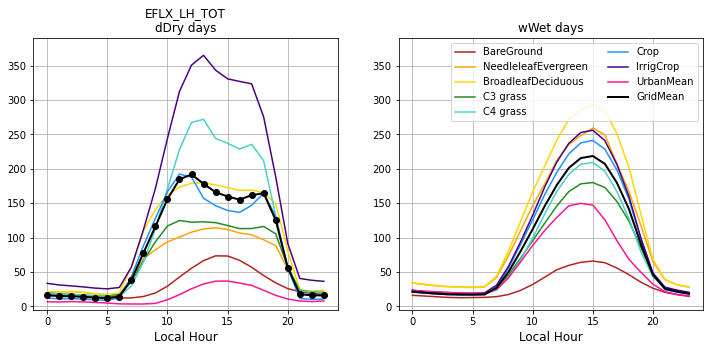

In [81]:
## Figure for manuscript

varSel = np.asarray(['EFLX_LH_TOT'])

fig,axs = plt.subplots(len(varSel),2, figsize=(12,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

lineColors = np.asarray(['firebrick','orange','gold','forestgreen','mediumturquoise','dodgerblue','indigo','deeppink'])

yMax = np.asarray([390])
yMin = np.asarray([-5])

iPlot=0
for iVar in range(len(varSel)):
    ## Get urban mean
    iUrban = np.where((colType>=70) & (colType<80))[0]

    varSel_urban_dDry = np.nansum(hourlyMeanPatch_dDry_HTGreal[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
    varSel_urban_wWet = np.nansum(hourlyMeanPatch_wWet_HTGreal[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])

    nPatches = len(patchLabels)-len(iUrban)
    
    for iPatch in range(nPatches):
        axs[iPlot].plot(hourlyMeanPatch_dDry_HTGreal.hour.values, 
                        np.squeeze(hourlyMeanPatch_dDry_HTGreal[varSel[iVar]].values[:, iPatch]),
                        '-', color=lineColors[iPatch], label=patchLabels[iPatch])
        
        axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTGreal.hour.values, 
                        np.squeeze(hourlyMeanPatch_wWet_HTGreal[varSel[iVar]].values[:, iPatch]),
                        '-', color=lineColors[iPatch], label=patchLabels[iPatch])
    
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTGreal.hour.values, varSel_urban_dDry,
             '-',color=lineColors[-1],label='UrbanMean')
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTGreal.hour.values, varSel_urban_wWet,
             '-',color=lineColors[-1],label='UrbanMean')
    
    
    ## dDry days 
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTGreal.hour.values, hourlyMeanCLM_dDry_HTGreal[varSel[iVar]].values, 'k-o',linewidth=2,label='GridMean')
    axs[iPlot].set_title(varSel[iVar]+'\ndDry days')
    axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])


    ## wWet days 
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTGreal.hour.values, hourlyMeanCLM_wWet_HTGreal[varSel[iVar]].values, 'k-',linewidth=2,label='GridMean')
    axs[iPlot+1].set_title('\nwWet days')
    axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])
    axs[iPlot+1].legend(fontsize=10,ncol=2)
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


axs[0].grid()
axs[1].grid()



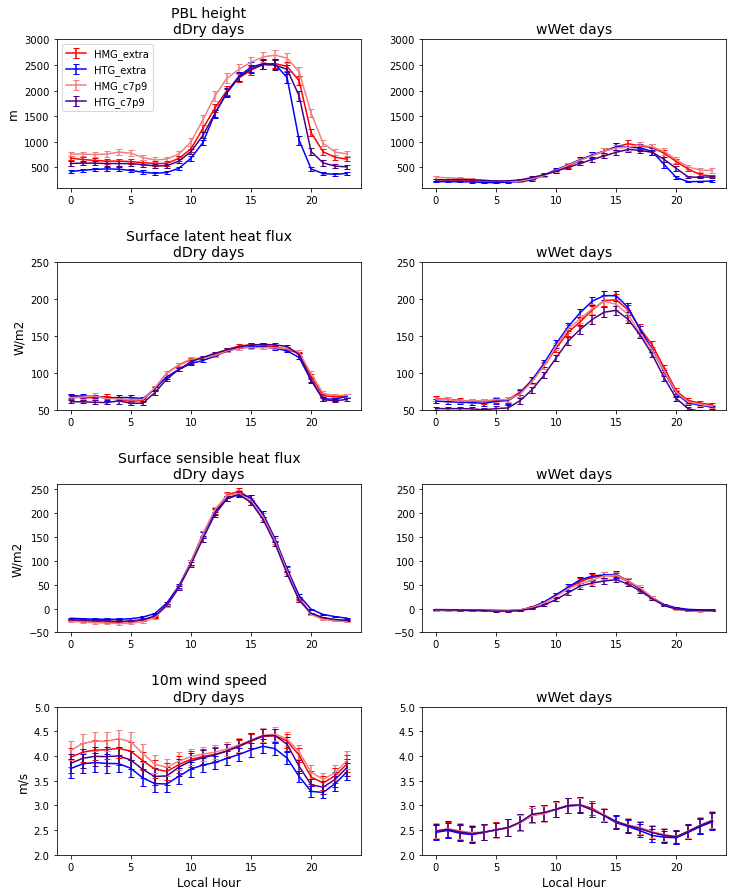

In [41]:
## Fig for manuscript 

varSel = np.asarray(['PBLH','LHFLX','SHFLX','U10'])

fig,axs = plt.subplots(len(varSel),2, figsize=(12,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)


yMax = np.asarray([3000, 250,  260,  5])
yMin = np.asarray([ 100,  50,  -50,  2])

iPlot=0
for iVar in range(len(varSel)):
    # Plot artificial surface moments
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMGart.hour.values, np.squeeze(hourlyMean_dDry_HMGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMGart[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMGart['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG_extra')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTGart.hour.values, np.squeeze(hourlyMean_dDry_HTGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTGart[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTGart['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG_extra')
    
    
    #C7 
#     axs[iPlot+0].errorbar(hourlyMean_dDry_HMGartc7p7.hour.values, np.squeeze(hourlyMean_dDry_HMGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HMGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMGartc7p7['SampleCount'].values),
#                           fmt='-',color='brown', capsize=3, label='HMG_c7p7')
#     axs[iPlot+0].errorbar(hourlyMean_dDry_HTGartc7p7.hour.values, np.squeeze(hourlyMean_dDry_HTGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HTGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTGartc7p7['SampleCount'].values),
#                           fmt='-',color='slateblue', capsize=3, label='HTG_c7p7')

    
    
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMGartc7p9.hour.values, np.squeeze(hourlyMean_dDry_HMGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMGartc7p9['SampleCount'].values),
                          fmt='-',color='lightcoral', capsize=3, label='HMG_c7p9')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTGartc7p9.hour.values, np.squeeze(hourlyMean_dDry_HTGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTGartc7p9['SampleCount'].values),
                          fmt='-',color='indigo', capsize=3, label='HTG_c7p9')
    
    
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=10)
    
    
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_localReal['PBLH'].units)
        axs[iPlot+0].set_title('PBLdepth\ndDry days', fontsize=14)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_localReal[varSel[iVar]].units, fontsize=12)
        axs[iPlot+0].set_title(HMGcamDS_localReal[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMGart.hour.values, np.squeeze(hourlyMean_wWet_HMGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMGart[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMGart['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG_extra')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTGart.hour.values, np.squeeze(hourlyMean_wWet_HTGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTGart[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTGart['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG_extra')
    
     #C7 
#     axs[iPlot+1].errorbar(hourlyMean_wWet_HMGartc7p7.hour.values, np.squeeze(hourlyMean_wWet_HMGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_wWet_HMGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMGartc7p7['SampleCount'].values),
#                           fmt='-',color='brown', capsize=3, label='HMG_c7p7')
#     axs[iPlot+1].errorbar(hourlyMean_wWet_HTGartc7p7.hour.values, np.squeeze(hourlyMean_wWet_HTGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_wWet_HTGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTGartc7p7['SampleCount'].values),
#                           fmt='-',color='slateblue', capsize=3, label='HTG_c7p7')

    
    
    axs[iPlot+1].errorbar(hourlyMean_wWet_HMGartc7p9.hour.values, np.squeeze(hourlyMean_wWet_HMGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMGartc7p9['SampleCount'].values),
                          fmt='-',color='lightcoral', capsize=3, label='HMG_c7p9')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTGartc7p9.hour.values, np.squeeze(hourlyMean_wWet_HTGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTGartc7p9['SampleCount'].values),
                          fmt='-',color='indigo', capsize=3, label='HTG_c7p9')

    
    
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


# axs[0].grid()


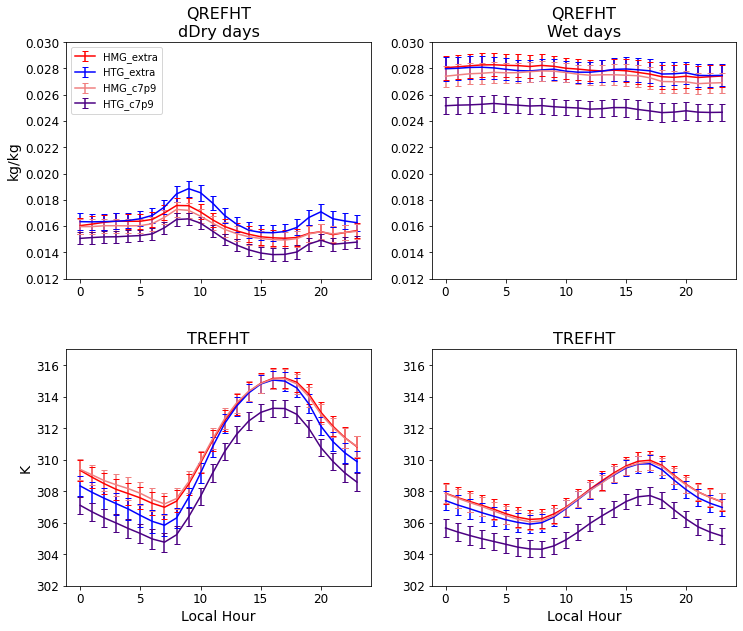

In [43]:
## Fig for manuscript 

varSel = np.asarray(['QREFHT','TREFHT'])

fig,axs = plt.subplots(len(varSel),2, figsize=(12,10))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

yMax = np.asarray([0.030, 317])
yMin = np.asarray([0.012, 302])


iPlot=0
for iVar in range(len(varSel)):
    # Plot artificial surface moments
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMGart.hour.values, np.squeeze(hourlyMean_dDry_HMGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMGart[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMGart['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG_extra')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTGart.hour.values, np.squeeze(hourlyMean_dDry_HTGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTGart[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTGart['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG_extra')
        
    # C7 
#     axs[iPlot+0].errorbar(hourlyMean_dDry_HMGartc7p7.hour.values, np.squeeze(hourlyMean_dDry_HMGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HMGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMGartc7p7['SampleCount'].values),
#                           fmt='-',color='brown', capsize=3, label='HMG_c7p7')
#     axs[iPlot+0].errorbar(hourlyMean_dDry_HTGartc7p7.hour.values, np.squeeze(hourlyMean_dDry_HTGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HTGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTGartc7p7['SampleCount'].values),
#                           fmt='-',color='slateblue', capsize=3, label='HTG_c7p7')
    
    
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMGartc7p9.hour.values, np.squeeze(hourlyMean_dDry_HMGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMGartc7p9['SampleCount'].values),
                          fmt='-',color='lightcoral', capsize=3, label='HMG_c7p9')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTGartc7p9.hour.values, np.squeeze(hourlyMean_dDry_HTGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTGartc7p9['SampleCount'].values),
                          fmt='-',color='indigo', capsize=3, label='HTG_c7p9')
    
    
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=10)
        axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=16)
    else:
        axs[iPlot+0].set_title(varSel[iVar], fontsize=16)
    
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_localReal['PBLH'].units,fontsize=14)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_localReal[varSel[iVar]].units, fontsize=14)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMGart.hour.values, np.squeeze(hourlyMean_wWet_HMGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMGart[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMGart['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG_extra')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTGart.hour.values, np.squeeze(hourlyMean_wWet_HTGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTGart[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTGart['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG_extra')
    
    # C7 
#     axs[iPlot+1].errorbar(hourlyMean_wWet_HMGartc7p7.hour.values, np.squeeze(hourlyMean_wWet_HMGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_wWet_HMGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMGartc7p7['SampleCount'].values),
#                           fmt='-',color='brown', capsize=3, label='HMG_c7p7')
#     axs[iPlot+1].errorbar(hourlyMean_wWet_HTGartc7p7.hour.values, np.squeeze(hourlyMean_wWet_HTGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_wWet_HTGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTGartc7p7['SampleCount'].values),
#                           fmt='-',color='slateblue', capsize=3, label='HTG_c7p7')

    
    axs[iPlot+1].errorbar(hourlyMean_wWet_HMGartc7p9.hour.values, np.squeeze(hourlyMean_wWet_HMGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMGartc7p9['SampleCount'].values),
                          fmt='-',color='lightcoral', capsize=3, label='HMG_c7p9')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTGartc7p9.hour.values, np.squeeze(hourlyMean_wWet_HTGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTGartc7p9['SampleCount'].values),
                          fmt='-',color='indigo', capsize=3, label='HTG_c7p9')

    
    
    if iVar==0:
        axs[iPlot+1].set_title(varSel[iVar]+'\nWet days', fontsize=16)
    else:
        axs[iPlot+1].set_title(varSel[iVar], fontsize=16)
        
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    axs[iPlot+0].tick_params(axis='both', labelsize= 12)
    axs[iPlot+1].tick_params(axis='both', labelsize= 12)
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=14)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=14)

    iPlot = iPlot+2


# axs[0].grid()

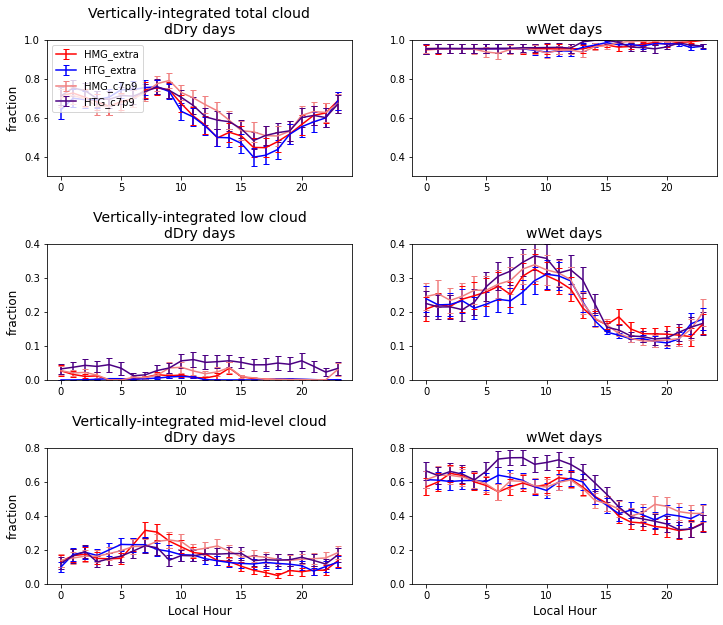

In [91]:
## Fig for manuscript 

varSel = np.asarray(['CLDTOT','CLDLOW','CLDMED'])

fig,axs = plt.subplots(len(varSel),2, figsize=(12,10))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

yMax = np.asarray([1.0, 0.4, 0.8])
yMin = np.asarray([0.3, 0.0, 0.0])


iPlot=0
for iVar in range(len(varSel)):
    # Plot artificial surface moments
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMGart.hour.values, np.squeeze(hourlyMean_dDry_HMGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMGart[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMGart['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG_extra')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTGart.hour.values, np.squeeze(hourlyMean_dDry_HTGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTGart[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTGart['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG_extra')
    

#     axs[iPlot+0].errorbar(hourlyMean_dDry_HTGart5.hour.values, np.squeeze(hourlyMean_dDry_HTGart5[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HTGart5[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTGart5['SampleCount'].values),
#                           fmt='-',color='dodgerblue', capsize=3, label='HTG_extra*0.5')
    
#     axs[iPlot+0].errorbar(hourlyMean_dDry_HTGart25.hour.values, np.squeeze(hourlyMean_dDry_HTGart25[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HTGart25[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTGart25['SampleCount'].values),
#                           fmt='-',color='skyblue', capsize=3, label='HTG_extra*0.25')
    
    #C7 
#     axs[iPlot+0].errorbar(hourlyMean_dDry_HMGartc7p7.hour.values, np.squeeze(hourlyMean_dDry_HMGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HMGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMGartc7p7['SampleCount'].values),
#                           fmt='-',color='brown', capsize=3, label='HMG_c7p7')
#     axs[iPlot+0].errorbar(hourlyMean_dDry_HTGartc7p7.hour.values, np.squeeze(hourlyMean_dDry_HTGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_dDry_HTGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTGartc7p7['SampleCount'].values),
#                           fmt='-',color='slateblue', capsize=3, label='HTG_c7p7')

    
    
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMGartc7p9.hour.values, np.squeeze(hourlyMean_dDry_HMGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMGartc7p9['SampleCount'].values),
                          fmt='-',color='lightcoral', capsize=3, label='HMG_c7p9')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTGartc7p9.hour.values, np.squeeze(hourlyMean_dDry_HTGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTGartc7p9['SampleCount'].values),
                          fmt='-',color='indigo', capsize=3, label='HTG_c7p9')
    
    
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=10)
    
    
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_localReal['PBLH'].units)
        axs[iPlot+0].set_title('PBLdepth\ndDry days', fontsize=14)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_localReal[varSel[iVar]].units, fontsize=12)
        axs[iPlot+0].set_title(HMGcamDS_localReal[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMGart.hour.values, np.squeeze(hourlyMean_wWet_HMGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMGart[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMGart['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG_extra')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTGart.hour.values, np.squeeze(hourlyMean_wWet_HTGart[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTGart[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTGart['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG_extra')
    
     #C7 
#     axs[iPlot+1].errorbar(hourlyMean_wWet_HMGartc7p7.hour.values, np.squeeze(hourlyMean_wWet_HMGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_wWet_HMGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMGartc7p7['SampleCount'].values),
#                           fmt='-',color='brown', capsize=3, label='HMG_c7p7')
#     axs[iPlot+1].errorbar(hourlyMean_wWet_HTGartc7p7.hour.values, np.squeeze(hourlyMean_wWet_HTGartc7p7[varSel[iVar]].values), 
#                           yerr =2*np.squeeze(hourlyStd_wWet_HTGartc7p7[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTGartc7p7['SampleCount'].values),
#                           fmt='-',color='slateblue', capsize=3, label='HTG_c7p7')

    
    
    axs[iPlot+1].errorbar(hourlyMean_wWet_HMGartc7p9.hour.values, np.squeeze(hourlyMean_wWet_HMGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMGartc7p9['SampleCount'].values),
                          fmt='-',color='lightcoral', capsize=3, label='HMG_c7p9')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTGartc7p9.hour.values, np.squeeze(hourlyMean_wWet_HTGartc7p9[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTGartc7p9[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTGartc7p9['SampleCount'].values),
                          fmt='-',color='indigo', capsize=3, label='HTG_c7p9')

    
    
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    axs[iPlot+0].tick_params(axis='both', labelsize= 12)
    axs[iPlot+1].tick_params(axis='both', labelsize= 12)
    
    iPlot = iPlot+2


# axs[0].grid()



### Vertical profiles

In [45]:
startHr = 14
endHr   = 17
# startHr = 7
# endHr   = 10
# maxLev  = 2000
# minLev  = 0
maxLev  = 1000
minLev  = 700


Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


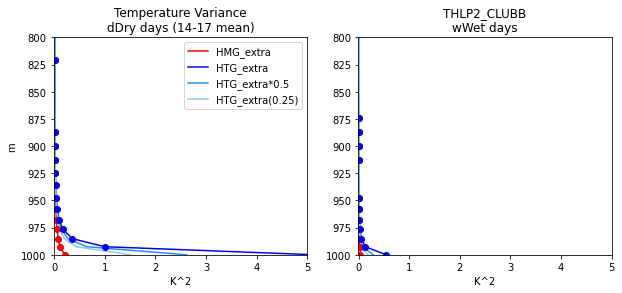

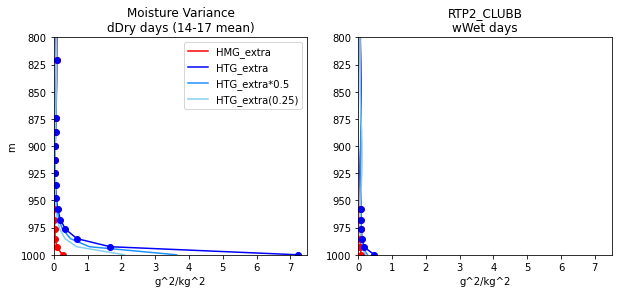

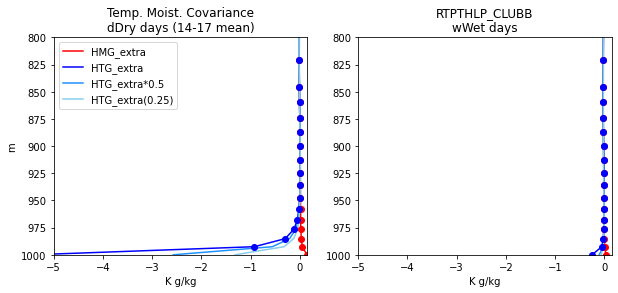

In [100]:
plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'THLP2_CLUBB', minLev, maxLev, 
#                            -0.01, 0.6)  # 8-10a
                             -0.01, 5)  # 2-5p

plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'RTP2_CLUBB', minLev, maxLev,
#                            0.0, 1.75)
                             0.0, 7.5)

plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'RTPTHLP_CLUBB', minLev, maxLev,
#                            -0.75, 0.15)
                             -5, 0.15)

Means computed over the inclusive period of 14 to 17.


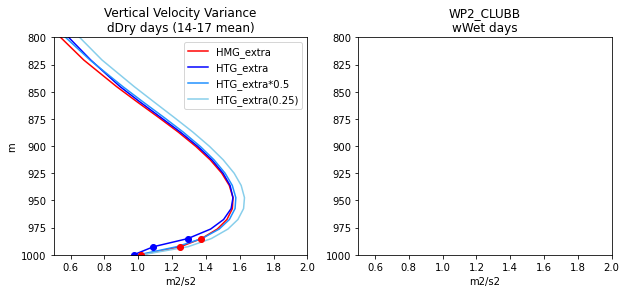

In [101]:
plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'WP2_CLUBB', minLev, maxLev,
#                            0.0, 1.75)
                             0.5, 2)

Means computed over the inclusive period of 14 to 17.


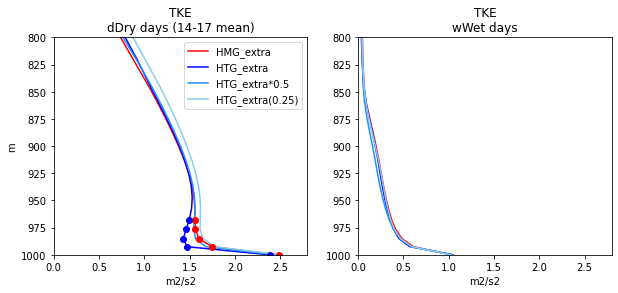

In [102]:
plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'TKE', minLev, maxLev,
#                            -0.75, 0.15)
                             0.0, 2.8)

Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


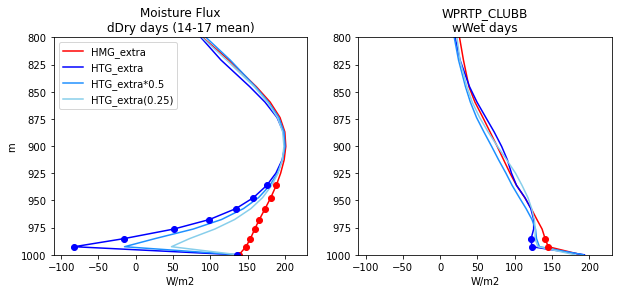

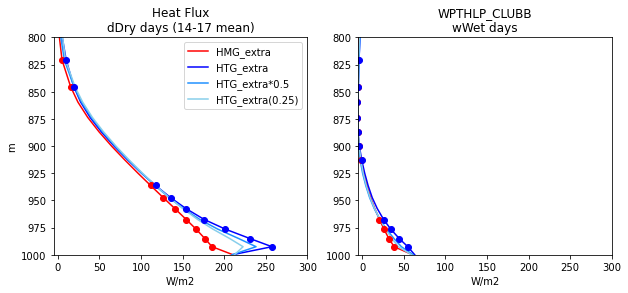

In [103]:
plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'WPRTP_CLUBB_interp', minLev, maxLev,
#                            -10, 120)
                            -110, 230) 
plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'WPTHLP_CLUBB', minLev, maxLev,
#                            -5, 80)
                           -5, 300)


**Moisture budget**

In [71]:
## Plot budget terms 

def wprtp_budget_plot(HMGds,HTGds,startHr,endHr,xmax,xmin):
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))


    meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wprtp_ma'].values[:,0,0]
    turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wprtp_ta'].values[:,0,0]
    turbProdHMG       = hourlyMean_dDryTimeSel_HMG['wprtp_tp'].values[:,0,0]
    accumHMG          = hourlyMean_dDryTimeSel_HMG['wprtp_ac'].values[:,0,0]
    buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wprtp_bp'].values[:,0,0]
    press1HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr1'].values[:,0,0]
    press2HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr2'].values[:,0,0]
    press3HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr3'].values[:,0,0]
    pressureApproxHMG = press1HMG+press2HMG+press3HMG
    dissipationHMG    = hourlyMean_dDryTimeSel_HMG['wprtp_dp1'].values[:,0,0]

    dwprtpdtHMG = hourlyMean_dDryTimeSel_HMG['wprtp_bt'].values[:,0,0]
    sumTermsHMG = meanAdvHMG + turbTranspHMG + turbProdHMG + accumHMG + buoyProdHMG + pressureApproxHMG + dissipationHMG

    residualHMG = dwprtpdtHMG - sumTermsHMG


    meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wprtp_ma'].values[:,0,0]
    turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wprtp_ta'].values[:,0,0]
    turbProdHTG       = hourlyMean_dDryTimeSel_HTG['wprtp_tp'].values[:,0,0]
    accumHTG          = hourlyMean_dDryTimeSel_HTG['wprtp_ac'].values[:,0,0]
    buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wprtp_bp'].values[:,0,0]
    press1HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr1'].values[:,0,0]
    press2HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr2'].values[:,0,0]
    press3HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr3'].values[:,0,0]
    pressureApproxHTG = press1HTG+press2HTG+press3HTG
    dissipationHTG    = hourlyMean_dDryTimeSel_HTG['wprtp_dp1'].values[:,0,0]

    dwprtpdtHTG = hourlyMean_dDryTimeSel_HTG['wprtp_bt'].values[:,0,0]
    sumTermsHTG = meanAdvHTG + turbTranspHTG + turbProdHTG + accumHTG + buoyProdHTG + pressureApproxHTG + dissipationHTG

    residualHTG = dwprtpdtHTG - sumTermsHTG
    
    
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    axs[0].plot(meanAdvHMG[0:-1],        HMGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[0].plot(turbTranspHMG[0:-1],     HMGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[0].plot(turbProdHMG[0:-1],       HMGds.ilev.values[0:-1], color=colorsList[2], label='turbProd')
    axs[0].plot(accumHMG[0:-1],          HMGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[0].plot(buoyProdHMG[0:-1],       HMGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[0].plot(pressureApproxHMG[0:-1], HMGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[0].plot(dissipationHMG[0:-1],    HMGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')

    axs[1].plot(meanAdvHTG[0:-1],        HTGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[1].plot(turbTranspHTG[0:-1],     HTGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[1].plot(turbProdHTG[0:-1],       HTGds.ilev.values[0:-1], color=colorsList[2], label='turbProd')
    axs[1].plot(accumHTG[0:-1],          HTGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[1].plot(buoyProdHTG[0:-1],       HTGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[1].plot(pressureApproxHTG[0:-1], HTGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[1].plot(dissipationHTG[0:-1],    HTGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')


    # Consistent settings across subplots 
    axs[0].set_ylim([800,1000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wprtp budget')

    axs[1].set_ylim([800,1000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wprtp budget')

    return



In [70]:
## Plot budget terms 

def wprtp_budget_plot_interp(HMGds,HTGds,startHr,endHr,xmax,xmin):
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))


    meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wprtp_ma_interp'].values[:,0,0]
    turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wprtp_ta_interp'].values[:,0,0]
    turbProdHMG       = hourlyMean_dDryTimeSel_HMG['wprtp_tp_interp'].values[:,0,0]
    accumHMG          = hourlyMean_dDryTimeSel_HMG['wprtp_ac_interp'].values[:,0,0]
    buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wprtp_bp_interp'].values[:,0,0]
    press1HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr1_interp'].values[:,0,0]
    press2HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr2_interp'].values[:,0,0]
    press3HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr3_interp'].values[:,0,0]
    pressureApproxHMG = press1HMG+press2HMG+press3HMG
    dissipationHMG    = hourlyMean_dDryTimeSel_HMG['wprtp_dp1_interp'].values[:,0,0]

#     dwprtpdtHMG = hourlyMean_dDryTimeSel_HMG['wprtp_bt'].values[:,0,0]
#     sumTermsHMG = meanAdvHMG + turbTranspHMG + turbProdHMG + accumHMG + buoyProdHMG + pressureApproxHMG + dissipationHMG
#     residualHMG = dwprtpdtHMG - sumTermsHMG


    meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wprtp_ma_interp'].values[:,0,0]
    turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wprtp_ta_interp'].values[:,0,0]
    turbProdHTG       = hourlyMean_dDryTimeSel_HTG['wprtp_tp_interp'].values[:,0,0]
    accumHTG          = hourlyMean_dDryTimeSel_HTG['wprtp_ac_interp'].values[:,0,0]
    buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wprtp_bp_interp'].values[:,0,0]
    press1HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr1_interp'].values[:,0,0]
    press2HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr2_interp'].values[:,0,0]
    press3HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr3_interp'].values[:,0,0]
    pressureApproxHTG = press1HTG+press2HTG+press3HTG
    dissipationHTG    = hourlyMean_dDryTimeSel_HTG['wprtp_dp1_interp'].values[:,0,0]

#     dwprtpdtHTG = hourlyMean_dDryTimeSel_HTG['wprtp_bt'].values[:,0,0]
#     sumTermsHTG = meanAdvHTG + turbTranspHTG + turbProdHTG + accumHTG + buoyProdHTG + pressureApproxHTG + dissipationHTG
#     residualHTG = dwprtpdtHTG - sumTermsHTG
    
    
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    axs[0].plot(meanAdvHMG[0:-1],        pnew64[0:-1], color=colorsList[0], label='meanAdv')
    axs[0].plot(turbTranspHMG[0:-1],     pnew64[0:-1], color=colorsList[1], label='turbTransp')
    axs[0].plot(turbProdHMG[0:-1],       pnew64[0:-1], color=colorsList[2], label='turbProd')
    axs[0].plot(accumHMG[0:-1],          pnew64[0:-1], color=colorsList[3], label='accum')
    axs[0].plot(buoyProdHMG[0:-1],       pnew64[0:-1], color=colorsList[4], label='buoyProd')
    axs[0].plot(pressureApproxHMG[0:-1], pnew64[0:-1], color=colorsList[5], label='pressureTerms')
    axs[0].plot(dissipationHMG[0:-1],    pnew64[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')

    axs[1].plot(meanAdvHTG[0:-1],        pnew64[0:-1], color=colorsList[0], label='meanAdv')
    axs[1].plot(turbTranspHTG[0:-1],     pnew64[0:-1], color=colorsList[1], label='turbTransp')
    axs[1].plot(turbProdHTG[0:-1],       pnew64[0:-1], color=colorsList[2], label='turbProd')
    axs[1].plot(accumHTG[0:-1],          pnew64[0:-1], color=colorsList[3], label='accum')
    axs[1].plot(buoyProdHTG[0:-1],       pnew64[0:-1], color=colorsList[4], label='buoyProd')
    axs[1].plot(pressureApproxHTG[0:-1], pnew64[0:-1], color=colorsList[5], label='pressureTerms')
    axs[1].plot(dissipationHTG[0:-1],    pnew64[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')


    # Consistent settings across subplots 
    axs[0].set_ylim([700,980])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wprtp budget')

    axs[1].set_ylim([700,980])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wprtp budget')

    return



Means computed over the inclusive period of 14 to 17.


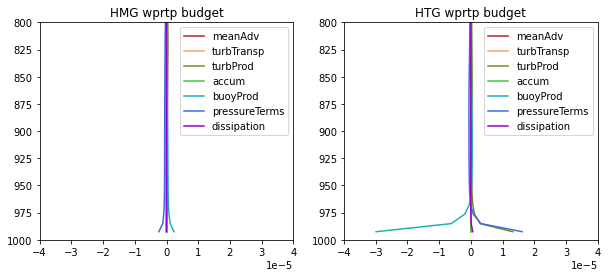

In [75]:
wprtp_budget_plot(dDryDays_HMGart,dDryDays_HTGart,startHr,endHr,4.0e-5,-4.0e-5)


Means computed over the inclusive period of 14 to 17.


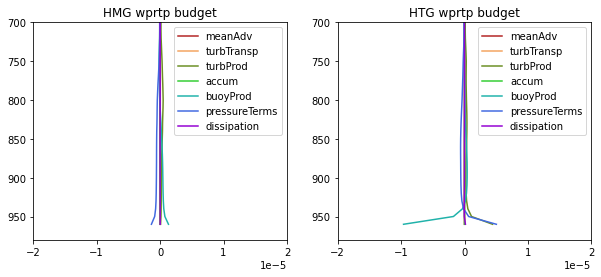

In [73]:
wprtp_budget_plot_interp(dDryDays_HMGart,dDryDays_HTGart,startHr,endHr,2.0e-5,-2.0e-5)


Means computed over the inclusive period of 14 to 17.


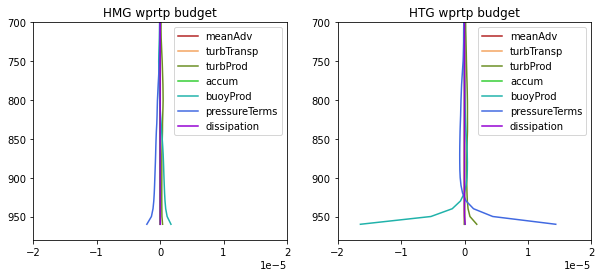

In [68]:
wprtp_budget_plot(dDryDays_HMGartc7p9,dDryDays_HTGartc7p9,startHr,endHr,2.0e-5,-2.0e-5)


Means computed over the inclusive period of 14 to 17.


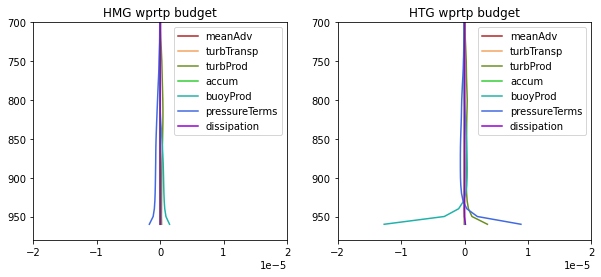

In [69]:
wprtp_budget_plot(dDryDays_HMGartc7p7,dDryDays_HTGartc7p7,startHr,endHr,2.0e-5,-2.0e-5)


In [77]:
# ------- dDry days ----------
iTimeSel_dDryHMG = np.where((dDryDays_HMGart["time.hour"].values>=startHr) & 
                            (dDryDays_HMGart["time.hour"].values<=endHr))[0]
iTimeSel_dDryHTG = np.where((dDryDays_HTGart["time.hour"].values>=startHr) & 
                            (dDryDays_HTGart["time.hour"].values<=endHr))[0]

## C7 
iTimeSel_dDryHMGc7p7 = np.where((dDryDays_HMGartc7p7["time.hour"].values>=startHr) & 
                                (dDryDays_HMGartc7p7["time.hour"].values<=endHr))[0]
iTimeSel_dDryHTGc7p7 = np.where((dDryDays_HTGartc7p7["time.hour"].values>=startHr) & 
                                (dDryDays_HTGartc7p7["time.hour"].values<=endHr))[0]

## C9 
iTimeSel_dDryHMGc7p9 = np.where((dDryDays_HMGartc7p9["time.hour"].values>=startHr) & 
                                (dDryDays_HMGartc7p9["time.hour"].values<=endHr))[0]
iTimeSel_dDryHTGc7p9 = np.where((dDryDays_HTGartc7p9["time.hour"].values>=startHr) & 
                                (dDryDays_HTGartc7p9["time.hour"].values<=endHr))[0]


hourlyMean_dDryTimeSel_HMG   = dDryDays_HMGart.isel(time=iTimeSel_dDryHMG).mean(dim='time')
hourlyMean_dDryTimeSel_HTG   = dDryDays_HTGart.isel(time=iTimeSel_dDryHTG).mean(dim='time')

hourlyMean_dDryTimeSel_HMGc7p7   = dDryDays_HMGartc7p7.isel(time=iTimeSel_dDryHMGc7p7).mean(dim='time')
hourlyMean_dDryTimeSel_HTGc7p7   = dDryDays_HTGartc7p7.isel(time=iTimeSel_dDryHTGc7p7).mean(dim='time')

hourlyMean_dDryTimeSel_HMGc7p9   = dDryDays_HMGartc7p9.isel(time=iTimeSel_dDryHMGc7p9).mean(dim='time')
hourlyMean_dDryTimeSel_HTGc7p9   = dDryDays_HTGartc7p9.isel(time=iTimeSel_dDryHTGc7p9).mean(dim='time')


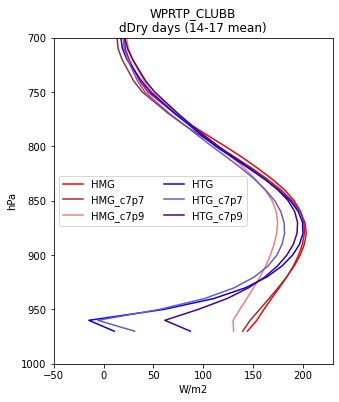

In [81]:
## Now we can figure out how to plot! 
fig,axs = plt.subplots(1,1, figsize=(5,6))

axs.plot(np.squeeze(hourlyMean_dDryTimeSel_HMG['WPRTP_CLUBB_interp'].values), 
                pnew64, 
                'r-',  label='HMG')
axs.plot(np.squeeze(hourlyMean_dDryTimeSel_HMGc7p7['WPRTP_CLUBB_interp'].values), 
                pnew64,
                color='brown',  label='HMG_c7p7')
axs.plot(np.squeeze(hourlyMean_dDryTimeSel_HMGc7p9['WPRTP_CLUBB_interp'].values), 
                pnew64,
                color='lightcoral',  label='HMG_c7p9')


axs.plot(np.squeeze(hourlyMean_dDryTimeSel_HTG['WPRTP_CLUBB_interp'].values), 
                pnew64,
                'b', label='HTG')
axs.plot(np.squeeze(hourlyMean_dDryTimeSel_HTGc7p7['WPRTP_CLUBB_interp'].values), 
                pnew64,
                color='slateblue', label='HTG_c7p7')
axs.plot(np.squeeze(hourlyMean_dDryTimeSel_HTGc7p9['WPRTP_CLUBB_interp'].values), 
                pnew64,
                color='indigo', label='HTG_c7p9')


axs.legend(ncol=2)
axs.set_title('WPRTP_CLUBB\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
axs.set_ylabel('hPa')
axs.set_xlabel('W/m2')

axs.set_ylim([700,1000])
axs.set_xlim([-50,230])
axs.invert_yaxis()



In [ ]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, varSel, minLev, maxLev, xMin, xMax):
    
    
        
    axs[0].legend()
    axs[0].set_title(titleStr+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel('m')
    axs[0].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(hourlyMean_dDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[0].plot(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_dDryTimeSel_HMG[levSel].values[iLev], 
                        'ro')
            axs[0].plot(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev], 
                    hourlyMean_dDryTimeSel_HTG[levSel].values[iLev], 
                    'bo')
    
            

    # Plot wWet days 
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
                    hourlyMean_wWetTimeSel_HMG[levSel].values,
                    'r', label='HMG_extra')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG[levSel].values,
                    'b', label='HTG_extra')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG5[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG5[levSel].values,
                    color='dodgerblue', label='HTG_extra*0.5')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG25[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG25[levSel].values,
                    color='skyblue', label='HTG_extra*0.25')
    
    axs[1].set_title(varSel+'\nwWet days')
    axs[1].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) + (2*stdErr_wWet_HMG)
    xmin1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) - (2*stdErr_wWet_HMG)
    xmax2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) + (2*stdErr_wWet_HTG)
    xmin2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) - (2*stdErr_wWet_HTG)

    levSig = np.ones([len(hourlyMean_wWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[1].plot(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HMG[levSel].values[iLev], 
                        'ro')
            axs[1].plot(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HTG[levSel].values[iLev], 
                        'bo')

    # Consistent settings across subplots 
    axs[0].set_ylim([minLev,maxLev])
    axs[1].set_ylim([minLev,maxLev])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()

    
    return

Means computed over the inclusive period of 14 to 16.


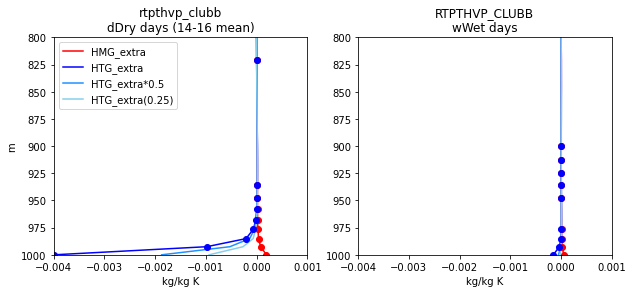

In [68]:
plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'RTPTHVP_CLUBB', minLev, maxLev,
#                            -10, 120)
                            -4e-3, 1e-3)  

Means computed over the inclusive period of 14 to 16.


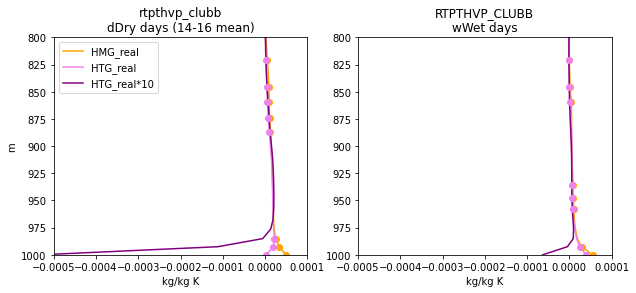

In [70]:
plotProfiles_WithErrBar_timeOfDayMean_real(startHr, endHr, 'RTPTHVP_CLUBB', minLev, maxLev,
#                            -10, 120)
                            -5e-4, 1e-4)  

Means computed over the inclusive period of 14 to 16.


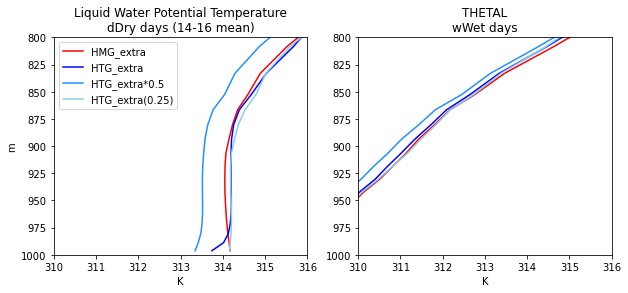

In [72]:
plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'THETAL', minLev, maxLev,
#                            -10, 120)
                            310, 316)  

Means computed over the inclusive period of 14 to 16.


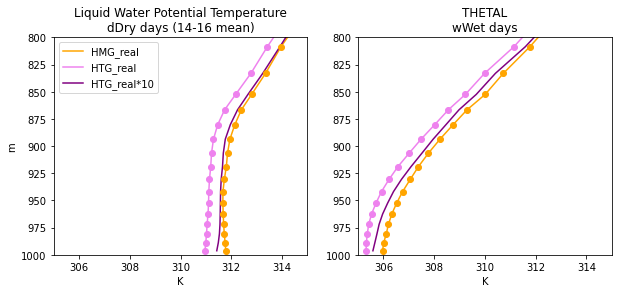

In [89]:
plotProfiles_WithErrBar_timeOfDayMean_real(startHr, endHr, 'THETAL', minLev, maxLev,
#                            -10, 120)
                            305, 315)  

Means computed over the inclusive period of 14 to 16.
Means computed over the inclusive period of 14 to 16.


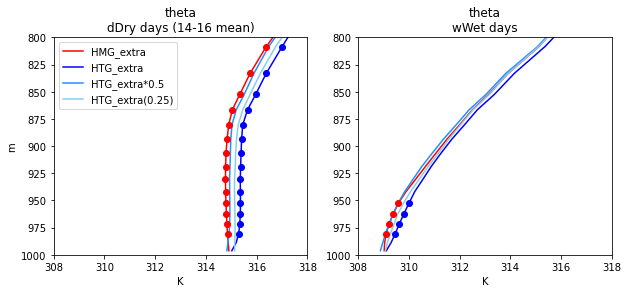

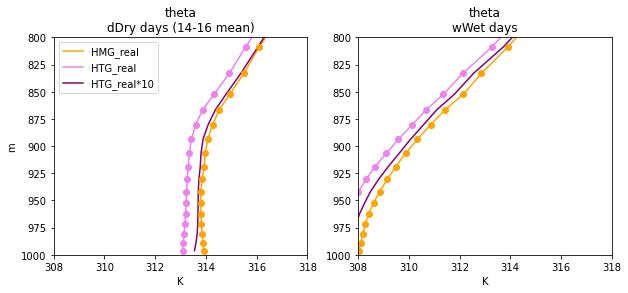

In [96]:
plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'theta', minLev, maxLev,
#                            -10, 120)
                            308, 318)  
plotProfiles_WithErrBar_timeOfDayMean_real(startHr, endHr, 'theta', minLev, maxLev,
#                            -10, 120)
                            308, 318)  

Means computed over the inclusive period of 14 to 16.
Means computed over the inclusive period of 14 to 16.


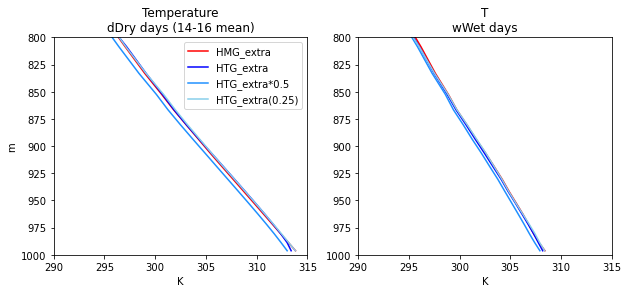

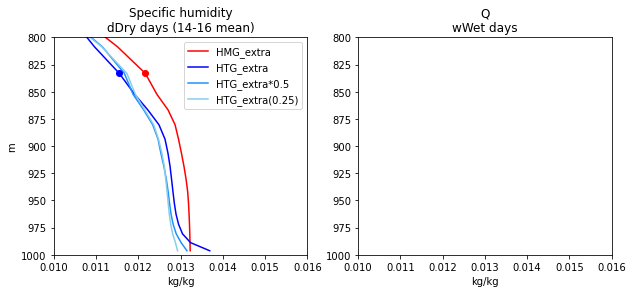

In [74]:
plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'T', minLev, maxLev,
#                            -10, 120)
                            290, 315)  

plotProfiles_WithErrBar_timeOfDayMean_art(startHr, endHr, 'Q', minLev, maxLev,
#                            -10, 120)
                            0.01, 0.016)  

Means computed over the inclusive period of 14 to 16.
Means computed over the inclusive period of 14 to 16.


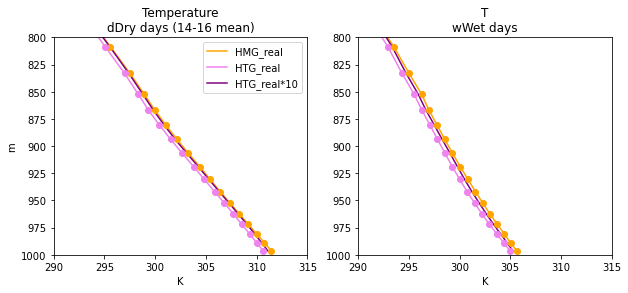

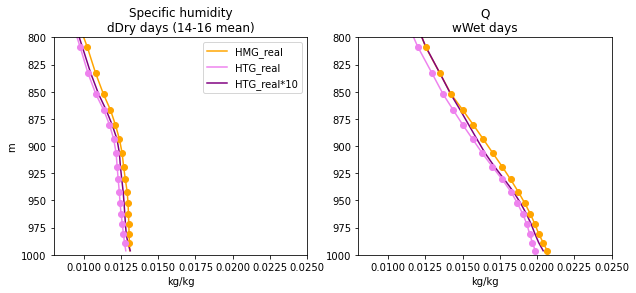

In [101]:
plotProfiles_WithErrBar_timeOfDayMean_real(startHr, endHr, 'T', minLev, maxLev,
#                            -10, 120)
                            290, 315)  

plotProfiles_WithErrBar_timeOfDayMean_real(startHr, endHr, 'Q', minLev, maxLev,
#                            -10, 120)
                            0.008, 0.025)  

## Contour plots

HTGreal * 10


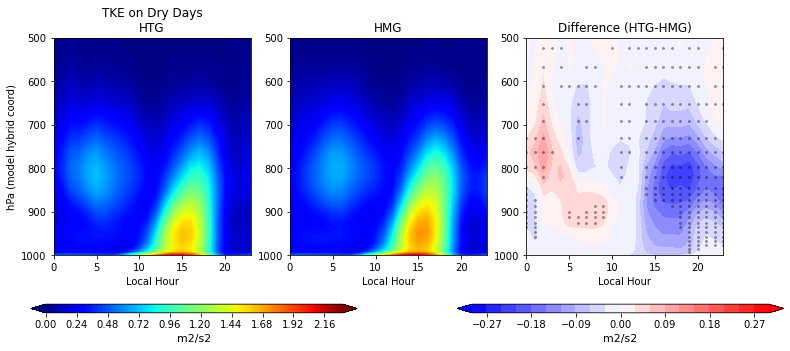

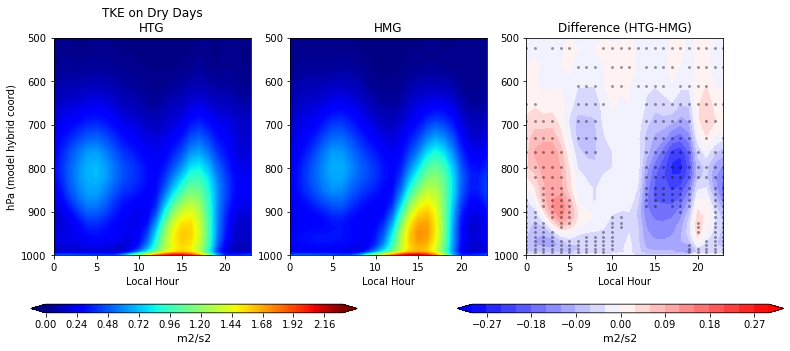

In [121]:
plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal,
                                                    'TKE',1000,500,
                                                    np.arange(-0.3, 0.33, 0.03), 
                                                    np.arange(0,2.32,0.02))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal10,
                                                    'TKE',1000,500,
                                                    np.arange(-0.3, 0.33, 0.03), 
                                                    np.arange(0,2.32,0.02))

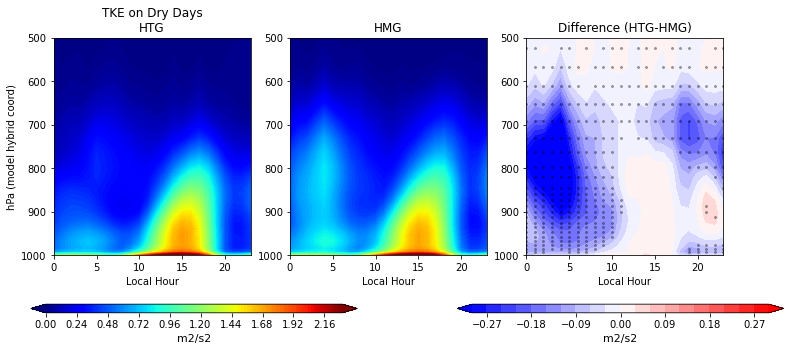

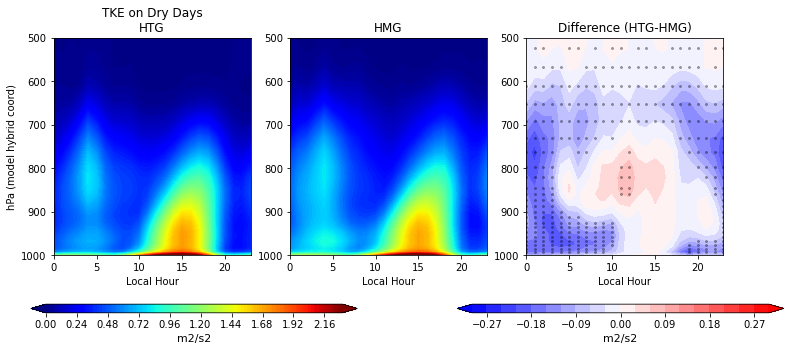

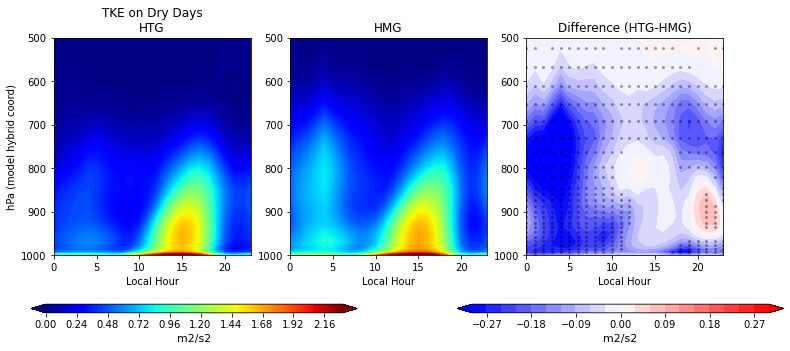

In [122]:
plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart25,
                                                    'TKE',1000,500,
                                                    np.arange(-0.3, 0.33, 0.03), 
                                                    np.arange(0,2.32,0.02))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart5,
                                                    'TKE',1000,500,
                                                    np.arange(-0.3, 0.33, 0.03), 
                                                    np.arange(0,2.32,0.02))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart,
                                                    'TKE',1000,500,
                                                    np.arange(-0.3, 0.33, 0.03), 
                                                    np.arange(0,2.32,0.02))

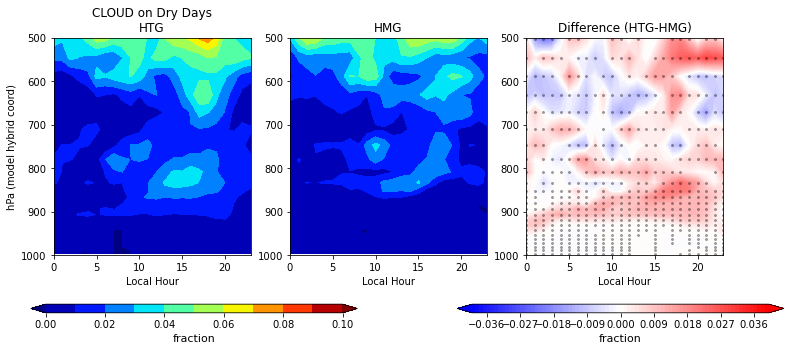

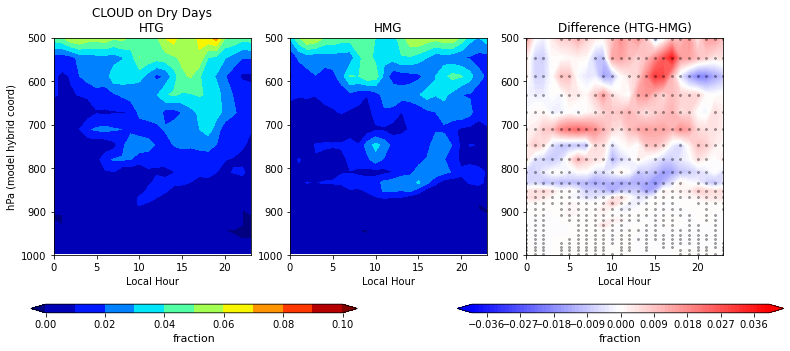

In [123]:
plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal,
                                                    'CLOUD',1000,500,
                                                    np.arange(-0.04,0.041,0.001), 
                                                    np.arange(0,0.11,0.01))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal10,
                                                    'CLOUD',1000,500,
                                                    np.arange(-0.04,0.041,0.001), 
                                                    np.arange(0,0.11,0.01))

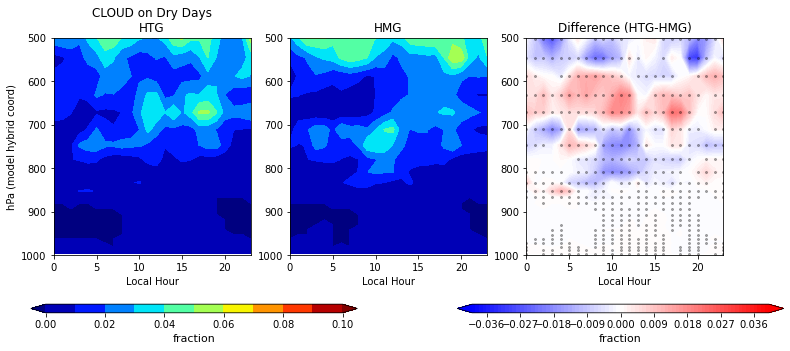

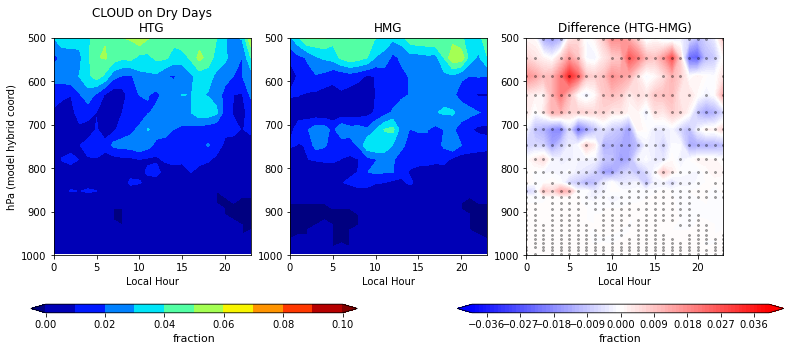

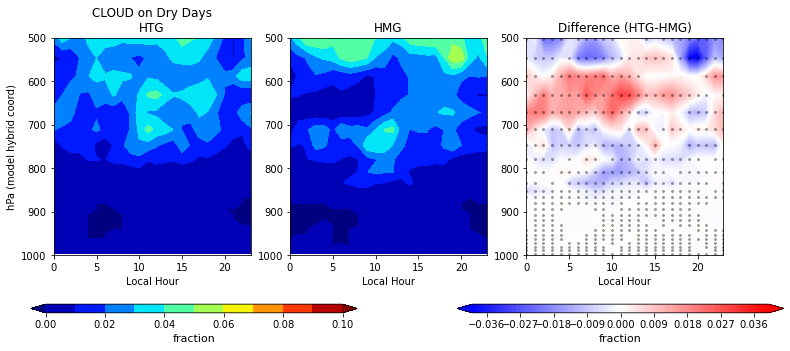

In [124]:
plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart25,
                                                    'CLOUD',1000,500,
                                                    np.arange(-0.04,0.041,0.001), 
                                                    np.arange(0,0.11,0.01))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart5,
                                                    'CLOUD',1000,500,
                                                    np.arange(-0.04,0.041,0.001), 
                                                    np.arange(0,0.11,0.01))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart,
                                                    'CLOUD',1000,500,
                                                    np.arange(-0.04,0.041,0.001), 
                                                    np.arange(0,0.11,0.01))

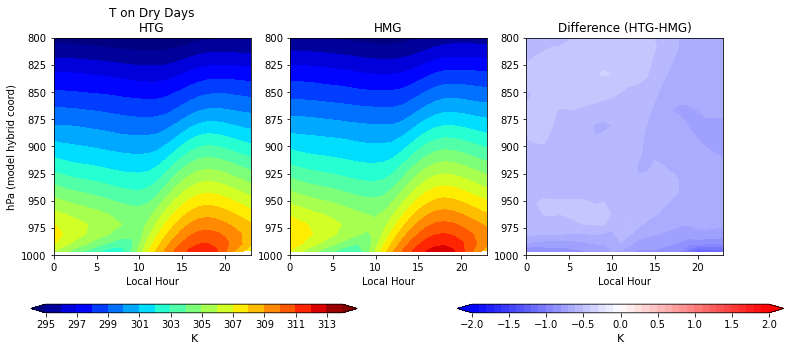

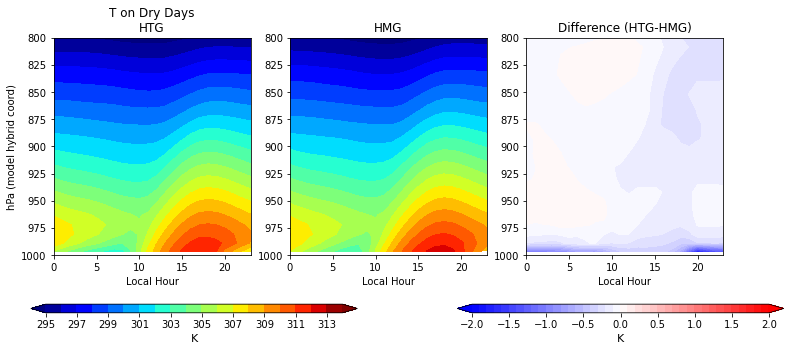

In [126]:
plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal,
                                                    'T',1000,800,
                                                    np.arange(-2,2.1,0.1), 
                                                           np.arange(295,315,1))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal10,
                                                    'T',1000,800,
                                                    np.arange(-2,2.1,0.1), 
                                                           np.arange(295,315,1))

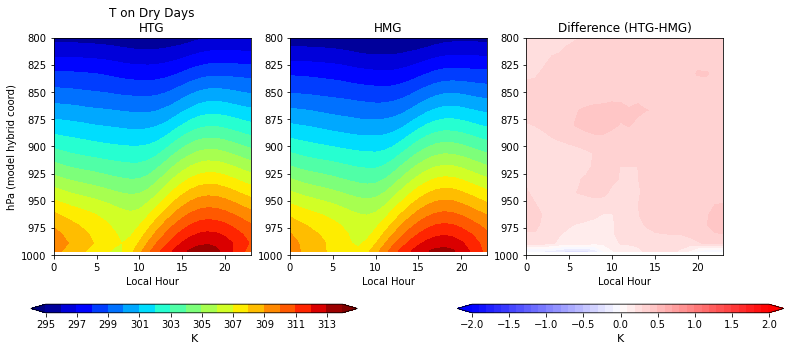

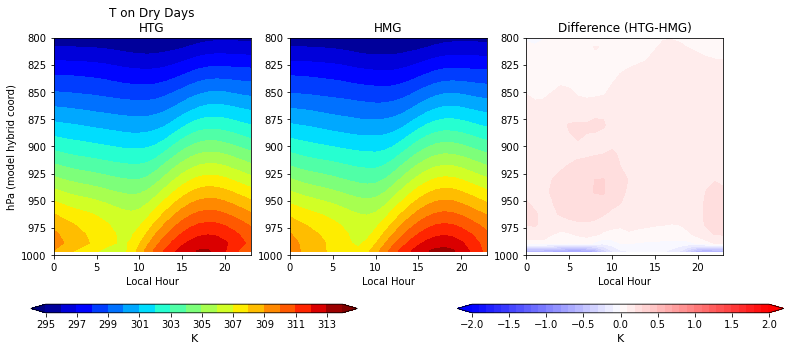

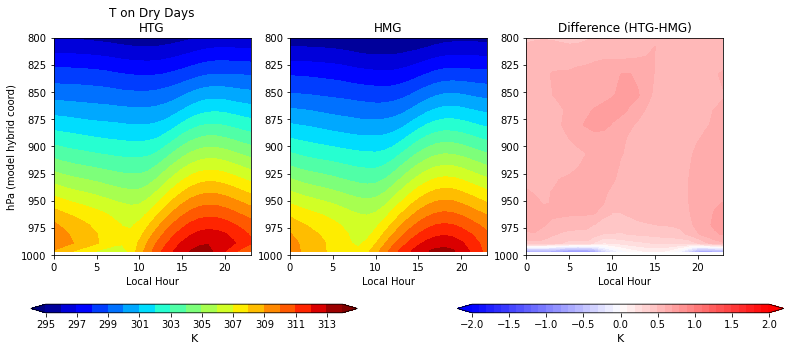

In [127]:
plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart25,
                                                    'T',1000,800,
                                                    np.arange(-2,2.1,0.1), 
                                                           np.arange(295,315,1))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart5,
                                                    'T',1000,800,
                                                    np.arange(-2,2.1,0.1), 
                                                           np.arange(295,315,1))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart,
                                                    'T',1000,800,
                                                    np.arange(-2,2.1,0.1), 
                                                           np.arange(295,315,1))

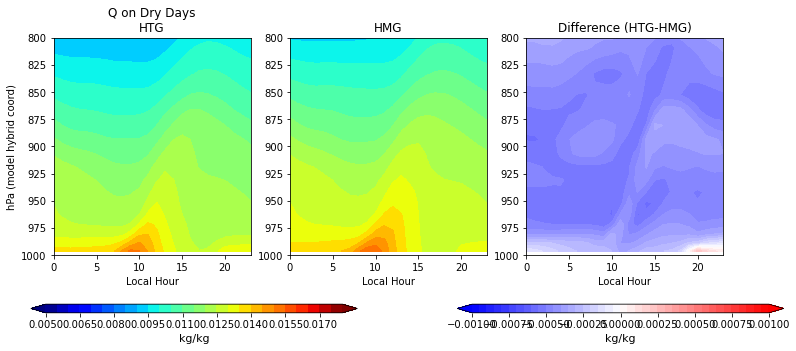

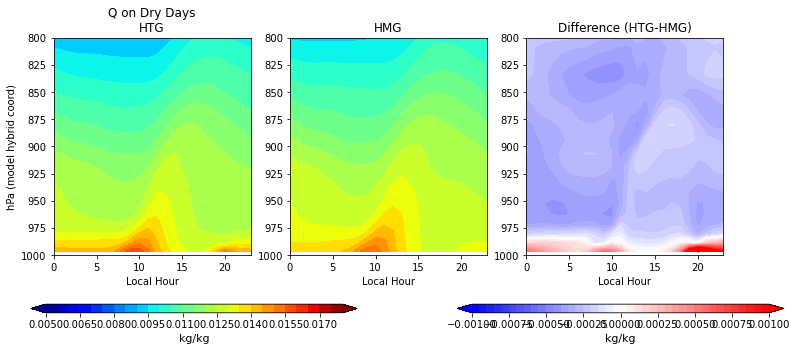

In [128]:
plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal,
                                                    'Q',1000,800,
                                                    np.arange(-1e-3, 1.05e-3, 0.05e-3), 
                                                           np.arange(0.005, 0.0185, 0.0005))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal10,
                                                    'Q',1000,800,
                                                    np.arange(-1e-3, 1.05e-3, 0.05e-3), 
                                                           np.arange(0.005, 0.0185, 0.0005))

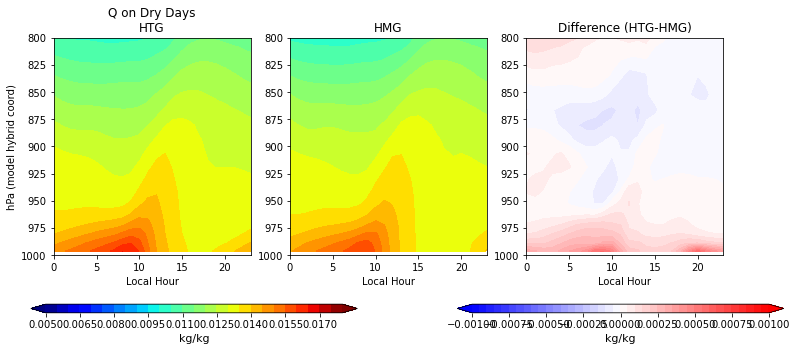

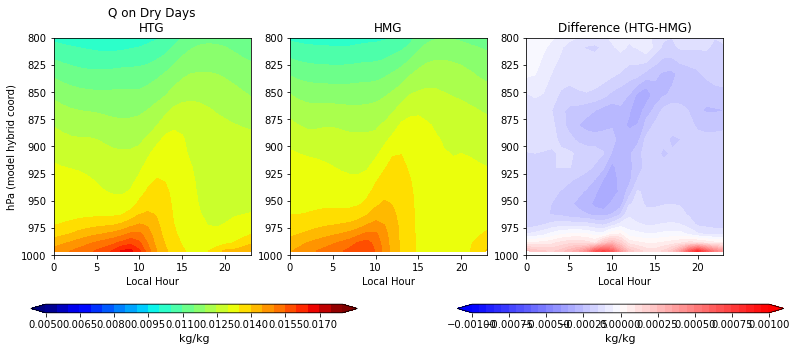

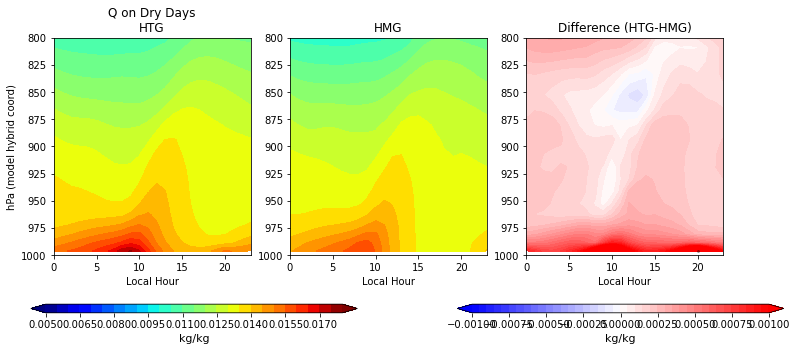

In [129]:
plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart25,
                                                    'Q',1000,800,
                                                    np.arange(-1e-3, 1.05e-3, 0.05e-3), 
                                                           np.arange(0.005, 0.0185, 0.0005))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart5,
                                                    'Q',1000,800,
                                                    np.arange(-1e-3, 1.05e-3, 0.05e-3), 
                                                           np.arange(0.005, 0.0185, 0.0005))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart,
                                                    'Q',1000,800,
                                                    np.arange(-1e-3, 1.05e-3, 0.05e-3), 
                                                           np.arange(0.005, 0.0185, 0.0005))

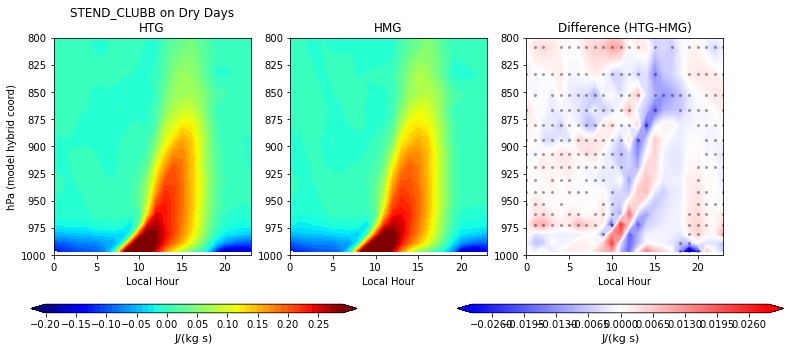

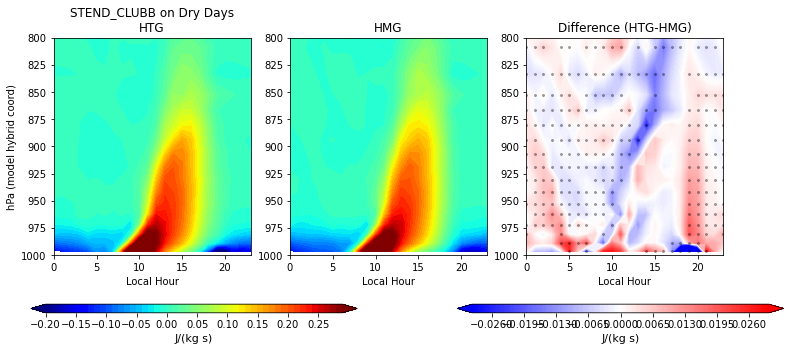

In [130]:
plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal,
                                                    'STEND_CLUBB',1000,800,
                                                    np.arange(-3e-2, 3.05e-2, 0.05e-2), 
                                                           np.arange(-0.2, 0.3, 0.01))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal10,
                                                    'STEND_CLUBB',1000,800,
                                                    np.arange(-3e-2, 3.05e-2, 0.05e-2), 
                                                           np.arange(-0.2, 0.3, 0.01))

Longwave heating rate


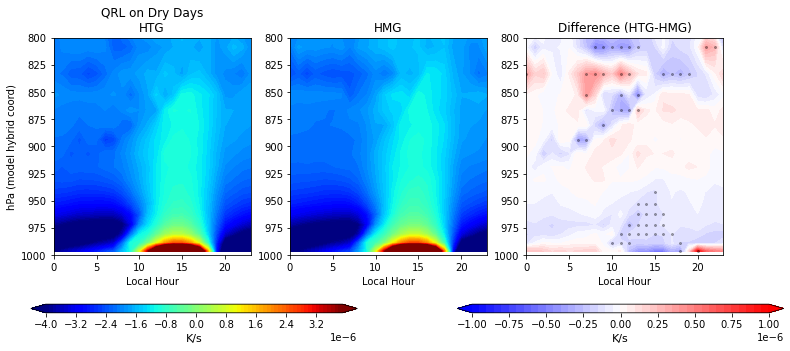

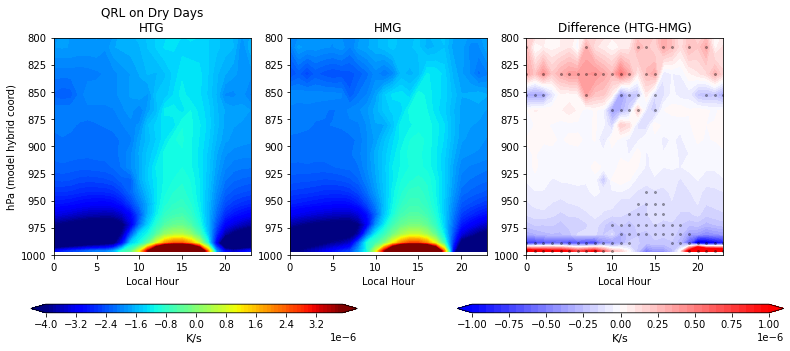

In [133]:
print(HTGcamDS_localReal.QRL.long_name)
plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal,
                                                    'QRL',1000,800,
                                                    np.arange(-1e-6, 1.05e-6, 0.05e-6), 
                                                           np.arange(-4e-6,4e-6,0.1e-6))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGreal, hourlyMean_dDry_HTGreal10,
                                                    'QRL',1000,800,
                                                    np.arange(-1e-6, 1.05e-6, 0.05e-6), 
                                                           np.arange(-4e-6,4e-6,0.1e-6))

Longwave heating rate


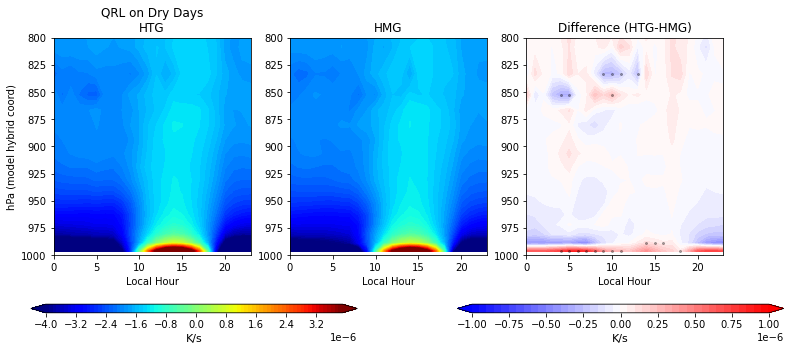

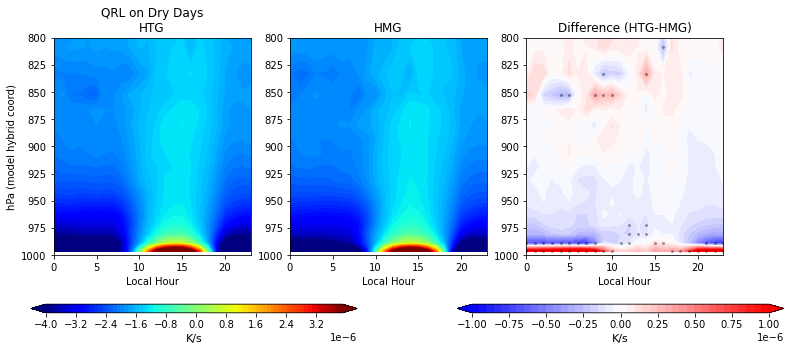

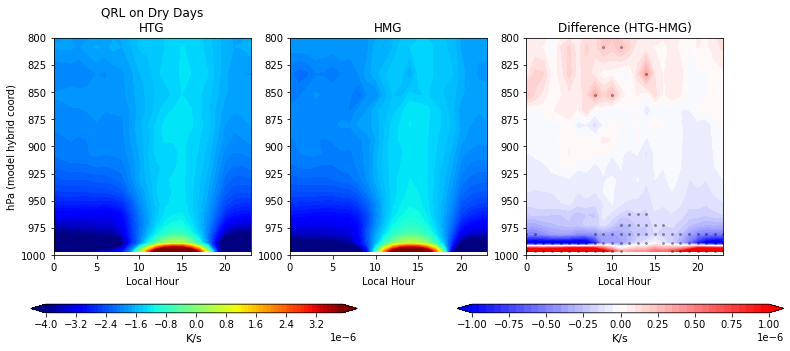

In [134]:
print(HTGcamDS_localReal.QRL.long_name)
plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart25,
                                                    'QRL',1000,800,
                                                    np.arange(-1e-6, 1.05e-6, 0.05e-6), 
                                                           np.arange(-4e-6,4e-6,0.1e-6))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart5,
                                                    'QRL',1000,800,
                                                    np.arange(-1e-6, 1.05e-6, 0.05e-6), 
                                                           np.arange(-4e-6,4e-6,0.1e-6))

plotTimeHeightDifference_meanDiurnalCycle_contourf(hourlyMean_dDry_HMGart, hourlyMean_dDry_HTGart,
                                                    'QRL',1000,800,
                                                    np.arange(-1e-6, 1.05e-6, 0.05e-6), 
                                                           np.arange(-4e-6,4e-6,0.1e-6))


### Just how different are the surfaces?

In [ ]:
timeArr = []
for iT in range(len(HMGcamDS_localArt_dailyMean.year_month_day.values)):
    timeArr = np.append(timeArr, datetime.date(HMGcamDS_localArt_dailyMean.year_month_day.values[iT][0],
                                               HMGcamDS_localArt_dailyMean.year_month_day.values[iT][1],
                                               HMGcamDS_localArt_dailyMean.year_month_day.values[iT][2]))



In [ ]:
fig,axs = plt.subplots(1,4, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean TREFHT \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGcamDS_localArt_dailyMean.TREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HMGcamDS_localArt_dailyMean.TREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGcamDS_localArt_dailyMean.TREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HMGcamDS_localArt_dailyMean.TREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([295,325])
axs[1].set_ylim([295,325])
axs[2].set_ylim([295,325])
axs[3].set_ylim([295,325])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[1].axvline(datetime.date(2016,7,18),color='grey',linestyle=':')
axs[1].axvline(datetime.date(2016,8,1),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,20),color='grey',linestyle=':')


In [ ]:
fig,axs = plt.subplots(1,4, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean QREFHT \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([0.001,0.05])
axs[1].set_ylim([0.001,0.05])
axs[2].set_ylim([0.001,0.05])
axs[3].set_ylim([0.001,0.05])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[1].axvline(datetime.date(2016,7,18),color='grey',linestyle=':')
axs[1].axvline(datetime.date(2016,8,1),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,20),color='grey',linestyle=':')


In [ ]:
fig,axs = plt.subplots(1,4, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean SHFLX \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([-50,140])
axs[1].set_ylim([-50,140])
axs[2].set_ylim([-50,140])
axs[3].set_ylim([-50,140])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,10),color='grey',linestyle=':')



In [ ]:
fig,axs = plt.subplots(1,4, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean LHFLX \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([0,180])
axs[1].set_ylim([0,180])
axs[2].set_ylim([0,180])
axs[3].set_ylim([0,180])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,10),color='grey',linestyle=':')




In [ ]:
fig,axs = plt.subplots(1,4, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean SOILWATER_10CM \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HTGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HTGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([0,50])
axs[1].set_ylim([0,50])
axs[2].set_ylim([0,50])
axs[3].set_ylim([0,50])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,10),color='grey',linestyle=':')




In [ ]:
fig,axs = plt.subplots(2,2, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGclmDS_localDailyMean_art.RAIN.values, color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGclmDS_localDailyMean_art.RAIN.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGclmDS_localDailyMean_real.RAIN.values, color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGclmDS_localDailyMean_real.RAIN.values, color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean RAIN \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGclmDS_localDailyMean_art.RAIN.values, color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HTGclmDS_localDailyMean_art.RAIN.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGclmDS_localDailyMean_real.RAIN.values, color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HTGclmDS_localDailyMean_real.RAIN.values, color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGclmDS_localDailyMean_art.RAIN.values, color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGclmDS_localDailyMean_art.RAIN.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGclmDS_localDailyMean_real.RAIN.values, color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGclmDS_localDailyMean_real.RAIN.values, color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGclmDS_localDailyMean_art.RAIN.values, color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGclmDS_localDailyMean_art.RAIN.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGclmDS_localDailyMean_real.RAIN.values, color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGclmDS_localDailyMean_real.RAIN.values, color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([0,0.0005])
axs[1].set_ylim([0,0.0005])
axs[2].set_ylim([0,0.0005])
axs[3].set_ylim([0,0.0005])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,10),color='grey',linestyle=':')





## What are some ways we can separate data?

In [ ]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

axs.scatter(HMGclmDS_localDailyMean_art.stdET.values, HTGclmDS_localDailyMean_art.stdET.values,
            color='deeppink', alpha=0.5)
axs.scatter(HMGclmDS_localDailyMean_real.stdET.values, HTGclmDS_localDailyMean_real.stdET.values,
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of stdET values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])
axs.grid()

In [ ]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

axs.scatter(HMGcamDS_localDailyMean_art.EvapFraction.values, HTGcamDS_localDailyMean_art.EvapFraction.values,
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real.EvapFraction.values, HTGcamDS_localDailyMean_real.EvapFraction.values,
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of EvapFraction values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])

axs.set_ylim([-1,5])
axs.set_xlim([-1,5])

In [ ]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

axs.scatter(HMGcamDS_localDailyMean_art.SHFLX.values, HTGcamDS_localDailyMean_art.SHFLX.values,
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real.SHFLX.values, HTGcamDS_localDailyMean_real.SHFLX.values,
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of SHFLX values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])



In [ ]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

axs.scatter(HMGcamDS_localDailyMean_art.LHFLX.values, HTGcamDS_localDailyMean_art.LHFLX.values,
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real.LHFLX.values, HTGcamDS_localDailyMean_real.LHFLX.values,
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of LHFLX values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])




In [ ]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

axs.scatter(HMGcamDS_localDailyMean_art.U10.values, HTGcamDS_localDailyMean_art.U10.values,
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real.U10.values, HTGcamDS_localDailyMean_real.U10.values,
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of U10 values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])




In [ ]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

controlVar = 'THLP2_CLUBB'

axs.scatter(HMGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0],
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0],
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of '+controlVar+' [ilev=-1] values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])

axs.grid()


In [ ]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

controlVar = 'RTP2_CLUBB'

axs.scatter(HMGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0],
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0],
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of '+controlVar+' [ilev=-1] values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])

axs.grid()

axs.set_ylim([0,3])
# axs.set_xlim([0,0.3])

In [ ]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

controlVar = 'RTPTHLP_CLUBB'

axs.scatter(HMGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0],
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0],
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of '+controlVar+' [ilev=-1] values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])

axs.grid()

axs.set_ylim([-1,0.5])
# axs.set_xlim([0,0.3])

### Try looking at just values with "low" moments in HTG (at least wrt artificial surface values

In [ ]:
'''
Find all the times in the full array (dt) that match up with daily mean conditions 
'''
def getTimes_basedOnCondition(fullDS, conditionDS):
    iTimes = []
    
    for iTime in range(len(conditionDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==conditionDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==conditionDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==conditionDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_match = fullDS.isel(time=iTimes)
    
    return(DS_match)



In [ ]:
## Also going to add selection for month - for june, before systematic changes have set up - is the response similar? 
selMonth = 6


## If variable is 3D and within CAM output: 

selVar   = 'THLP2_CLUBB'
selLev   = -1
iMax_val = 0.5
iMin_val = 0

## Now find where those conditions are met in each array 
#  But right now, I'm interested in just the HTG values, so don't need to seperately select HMG days 
iselDays_HMGart  = np.where( (HMGcamDS_localDailyMean_art[selVar].values[:,selLev,0,0]>=iMin_val) 
                           & (HMGcamDS_localDailyMean_art[selVar].values[:,selLev,0,0]<=iMax_val)
                           & (HMGcamDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]

iselDays_HTGart  = np.where( (HTGcamDS_localDailyMean_art[selVar].values[:,selLev,0,0]>=iMin_val) 
                           & (HTGcamDS_localDailyMean_art[selVar].values[:,selLev,0,0]<=iMax_val)
                           & (HTGcamDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]


iselDays_HMGreal = np.where( (HMGcamDS_localDailyMean_real[selVar].values[:,selLev,0,0]>=iMin_val) 
                           & (HMGcamDS_localDailyMean_real[selVar].values[:,selLev,0,0]<=iMax_val)
                           & (HMGcamDS_localDailyMean_real.year_month_day_level_1.values==selMonth))[0]

iselDays_HTGreal = np.where( (HTGcamDS_localDailyMean_real[selVar].values[:,selLev,0,0]>=iMin_val) 
                           & (HTGcamDS_localDailyMean_real[selVar].values[:,selLev,0,0]<=iMax_val)
                           & (HTGcamDS_localDailyMean_real.year_month_day_level_1.values==selMonth))[0]


## If variable is 2D and within CLM output: 

# selVar   = 'stdET'
# iMax_val = 2.25e-5
# iMin_val = 1.25e-5 

# ## Now find where those conditions are met in each array 
# #  But right now, I'm interested in just the HTG values, so don't need to seperately select HMG days 
# iselDays_HMGart  = np.where( (HMGclmDS_localDailyMean_art[selVar].values>=iMin_val) 
#                            & (HMGclmDS_localDailyMean_art[selVar].values<=iMax_val) 
#                            & (HMGclmDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]

# iselDays_HTGart  = np.where( (HTGclmDS_localDailyMean_art[selVar].values>=iMin_val) 
#                            & (HTGclmDS_localDailyMean_art[selVar].values<=iMax_val)
#                            & (HMGclmDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]


# iselDays_HMGreal = np.where( (HMGclmDS_localDailyMean_real[selVar].values>=iMin_val) 
#                            & (HMGclmDS_localDailyMean_real[selVar].values<=iMax_val)
#                            & (HMGclmDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]

# iselDays_HTGreal = np.where( (HTGclmDS_localDailyMean_real[selVar].values>=iMin_val) 
#                            & (HTGclmDS_localDailyMean_real[selVar].values<=iMax_val)
#                            & (HMGclmDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]



## Only keep days where both HMG *and* HTG cases meet the condition 
setHMG_art = set(iselDays_HMGart)
setHTG_art = set(iselDays_HTGart)
iKeep_art  = list(setHMG_art & setHTG_art)
HMG_art   = HMGcamDS_localDailyMean_art.isel(year_month_day = iKeep_art)
HTG_art   = HTGcamDS_localDailyMean_art.isel(year_month_day = iKeep_art)

setHMG_real = set(iselDays_HMGreal)
setHTG_real = set(iselDays_HTGreal)
iKeep_real  = list(setHMG_real & setHTG_real)
HMG_real   = HMGcamDS_localDailyMean_art.isel(year_month_day = iKeep_real)
HTG_real   = HTGcamDS_localDailyMean_art.isel(year_month_day = iKeep_real)


print('Number of days meeting condition in artificial case: ', len(iKeep_art))
print('Number of days meeting condition in real case:       ', len(iKeep_real))

HMGcamDS_art_condition = getTimes_basedOnCondition(HMGcamDS_artificial, HMG_art)
HTGcamDS_art_condition = getTimes_basedOnCondition(HTGcamDS_artificial, HTG_art)

HMGcamDS_real_condition = getTimes_basedOnCondition(HMGcamDS_real, HMG_real)
HTGcamDS_real_condition = getTimes_basedOnCondition(HTGcamDS_real, HTG_real)



In [ ]:

# Get means a function of hour of day within each dry/wet day category
hourlyMean_artificial_HMG = HMGcamDS_art_condition.groupby("time.hour").mean()
hourlyMean_artificial_HTG = HTGcamDS_art_condition.groupby("time.hour").mean()

hourlyMean_real_HMG = HMGcamDS_real_condition.groupby("time.hour").mean()
hourlyMean_real_HTG = HTGcamDS_real_condition.groupby("time.hour").mean()

# Get std as function of hour of day too
hourlyStd_artificial_HMG = HMGcamDS_art_condition.groupby("time.hour").std(dim='time')
hourlyStd_artificial_HTG = HTGcamDS_art_condition.groupby("time.hour").std(dim='time')

hourlyStd_real_HMG = HMGcamDS_real_condition.groupby("time.hour").std(dim='time')
hourlyStd_real_HTG = HTGcamDS_real_condition.groupby("time.hour").std(dim='time')


# Get number of obs going into those hourly means (for error bars)
nTimes_artificial = np.full([24], np.nan)
nTimes_real       = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_artificial[iHr] = len(np.where(HMGcamDS_art_condition["time.hour"]==iHr)[0])
    nTimes_real[iHr]       = len(np.where(HMGcamDS_real_condition["time.hour"]==iHr)[0])

    
hourlyMean_artificial_HMG['SampleCount']         = (('hour'), nTimes_artificial)
hourlyMean_artificial_HTG['SampleCount']         = (('hour'), nTimes_artificial)

hourlyMean_real_HMG['SampleCount']         = (('hour'), nTimes_real)
hourlyMean_real_HTG['SampleCount']         = (('hour'), nTimes_real)



In [ ]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['PBLdepth','LHFLX','SHFLX','TREFHT','QREFHT'])

fig,axs = plt.subplots(len(varSel),2, figsize=(15,20))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([2300])
yMin = np.asarray([ 100])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_artificial_HMG.hour.values, np.squeeze(hourlyMean_artificial_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_artificial_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_artificial_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_artificial_HTG.hour.values, np.squeeze(hourlyMean_artificial_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_artificial_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_artificial_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\nArtificial surface', fontsize=14)
    if varSel[iVar]=='PBLdepth':
#         axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
        axs[iPlot].set_ylabel('m')
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_real[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_real_HMG.hour.values, np.squeeze(hourlyMean_real_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_real_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_real_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_real_HTG.hour.values, np.squeeze(hourlyMean_real_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_real_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_real_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nReal surface', fontsize=14)  
    
#     axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
#     axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
    axs[iPlot+0].grid()
    axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2

    

### What if we only look at when all the moments of HTG are within the range simulated by the 'real' sfc case?

In [ ]:
mxHTG_thlp2 = np.nanmax(HTGcamDS_localDailyMean_real.THLP2_CLUBB.values[:,-1,0,0])
mxHTG_rtp2  = np.nanmax(HTGcamDS_localDailyMean_real.RTP2_CLUBB.values[:,-1,0,0])
mxHTG_rtpthlp = np.nanmax(HTGcamDS_localDailyMean_real.RTPTHLP_CLUBB.values[:,-1,0,0])

mnHTG_thlp2 = np.nanmin(HTGcamDS_localDailyMean_real.THLP2_CLUBB.values[:,-1,0,0])
mnHTG_rtp2  = np.nanmin(HTGcamDS_localDailyMean_real.RTP2_CLUBB.values[:,-1,0,0])
mnHTG_rtpthlp = np.nanmin(HTGcamDS_localDailyMean_real.RTPTHLP_CLUBB.values[:,-1,0,0])

match_artificialHTG = np.where( (HTGcamDS_localDailyMean_art.THLP2_CLUBB.values[:,-1,0,0] >=mnHTG_thlp2) 
                              & (HTGcamDS_localDailyMean_art.THLP2_CLUBB.values[:,-1,0,0] <=mxHTG_thlp2)
                              & (HTGcamDS_localDailyMean_art.RTP2_CLUBB.values[:,-1,0,0] >=mnHTG_rtp2) 
                              & (HTGcamDS_localDailyMean_art.RTP2_CLUBB.values[:,-1,0,0] <=mxHTG_rtp2)
                              & (HTGcamDS_localDailyMean_art.RTPTHLP_CLUBB.values[:,-1,0,0] >=mnHTG_rtpthlp) 
                              & (HTGcamDS_localDailyMean_art.RTPTHLP_CLUBB.values[:,-1,0,0] <=mxHTG_rtpthlp))[0]

HMG_art   = HMGcamDS_localDailyMean_art.isel(year_month_day = match_artificialHTG)
HTG_art   = HTGcamDS_localDailyMean_art.isel(year_month_day = match_artificialHTG)

HMGcamDS_art_condition = getTimes_basedOnCondition(HMGcamDS_artificial, HMG_art)
HTGcamDS_art_condition = getTimes_basedOnCondition(HTGcamDS_artificial, HTG_art)


In [ ]:

# Get means a function of hour of day within each dry/wet day category
hourlyMean_artificial_HMG = HMGcamDS_art_condition.groupby("time.hour").mean()
hourlyMean_artificial_HTG = HTGcamDS_art_condition.groupby("time.hour").mean()

hourlyMean_real_HMG = HMGcamDS_real.groupby("time.hour").mean()
hourlyMean_real_HTG = HTGcamDS_real.groupby("time.hour").mean()

# Get std as function of hour of day too
hourlyStd_artificial_HMG = HMGcamDS_art_condition.groupby("time.hour").std(dim='time')
hourlyStd_artificial_HTG = HTGcamDS_art_condition.groupby("time.hour").std(dim='time')

hourlyStd_real_HMG = HMGcamDS_real.groupby("time.hour").std(dim='time')
hourlyStd_real_HTG = HTGcamDS_real.groupby("time.hour").std(dim='time')


# Get number of obs going into those hourly means (for error bars)
nTimes_artificial = np.full([24], np.nan)
nTimes_real       = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_artificial[iHr] = len(np.where(HMGcamDS_art_condition["time.hour"]==iHr)[0])
    nTimes_real[iHr]       = len(np.where(HMGcamDS_real["time.hour"]==iHr)[0])

    
hourlyMean_artificial_HMG['SampleCount']         = (('hour'), nTimes_artificial)
hourlyMean_artificial_HTG['SampleCount']         = (('hour'), nTimes_artificial)

hourlyMean_real_HMG['SampleCount']         = (('hour'), nTimes_real)
hourlyMean_real_HTG['SampleCount']         = (('hour'), nTimes_real)




In [ ]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['PBLdepth','LHFLX','SHFLX','TREFHT','QREFHT'])

fig,axs = plt.subplots(len(varSel),2, figsize=(15,20))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([2300])
yMin = np.asarray([ 100])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_artificial_HMG.hour.values, np.squeeze(hourlyMean_artificial_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_artificial_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_artificial_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_artificial_HTG.hour.values, np.squeeze(hourlyMean_artificial_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_artificial_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_artificial_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\nArtificial surface', fontsize=14)
    if varSel[iVar]=='PBLdepth':
#         axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
        axs[iPlot].set_ylabel('m')
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_real[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_real_HMG.hour.values, np.squeeze(hourlyMean_real_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_real_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_real_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_real_HTG.hour.values, np.squeeze(hourlyMean_real_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_real_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_real_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nReal surface', fontsize=14)  
    
#     axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
#     axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
    axs[iPlot+0].grid()
    axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


## Let's zoom into some of the interesting 'windows' identified in the first section 

In [ ]:
## Read in forcing too...
nateForcingFileHTG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-htg.nc'
nateDS             = xr.open_dataset(nateForcingFileHTG, decode_times='True')


In [ ]:
iWindow1 = np.where( (HMGcamDS_artificial.time.values>=np.datetime64('2015-07-08'))
                   & (HMGcamDS_artificial.time.values<=np.datetime64('2015-08-11')))[0]

iWindow2 = np.where( (HMGcamDS_artificial.time.values>=np.datetime64('2016-07-18'))
                   & (HMGcamDS_artificial.time.values<=np.datetime64('2016-08-02')))[0]

iWindow3 = np.where( (HMGcamDS_artificial.time.values>=np.datetime64('2017-07-10'))
                   & (HMGcamDS_artificial.time.values<=np.datetime64('2017-08-21')))[0]


window1_HMGartitificial = HMGcamDS_artificial.isel(time=iWindow1)
window1_HTGartitificial = HTGcamDS_artificial.isel(time=iWindow1)
window1_HMGreal = HMGcamDS_real.isel(time=iWindow1)
window1_HTGreal = HTGcamDS_real.isel(time=iWindow1)


window2_HMGartitificial = HMGcamDS_artificial.isel(time=iWindow2)
window2_HTGartitificial = HTGcamDS_artificial.isel(time=iWindow2)
window2_HMGreal = HMGcamDS_real.isel(time=iWindow2)
window2_HTGreal = HTGcamDS_real.isel(time=iWindow2)


window3_HMGartitificial = HMGcamDS_artificial.isel(time=iWindow3)
window3_HTGartitificial = HTGcamDS_artificial.isel(time=iWindow3)
window3_HMGreal = HMGcamDS_real.isel(time=iWindow3)
window3_HTGreal = HTGcamDS_real.isel(time=iWindow3)


In [ ]:
## Land datasets too 
window1_HMGartitificialCLM = HMGclmDS_artificial.isel(time=iWindow1)
window1_HTGartitificialCLM = HTGclmDS_artificial.isel(time=iWindow1)
window1_HMGrealCLM = HMGclmDS_real.isel(time=iWindow1)
window1_HTGrealCLM = HTGclmDS_real.isel(time=iWindow1)


window2_HMGartitificialCLM = HMGclmDS_artificial.isel(time=iWindow2)
window2_HTGartitificialCLM = HTGclmDS_artificial.isel(time=iWindow2)
window2_HMGrealCLM = HMGclmDS_real.isel(time=iWindow2)
window2_HTGrealCLM = HTGclmDS_real.isel(time=iWindow2)

window3_HMGartitificialCLM = HMGclmDS_artificial.isel(time=iWindow3)
window3_HTGartitificialCLM = HTGclmDS_artificial.isel(time=iWindow3)
window3_HMGrealCLM = HMGclmDS_real.isel(time=iWindow3)
window3_HTGrealCLM = HTGclmDS_real.isel(time=iWindow3)


In [ ]:
## Get those windows in the forcings too
iWindow1obs = np.where( (nateDS.time.values>=np.datetime64('2015-07-08'))
                   & (nateDS.time.values<=np.datetime64('2015-08-11')))[0]

iWindow2obs = np.where( (nateDS.time.values>=np.datetime64('2016-07-18'))
                   & (nateDS.time.values<=np.datetime64('2016-08-02')))[0]

iWindow3obs = np.where( (nateDS.time.values>=np.datetime64('2017-07-10'))
                   & (nateDS.time.values<=np.datetime64('2017-08-21')))[0]

window1_nateDS = nateDS.isel(time=iWindow1obs)
window2_nateDS = nateDS.isel(time=iWindow2obs)
window3_nateDS = nateDS.isel(time=iWindow3obs)


**Window 1: 2015**

In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.TREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.TREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window1_HMGreal.time.values, window1_HMGreal.TREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window1_HTGreal.time.values, window1_HTGreal.TREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nTREFHT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.QREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.QREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.QREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.QREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2)
axs[1].set_title('QREFHT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)


axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.SHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.SHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window1_HMGreal.time.values, window1_HMGreal.SHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window1_HTGreal.time.values, window1_HTGreal.SHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nSHFLX')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.LHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.LHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.LHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.LHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('LHFLX')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)


axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.PRECT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.PRECT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window1_HMGreal.time.values, window1_HMGreal.PRECT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window1_HTGreal.time.values, window1_HTGreal.PRECT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nPRECT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.CLDTOT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.CLDTOT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.CLDTOT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.CLDTOT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('CLDTOT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)


axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.PBLdepth.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.PBLdepth.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window1_HMGreal.time.values, window1_HMGreal.PBLdepth.values, 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window1_HTGreal.time.values, window1_HTGreal.PBLdepth.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nPBLdepth')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.U10.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.U10.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.U10.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.U10.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('U10')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)


axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



In [ ]:
fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificialCLM.time.values, window1_HMGartitificialCLM.SOILWATER_10CM.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificialCLM.time.values, window1_HTGartitificialCLM.SOILWATER_10CM.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window1_HMGrealCLM.time.values, window1_HMGrealCLM.SOILWATER_10CM.values,
            color='yellowgreen',label='HMG_real')
axs[0].plot(window1_HTGrealCLM.time.values, window1_HTGrealCLM.SOILWATER_10CM.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nSOILWATER_10CM')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGartitificialCLM.time.values, window1_HMGartitificialCLM.FSDS.values, 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window1_HTGartitificialCLM.time.values, window1_HTGartitificialCLM.FSDS.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window1_HMGrealCLM.time.values, window1_HMGrealCLM.FSDS.values,
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGrealCLM.time.values, window1_HTGrealCLM.FSDS.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('FSDS')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)


axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


In [ ]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window1_nateDS.time, window1_nateDS.lev.values, 
                                np.transpose(np.squeeze(window1_nateDS.q_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window1_nateDS.time, window1_nateDS.lev.values, 
                                np.transpose(np.squeeze(window1_nateDS.q_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.q_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.q_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.q_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


In [ ]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window1_nateDS.time, window1_nateDS.lev.values, 
                                np.transpose(np.squeeze(window1_nateDS.T_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window1_nateDS.time, window1_nateDS.lev.values, 
                                np.transpose(np.squeeze(window1_nateDS.T_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.T_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.T_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.T_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nTHLP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\n RTP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\n RTPTHLP_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


**Window 2**

In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.TREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.TREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window2_HMGreal.time.values, window2_HMGreal.TREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window2_HTGreal.time.values, window2_HTGreal.TREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nTREFHT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.QREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.QREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.QREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.QREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2)
axs[1].set_title('QREFHT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.SHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.SHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window2_HMGreal.time.values, window2_HMGreal.SHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window2_HTGreal.time.values, window2_HTGreal.SHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nSHFLX')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.LHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.LHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.LHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.LHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('LHFLX')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.PRECT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.PRECT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window2_HMGreal.time.values, window2_HMGreal.PRECT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window2_HTGreal.time.values, window2_HTGreal.PRECT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nPRECT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.CLDTOT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.CLDTOT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.CLDTOT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.CLDTOT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('CLDTOT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.PBLdepth.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.PBLdepth.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window2_HMGreal.time.values, window2_HMGreal.PBLdepth.values, 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window2_HTGreal.time.values, window2_HTGreal.PBLdepth.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nPBLdepth')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.U10.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.U10.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.U10.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.U10.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('U10')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




In [ ]:
fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificialCLM.time.values, window2_HMGartitificialCLM.SOILWATER_10CM.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificialCLM.time.values, window2_HTGartitificialCLM.SOILWATER_10CM.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window2_HMGrealCLM.time.values, window2_HMGrealCLM.SOILWATER_10CM.values,
            color='yellowgreen',label='HMG_real')
axs[0].plot(window2_HTGrealCLM.time.values, window2_HTGrealCLM.SOILWATER_10CM.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nSOILWATER_10CM')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGartitificialCLM.time.values, window2_HMGartitificialCLM.FSDS.values, 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window2_HTGartitificialCLM.time.values, window2_HTGartitificialCLM.FSDS.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window2_HMGrealCLM.time.values, window2_HMGrealCLM.FSDS.values,
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGrealCLM.time.values, window2_HTGrealCLM.FSDS.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('FSDS')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



In [ ]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window2_nateDS.time, window2_nateDS.lev.values, 
                                np.transpose(np.squeeze(window2_nateDS.q_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window2_nateDS.time, window2_nateDS.lev.values, 
                                np.transpose(np.squeeze(window2_nateDS.q_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.q_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.q_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.q_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



In [ ]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window2_nateDS.time, window2_nateDS.lev.values, 
                                np.transpose(np.squeeze(window2_nateDS.T_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window2_nateDS.time, window2_nateDS.lev.values, 
                                np.transpose(np.squeeze(window2_nateDS.T_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.T_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.T_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.T_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nTHLP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\n RTP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\n RTPTHLP_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




**Window 3**

In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.TREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.TREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window3_HMGreal.time.values, window3_HMGreal.TREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window3_HTGreal.time.values, window3_HTGreal.TREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nTREFHT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.QREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.QREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.QREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.QREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2)
axs[1].set_title('QREFHT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2017,7,15),color='k')
axs[0].axvline(datetime.date(2017,7,24),color='k')
axs[1].axvline(datetime.date(2017,7,15),color='k')
axs[1].axvline(datetime.date(2017,7,24),color='k')



# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.SHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.SHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window3_HMGreal.time.values, window3_HMGreal.SHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window3_HTGreal.time.values, window3_HTGreal.SHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nSHFLX')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.LHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.LHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.LHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.LHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('LHFLX')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.PRECT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.PRECT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window3_HMGreal.time.values, window3_HMGreal.PRECT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window3_HTGreal.time.values, window3_HTGreal.PRECT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nPRECT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.CLDTOT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.CLDTOT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.CLDTOT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.CLDTOT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('CLDTOT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.PBLdepth.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.PBLdepth.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window3_HMGreal.time.values, window3_HMGreal.PBLdepth.values, 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window3_HTGreal.time.values, window3_HTGreal.PBLdepth.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nPBLdepth')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.U10.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.U10.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.U10.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.U10.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('U10')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])





In [ ]:
fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificialCLM.time.values, window3_HMGartitificialCLM.SOILWATER_10CM.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificialCLM.time.values, window3_HTGartitificialCLM.SOILWATER_10CM.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window3_HMGrealCLM.time.values, window3_HMGrealCLM.SOILWATER_10CM.values,
            color='yellowgreen',label='HMG_real')
axs[0].plot(window3_HTGrealCLM.time.values, window3_HTGrealCLM.SOILWATER_10CM.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nSOILWATER_10CM')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGartitificialCLM.time.values, window3_HMGartitificialCLM.FSDS.values, 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window3_HTGartitificialCLM.time.values, window3_HTGartitificialCLM.FSDS.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window3_HMGrealCLM.time.values, window3_HMGrealCLM.FSDS.values,
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGrealCLM.time.values, window3_HTGrealCLM.FSDS.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('FSDS')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




In [ ]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window3_nateDS.time, window3_nateDS.lev.values, 
                                np.transpose(np.squeeze(window3_nateDS.q_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window3_nateDS.time, window3_nateDS.lev.values, 
                                np.transpose(np.squeeze(window3_nateDS.q_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.q_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.q_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.q_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




In [ ]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window3_nateDS.time, window3_nateDS.lev.values, 
                                np.transpose(np.squeeze(window3_nateDS.T_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window3_nateDS.time, window3_nateDS.lev.values, 
                                np.transpose(np.squeeze(window3_nateDS.T_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.T_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.T_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.T_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nTHLP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\n RTP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




In [ ]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\n RTPTHLP_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
